c:\Users\Magnus\Documents\GitHub\cro_symbolic_mbpo


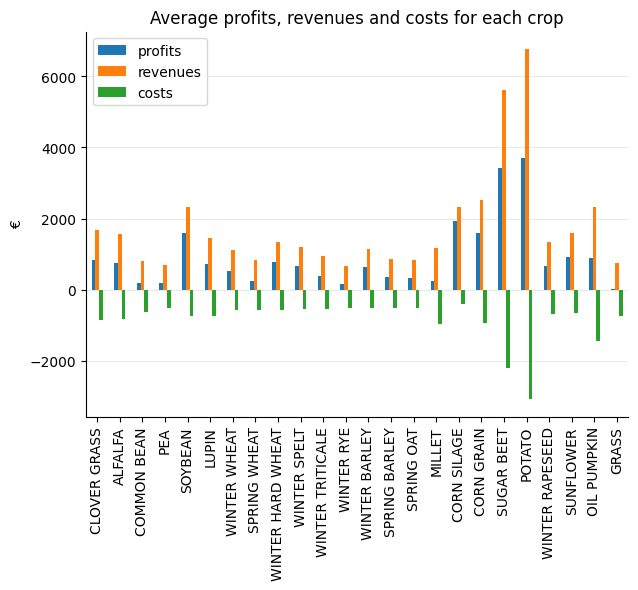

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
from numpy import random
from simulation_env.environment_maincrops.data.mappings import crop_mapping_german, crop_mapping_german_rev, crop_mapping_eng, date_mapping, date_mapping_rev
region = "Bundesgebiet"
print(os.getcwd())
json_file_path = "./simulation_env/environment_maincrops/data/maincrops_updated.json"
# Open and read the JSON file
with open(json_file_path, "r") as json_file:
    # Parse the JSON data into a Python dictionary
    maincrop_yields = json.load(json_file)
seed = 42
N=50
P=0
K=0
yields = np.array([random.normal(maincrop_yields[crop_name]["Ertrag"][region]["avg"], maincrop_yields[crop_name]["Ertrag"][region]["std"]) for crop_name in maincrop_yields.keys()])
prices_avg = np.array([crop["Verkaufspreis"]["avg"] for crop in maincrop_yields.values()])
prices_std = np.array([crop["Verkaufspreis"]["std"] for crop in maincrop_yields.values()])
prices = random.normal(prices_avg,prices_std)
sowing_costs_avg = np.array([crop["Kosten"]["Saatgut"]["avg"] for crop in maincrop_yields.values()])

other_costs_avg = np.array([crop["Kosten"]["Sonstiges"]["avg"] for crop in maincrop_yields.values()])

N_costs_avg = maincrop_yields["WINTERWEIZEN"]["Kosten"]["Duenger N"]["avg"]

P_costs_avg = maincrop_yields["WINTERWEIZEN"]["Kosten"]["Duenger P"]["avg"]

K_costs_avg = maincrop_yields["WINTERWEIZEN"]["Kosten"]["Duenger K"]["avg"]

average_N_fertilization_needs = np.array([max(maincrop_yields[crop_name]["Duengebedarf N"]["Value"] - N,0.0) for crop_name in maincrop_yields.keys()])
max_N_fertilization_needs = np.ones_like(average_N_fertilization_needs)*170.0
average_N_fertilization_needs = np.minimum(average_N_fertilization_needs,max_N_fertilization_needs)
average_P_fertilization_needs = np.array([max(maincrop_yields[crop_name]["Duengebedarf P"]["Value"] - P,0.0) for crop_name in maincrop_yields.keys()])
average_K_fertilization_needs = np.array([max(maincrop_yields[crop_name]["Duengebedarf K"]["Value"] - K,0.0) for crop_name in maincrop_yields.keys()])


average_N_fertilization_costs = N_costs_avg * average_N_fertilization_needs
average_P_fertilization_costs = P_costs_avg * average_P_fertilization_needs
average_K_fertilization_costs = K_costs_avg * average_K_fertilization_needs

# Calculate profits
average_revenues = yields * prices_avg
average_profits = yields * prices_avg - sowing_costs_avg - other_costs_avg - average_N_fertilization_costs - average_P_fertilization_costs - average_K_fertilization_costs
average_costs = -(sowing_costs_avg + other_costs_avg + average_N_fertilization_costs + average_P_fertilization_costs + average_K_fertilization_costs)

eng_keys = [crop_mapping_eng[crop_mapping_german_rev[crop]] for crop in maincrop_yields.keys()]
# Create a dataframe with the profits, revenues and costs for each crop
df = pd.DataFrame({"crop": list(eng_keys), "revenues": average_revenues, "costs": average_costs, "profits": average_profits})

# Plot profits next to revenues and costs for each crop in a barchart from the dataframe
df.plot.bar(x="crop", y=["profits", "revenues", "costs"], figsize=(7, 5), rot=0, zorder=2)
plt.title("Average profits, revenues and costs for each crop")
plt.ylabel("€", fontsize=10)
# Make the x-labels more readable by making them vertical
# remove xlabel
plt.xlabel("")
plt.xticks(rotation=90)
# remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# add horizontal grid in silver
ax.yaxis.grid(color='silver', linestyle='-', linewidth=0.5, alpha = 0.5, zorder=1)
plt.savefig("plots/general_vis/profits_revenues_costs.pdf", bbox_inches='tight')
plt.savefig("plots/general_vis/profits_revenues_costs.png", bbox_inches='tight')
plt.show()



# Plot results


### Helpers

In [3]:
import copy
from functools import partial
import os
def lpf(x, omega_c, T):
    """Implement a first-order low-pass filter.

    The input data is x, the filter's cutoff frequency is omega_c
    [rad/s] and the sample time is T [s].  The output is y.
    """
    y = copy.deepcopy(x)
    alpha = (2 - T * omega_c) / (2 + T * omega_c)
    beta = T * omega_c / (2 + T * omega_c)
    for k in range(1, len(x)):
        y[k] = alpha * y[k - 1] + beta * (x[k] + x[k - 1])
    return y


def calculate_lpf_iqr(raw_data, omega_c, T):
    lpf_partial = partial(lpf, omega_c=omega_c, T=T)
    data_lpf = np.apply_along_axis(lpf_partial,1,raw_data)
    upper_quartile = np.quantile(data_lpf,0.75,axis=0)
    lower_quartile = np.quantile(data_lpf,0.25,axis=0)
    iqr = upper_quartile - lower_quartile
    return iqr

def calculate_iqr_across_time_window(single_row, window_length):
    # print(single_row.shape)
    result = np.empty(single_row.shape[0]-window_length)
    for i in range(window_length,single_row.shape[0]):
        window = single_row[(i-window_length):i]
        upper_quartile = np.quantile(window,0.75)
        lower_quartile = np.quantile(window,0.25)
        iqr = upper_quartile - lower_quartile
        # if abs(iqr) > 200000 or math.isnan(iqr):
        #     print(upper_quartile,lower_quartile)
        result[i-window_length] = iqr
    return result

# Standard Result function

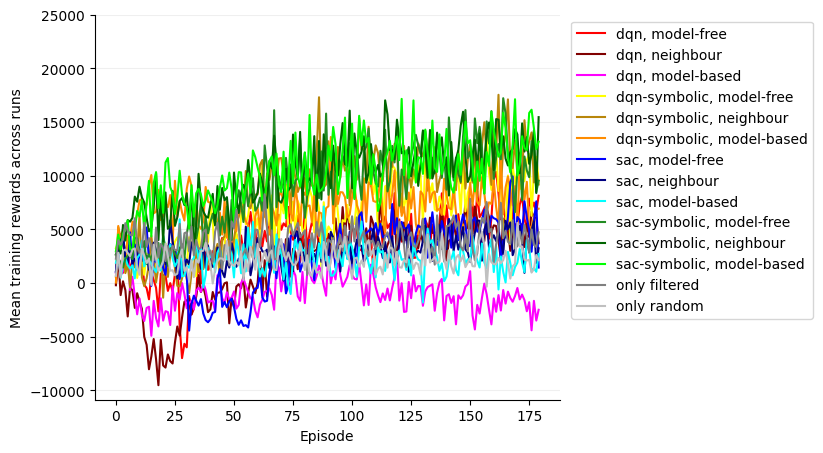

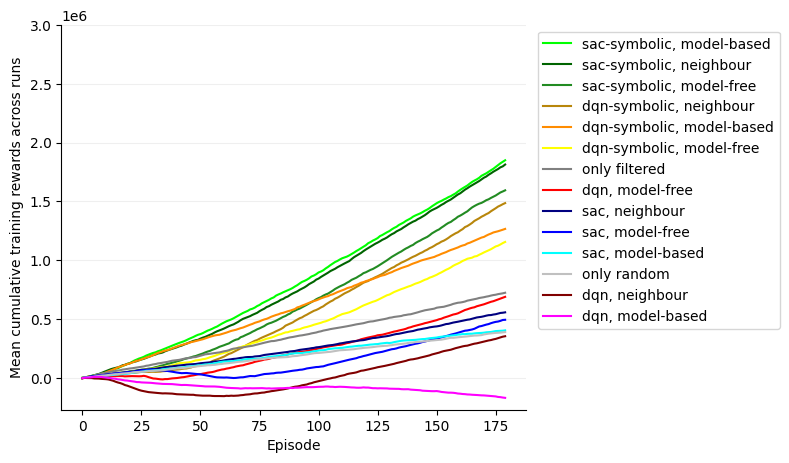

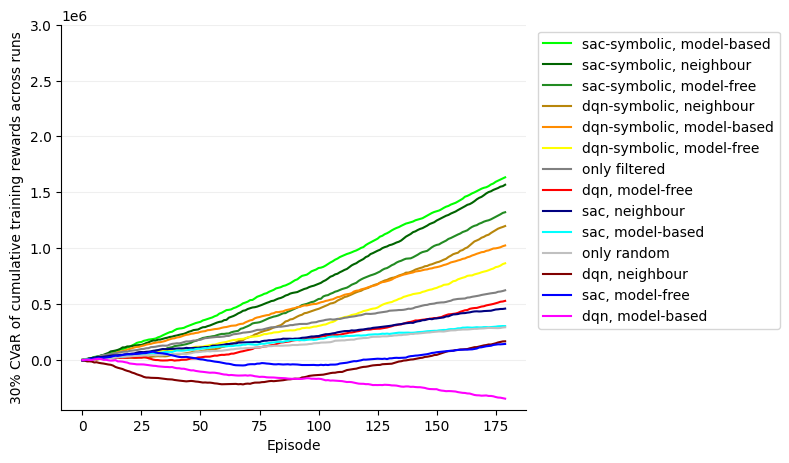

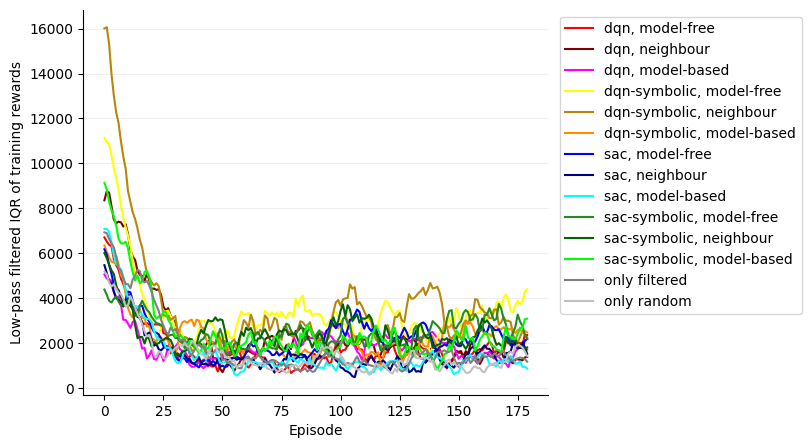

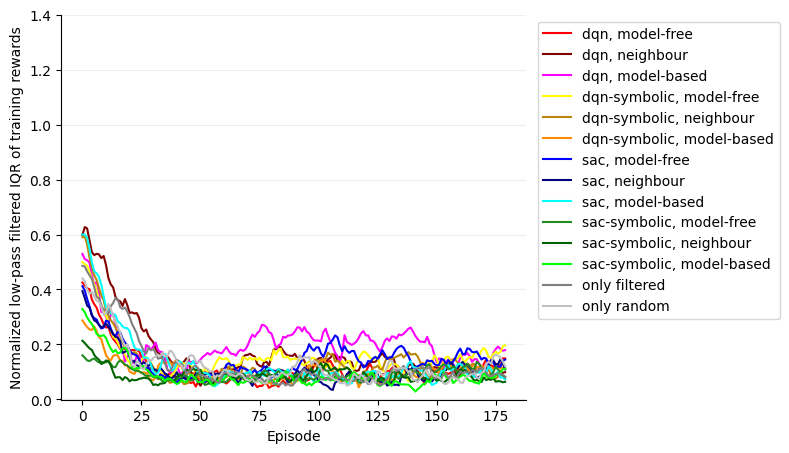

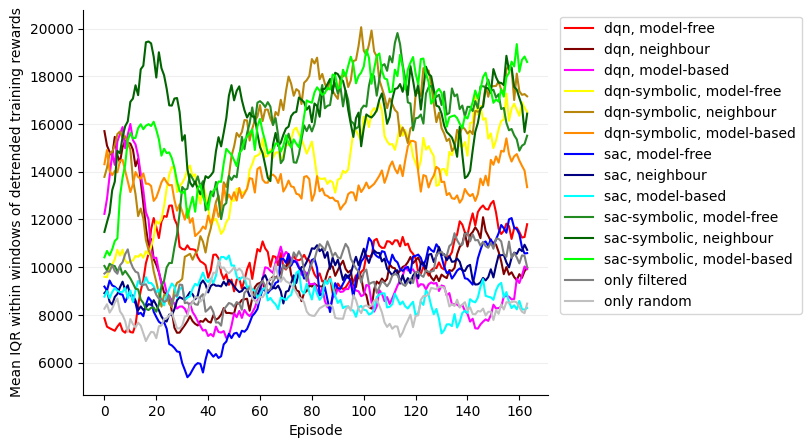

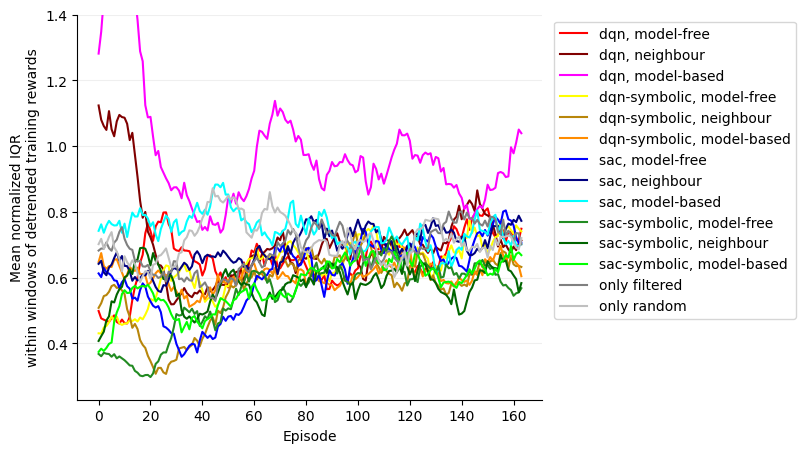

In [80]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
omega_c = 0.01
T = 5

SEEDS = [101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120]
AGENT_TYPES = ["prioritized","sac","prioritized_symbolic","sac_symbolic"]
MBRL_KEYS = ["non-mbrl","mbrl","neighbour"]
GROUND_TYPES = [-1.0,0.0,1.0]
DRYWETS = [0.0,1.0]
data_type = "cumulative_training_rewards"

# mbrl_key = "non-mbrl"
# mbrl_key = "neighbour"
mbrl_key = "mbrl"

legend_dict = {
    "prioritized":"dqn",
    "sac":"sac",
    "prioritized_symbolic":"dqn-symbolic",
    "sac_symbolic":"sac-symbolic",
    "non-mbrl":"model-free",
    "neighbour":"neighbour",
    "mbrl":"model-based"
}

legend_dict_reverse = {
    "dqn":"prioritized",
    "sac":"sac",
    "dqn-symbolic":"prioritized_symbolic",
    "sac-symbolic":"sac_symbolic",
    "model-free":"non-mbrl",
    "neighbour":"neighbour",
    "model-based":"mbrl"
}

color_dict = {
    "dqn, model-free":"red",
    "sac, model-free":"blue",
    "dqn-symbolic, model-free":"yellow",
    "sac-symbolic, model-free":"forestgreen",
    "dqn, neighbour":"maroon",
    "sac, neighbour":"navy",
    "dqn-symbolic, neighbour":"darkgoldenrod",
    "sac-symbolic, neighbour":"darkgreen",
    "dqn, model-based":"magenta",
    "sac, model-based":"cyan",
    "dqn-symbolic, model-based":"darkorange",
    "sac-symbolic, model-based":"lime",
    "only filtered":"grey",
    "only random":"silver"
}


def generate_path_for_results(plot_tuple,ground_type, drywet, seed):
    if plot_tuple == "only filtered":
        path = f"experiments/evaluations/results/symbolic_only_filter_{ground_type}_{drywet}_{seed}.pickle"
        return path
    elif plot_tuple == "only random":
        path = f"experiments/evaluations/results/only_random_{ground_type}_{drywet}_{seed}.pickle"
        return path
    else:
        data_key_tuple = (legend_dict_reverse[plot_tuple.split(", ")[0]],legend_dict_reverse[plot_tuple.split(", ")[1]])
        path = f"experiments/evaluations/results/{data_key_tuple[0]}_{data_key_tuple[1]}_{ground_type}_{drywet}_{seed}.pickle"
        return path
    



def plot_results(seeds, ground_type, drywet, data_key_tuples, window_length, folder_name = None):
    partial_calculate_iqr_across_time_window = partial(calculate_iqr_across_time_window, window_length=window_length)
    plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    results_dict = {}
    for plot_tuple in plot_tuples:
        results_dict[plot_tuple] = {}
        rewards_across_runs = np.empty((0,180))
        cumulative_rewards_across_runs = np.empty((0,180))
        diffs_during_runs = np.empty((0,179))
        q95s = []
        for seed in seeds:
            path = generate_path_for_results(plot_tuple, ground_type, drywet, seed)
            with open(path,"rb") as f:
                result = pickle.load(f)
            rewards = result["training_rewards"]
            diff_rewards = np.diff(rewards)
            cumulative_rewards = result["cumulative_training_rewards"]
            rewards_across_runs = np.vstack((rewards_across_runs,rewards))
            cumulative_rewards_across_runs = np.vstack((cumulative_rewards_across_runs,cumulative_rewards))
            diffs_during_runs = np.vstack((diffs_during_runs,diff_rewards))
            q95 = np.quantile(rewards,0.95)
            q95s.append(q95)
        q95_mean = np.mean(q95s)

        mean_rewards_across_runs = np.mean(rewards_across_runs,axis=0)
        mean_cumulative_rewards_across_runs = np.mean(cumulative_rewards_across_runs,axis=0)
        cumulative_rewards_last_entry = cumulative_rewards_across_runs[:,-1].flatten()
        cumulative_lower_30_quantile = np.quantile(cumulative_rewards_last_entry,0.3)
        lowest_30_percent_cumulative_rewards = cumulative_rewards_across_runs[cumulative_rewards_last_entry <= cumulative_lower_30_quantile]
        results_dict[plot_tuple]["mean_rewards"] = mean_rewards_across_runs
        results_dict[plot_tuple]["mean_cumulative_rewards"] = mean_cumulative_rewards_across_runs
        results_dict[plot_tuple]["cvar_cumulative_rewards"] = np.mean(lowest_30_percent_cumulative_rewards, axis=0)
        iqr_across_runs = calculate_lpf_iqr(rewards_across_runs, omega_c, T)
        results_dict[plot_tuple]["iqr_across_runs"] = iqr_across_runs
        results_dict[plot_tuple]["iqr_across_runs_normalized"] = iqr_across_runs/q95_mean
        iqrs_during_runs = np.apply_along_axis(partial_calculate_iqr_across_time_window,axis=1,arr=diffs_during_runs)
        mean_iqrs_during_runs = np.mean(iqrs_during_runs,axis=0)
        results_dict[plot_tuple]["mean_iqrs_during_runs"] = mean_iqrs_during_runs
        results_dict[plot_tuple]["mean_iqrs_during_runs_normalized"] = mean_iqrs_during_runs/q95_mean


    if folder_name is not None:
        general_path = f"plots/{folder_name}"
        if not os.path.exists(general_path):
            os.makedirs(general_path)

    def plot_results_by_key(key,ylabel, ymax = None):
        # Plot mean rewards
        plt.figure(figsize=(6,5))
        plot_tuples_unsorted = []

        if key == "mean_cumulative_rewards" or key == "cvar_cumulative_rewards":
            for plot_tuple in plot_tuples:
                plot_tuples_unsorted.append((results_dict[plot_tuple][key][-1],plot_tuple))
            plot_tuples_sorted = sorted(plot_tuples_unsorted, key = lambda x: x[0], reverse=True)
            for t in plot_tuples_sorted:
                result, plot_tuple = t
                plt.plot(results_dict[plot_tuple][key],label=plot_tuple, alpha=1.0, color=color_dict[plot_tuple])
        else:
            for plot_tuple in plot_tuples:
                plt.plot(results_dict[plot_tuple][key],label=plot_tuple, alpha=1.0, color=color_dict[plot_tuple])
        plt.grid(axis="y", alpha=0.2)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.xlabel("Episode")
        plt.ylabel(ylabel)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        if ymax is not None:
            plt.ylim(top=ymax)
        if folder_name is not None:
            image_path = f"{general_path}/{key}.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{key}.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()

    plot_results_by_key("mean_rewards","Mean training rewards across runs", ymax = 25000)
    plot_results_by_key("mean_cumulative_rewards","Mean cumulative training rewards across runs", ymax = 3e6)
    plot_results_by_key("cvar_cumulative_rewards","30% CVaR of cumulative training rewards across runs", ymax = 3e6)
    plot_results_by_key("iqr_across_runs","Low-pass filtered IQR of training rewards")
    plot_results_by_key("iqr_across_runs_normalized","Normalized low-pass filtered IQR of training rewards", ymax = 1.4)
    plot_results_by_key("mean_iqrs_during_runs","Mean IQR within windows of detrended training rewards")
    plot_results_by_key("mean_iqrs_during_runs_normalized","Mean normalized IQR\nwithin windows of detrended training rewards", ymax = 1.4)


# folder_name = "all_non-symbolic_nopt_baseline"
# agent_type = "sac"
# agent_type2 = "prioritized"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# plot_results(SEEDS, ground_type = 0.0,drywet = 1.0, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)

# folder_name = "all_symbolic_nopt_baseline"
# agent_type = "sac_symbolic"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# plot_results(SEEDS, ground_type = 0.0,drywet = 1.0, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)

# folder_name = "dqn_all_nopt_baseline"
# agent_type = "prioritized"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# plot_results(SEEDS, ground_type = 0.0,drywet = 1.0, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)

# folder_name = "sac_all_nopt_baseline"
# agent_type = "sac"
# agent_type2 = "sac_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# plot_results(SEEDS, ground_type = 0.0,drywet = 1.0, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)

folder_name = "all_all_nopt_baseline"
agent_type = "prioritized"
agent_type2 = "prioritized_symbolic"
agent_type3 = "sac"
agent_type4 = "sac_symbolic"
data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl"),(agent_type3,"non-mbrl"),(agent_type3,"neighbour"),(agent_type3,"mbrl"),(agent_type4,"non-mbrl"),(agent_type4,"neighbour"),(agent_type4,"mbrl")]
plot_results(SEEDS, ground_type = 0.0,drywet = 1.0, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)




# Soil condition comparison

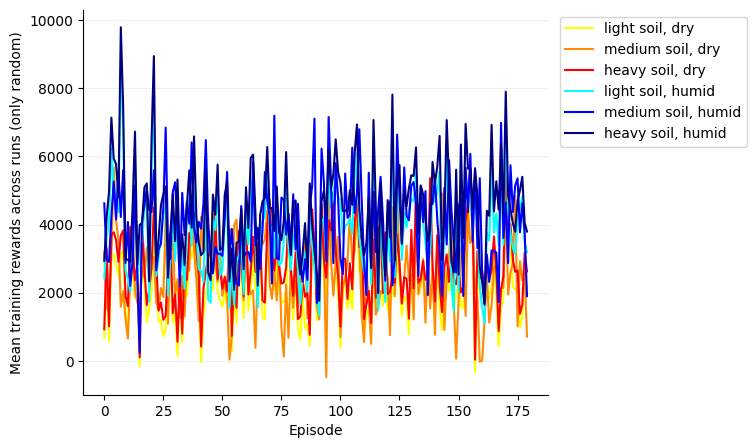

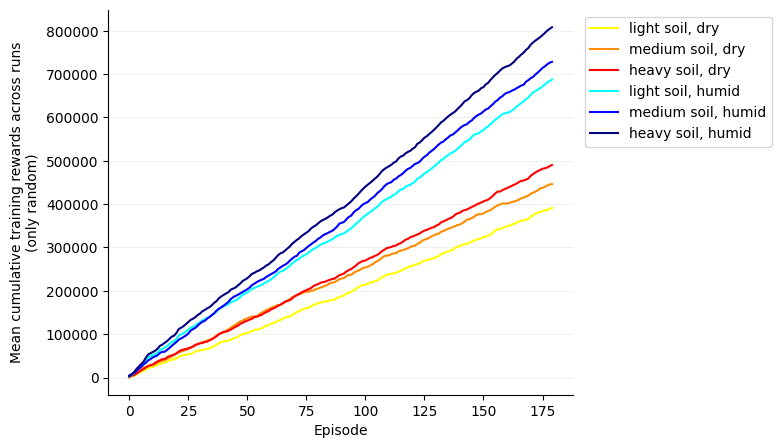

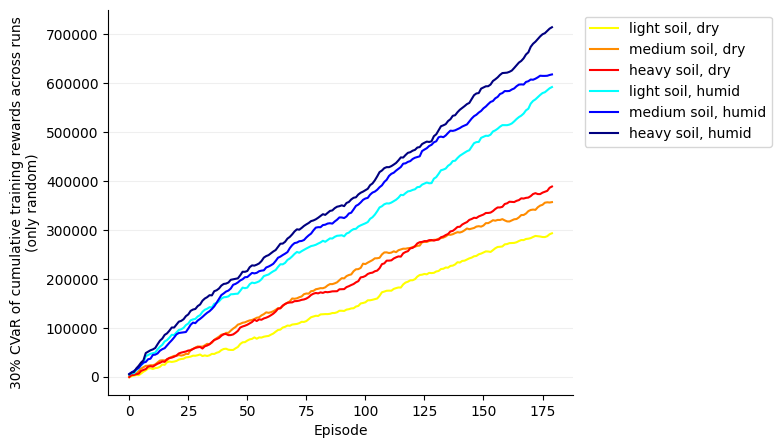

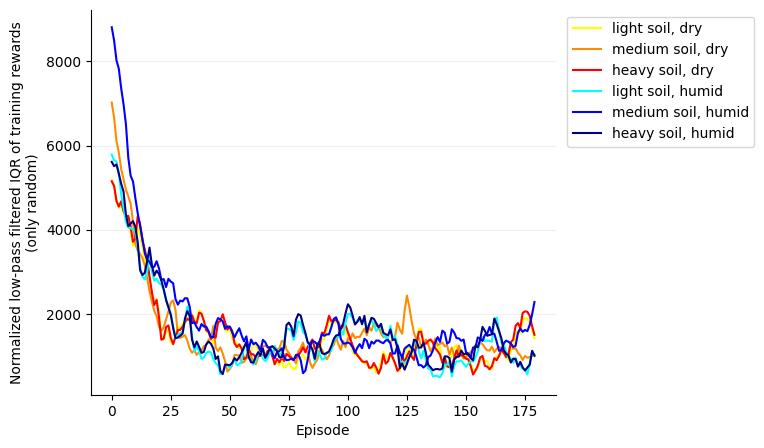

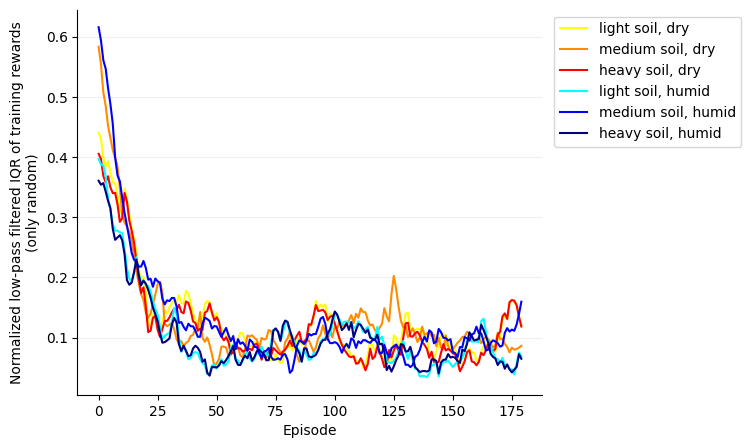

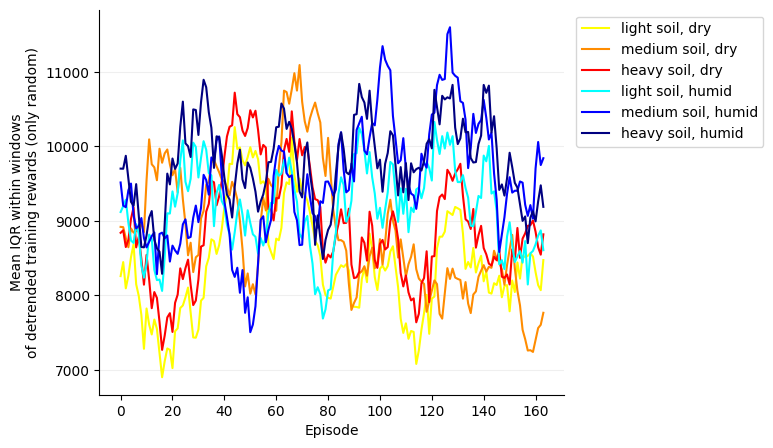

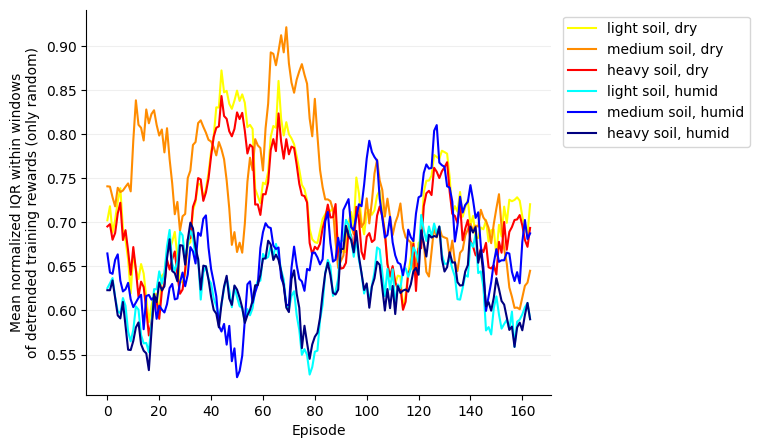

In [297]:
color_dict = {
    "light soil, humid":"cyan",
    "medium soil, humid":"blue",
    "heavy soil, humid":"navy",
    "light soil, dry":"yellow",
    "medium soil, dry":"darkorange",
    "heavy soil, dry":"red"
}

gt_dict = {
    -1.0:"light soil",
    0.0:"medium soil",
    1.0:"heavy soil"
}
drywet_dict = {
    0.0:"dry",
    1.0:"humid"
}

folder_name = "sac_symbolic_soil_conditions"
data_key_tuple = ("sac_symbolic","mbrl")
ground_types = [-1.0,0.0,1.0]
drywets = [0.0,1.0]

folder_name = "only_random_soil_conditions"
data_key_tuple = "only_random"
ground_types = [-1.0,0.0,1.0]
drywets = [0.0,1.0]

def plot_results_of_different_soil_conditions(seeds, ground_types, drywets, data_key_tuple, window_length, folder_name = None):
    partial_calculate_iqr_across_time_window = partial(calculate_iqr_across_time_window, window_length=window_length)
    results_dict = {}
    soil_dw_tuples = []
    for drywet in drywets:
        for ground_type in ground_types:
                soil_dw_tuple = f"{gt_dict[ground_type]}, {drywet_dict[drywet]}"
                soil_dw_tuples.append(soil_dw_tuple)
                results_dict[soil_dw_tuple] = {}
                rewards_across_runs = np.empty((0,180))
                cumulative_rewards_across_runs = np.empty((0,180))
                diffs_during_runs = np.empty((0,179))
                q95s = []
                for seed in seeds:
                    if data_key_tuple == "only_random":
                        path = f"experiments/evaluations/results/only_random_{ground_type}_{drywet}_{seed}.pickle"
                    elif data_key_tuple == "only_filtered":
                        path = f"experiments/evaluations/results/symbolic_only_filter_{ground_type}_{drywet}_{seed}.pickle"
                    else:
                        path = f"experiments/evaluations/results/{data_key_tuple[0]}_{data_key_tuple[1]}_{ground_type}_{drywet}_{seed}.pickle"
                    with open(path,"rb") as f:
                        result = pickle.load(f)
                    rewards = result["training_rewards"]
                    diff_rewards = np.diff(rewards)
                    cumulative_rewards = result["cumulative_training_rewards"]
                    rewards_across_runs = np.vstack((rewards_across_runs,rewards))
                    cumulative_rewards_across_runs = np.vstack((cumulative_rewards_across_runs,cumulative_rewards))
                    diffs_during_runs = np.vstack((diffs_during_runs,diff_rewards))
                    q95 = np.quantile(rewards,0.95)
                    q95s.append(q95)
                q95_mean = np.mean(q95s)
                mean_rewards_across_runs = np.mean(rewards_across_runs,axis=0)
                mean_cumulative_rewards_across_runs = np.mean(cumulative_rewards_across_runs,axis=0)
                cumulative_rewards_last_entry = cumulative_rewards_across_runs[:,-1].flatten()
                cumulative_lower_30_quantile = np.quantile(cumulative_rewards_last_entry,0.3)
                lowest_30_percent_cumulative_rewards = cumulative_rewards_across_runs[cumulative_rewards_last_entry <= cumulative_lower_30_quantile]
                results_dict[soil_dw_tuple]["mean_rewards"] = mean_rewards_across_runs
                results_dict[soil_dw_tuple]["mean_cumulative_rewards"] = mean_cumulative_rewards_across_runs
                results_dict[soil_dw_tuple]["cvar_cumulative_rewards"] = np.mean(lowest_30_percent_cumulative_rewards, axis=0)
                iqr_across_runs = calculate_lpf_iqr(rewards_across_runs, omega_c, T)
                results_dict[soil_dw_tuple]["iqr_across_runs"] = iqr_across_runs
                results_dict[soil_dw_tuple]["iqr_across_runs_normalized"] = iqr_across_runs/q95_mean
                iqrs_during_runs = np.apply_along_axis(partial_calculate_iqr_across_time_window,axis=1,arr=diffs_during_runs)
                mean_iqrs_during_runs = np.mean(iqrs_during_runs,axis=0)
                results_dict[soil_dw_tuple]["mean_iqrs_during_runs"] = mean_iqrs_during_runs
                results_dict[soil_dw_tuple]["mean_iqrs_during_runs_normalized"] = mean_iqrs_during_runs/q95_mean


    if folder_name is not None:
        general_path = f"plots/{folder_name}"
        if not os.path.exists(general_path):
            os.makedirs(general_path)

    def plot_results_per_key(key, ylabel, ymax = None):
        # Plot mean rewards
        plt.figure(figsize=(6,5))
        for soil_dw_tuple in soil_dw_tuples:
            plt.plot(results_dict[soil_dw_tuple][key],label=soil_dw_tuple, alpha=1.0, color=color_dict[soil_dw_tuple])
        plt.grid(axis="y", alpha=0.2)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.xlabel("Episode")
        plt.ylabel(ylabel)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        if ymax:
            plt.ylim(top=ymax)
        if folder_name is not None:
            image_path = f"{general_path}/{key}.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{key}.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()

    plot_results_per_key("mean_rewards", "Mean training rewards across runs (only random)")
    plot_results_per_key("mean_cumulative_rewards", "Mean cumulative training rewards across runs\n(only random)")
    plot_results_per_key("cvar_cumulative_rewards", "30% CVaR of cumulative training rewards across runs\n(only random)")
    plot_results_per_key("iqr_across_runs", "Normalized low-pass filtered IQR of training rewards\n(only random)")
    plot_results_per_key("iqr_across_runs_normalized", "Normalized low-pass filtered IQR of training rewards\n(only random)")
    plot_results_per_key("mean_iqrs_during_runs", "Mean IQR within windows\nof detrended training rewards (only random)")
    plot_results_per_key("mean_iqrs_during_runs_normalized", "Mean normalized IQR within windows\nof detrended training rewards (only random)")
    
plot_results_of_different_soil_conditions(SEEDS, ground_types = ground_types,drywets = drywets, data_key_tuple = data_key_tuple, window_length = 15, folder_name = folder_name)

# Pretraining comparison

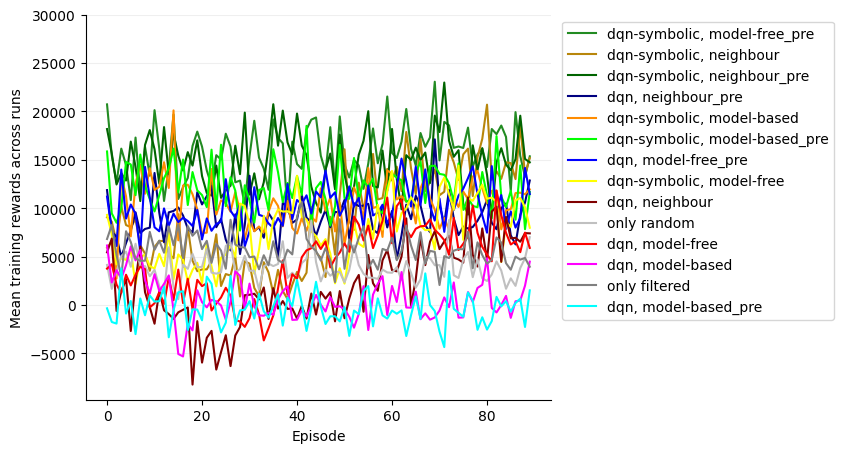

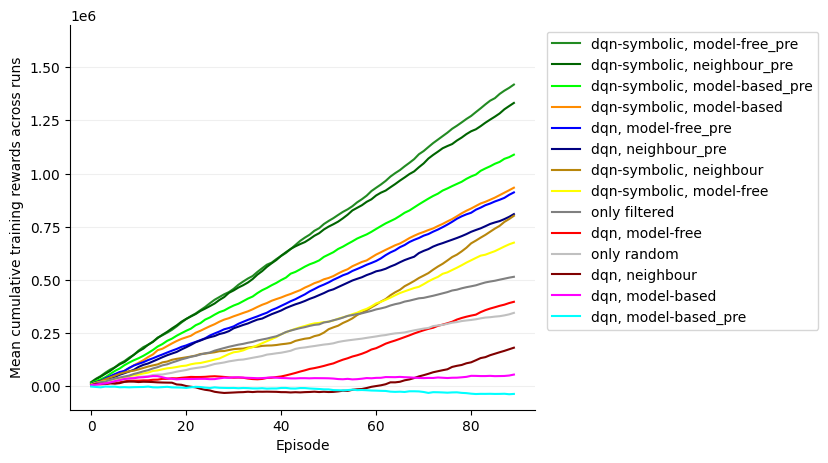

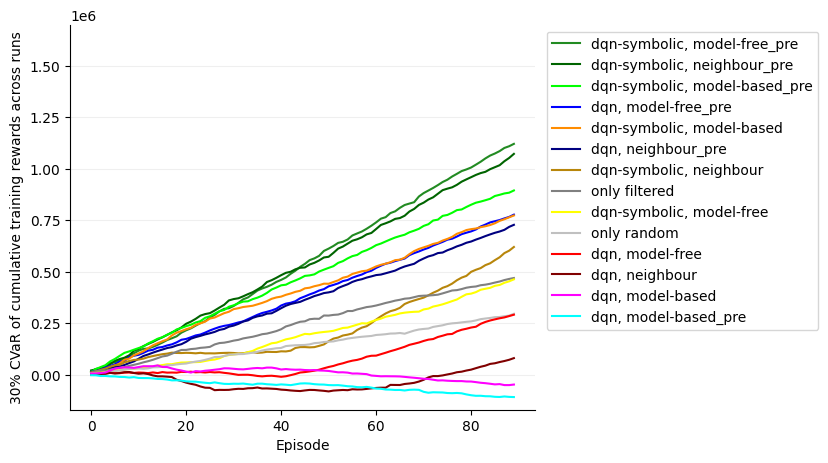

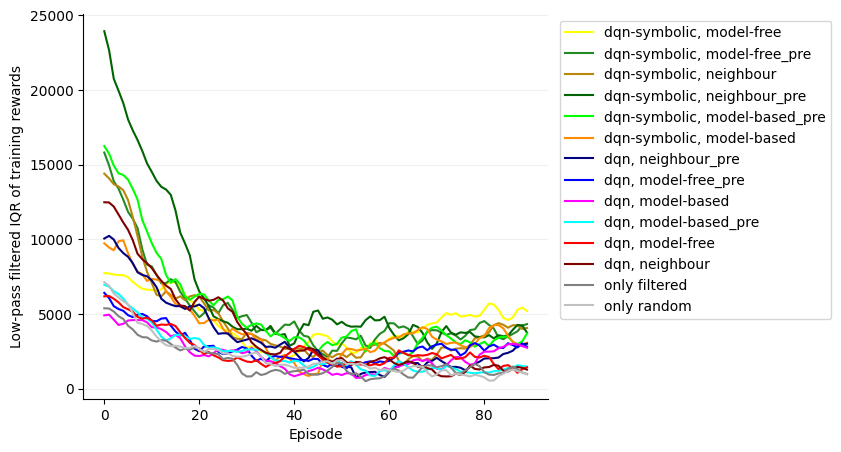

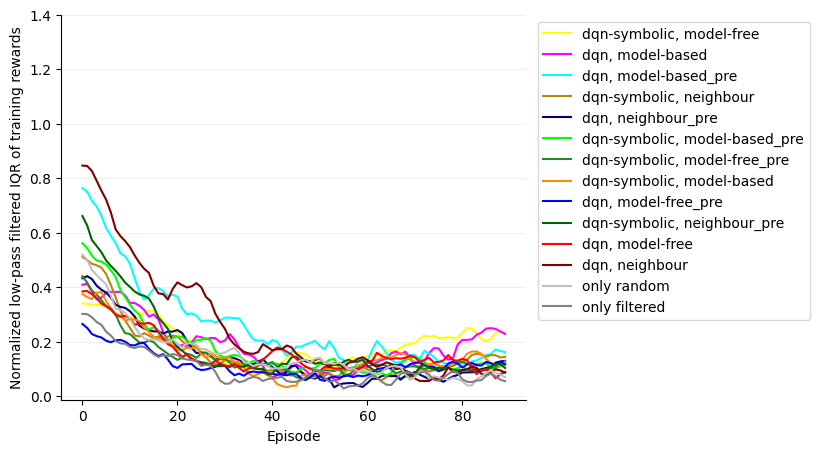

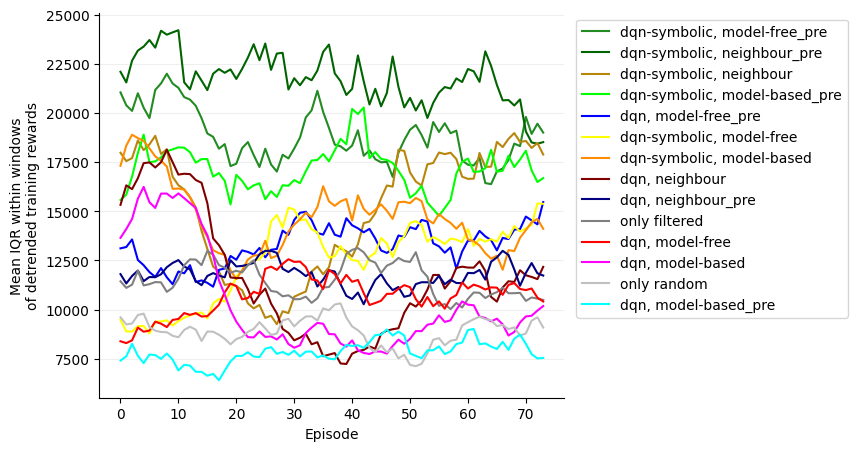

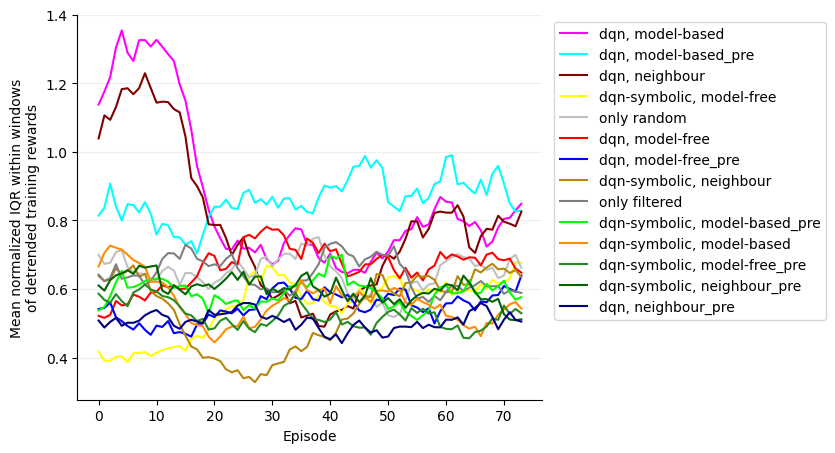

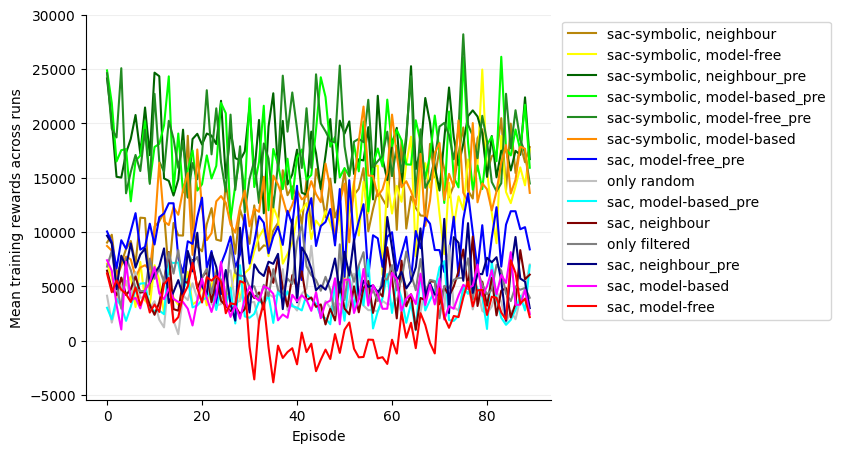

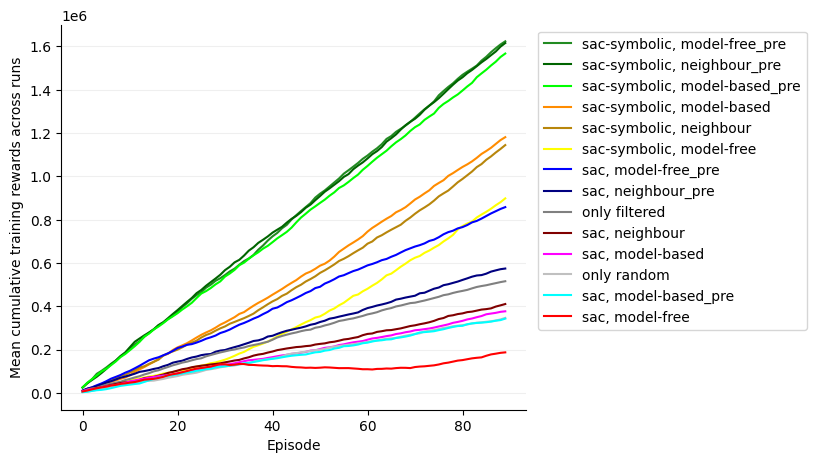

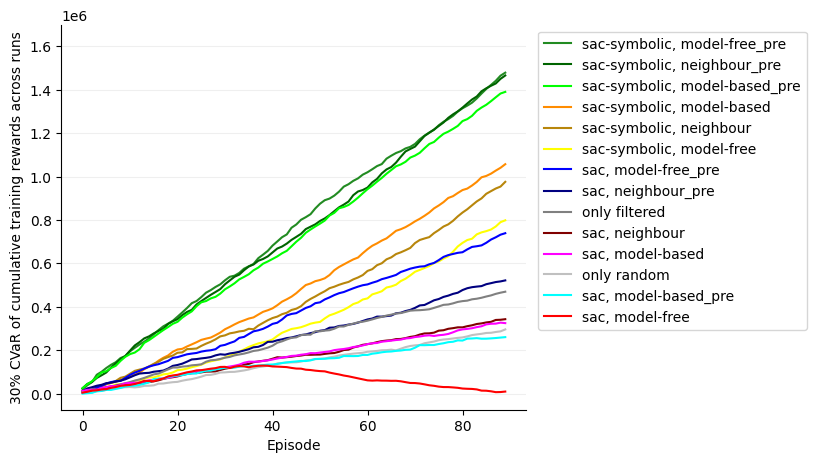

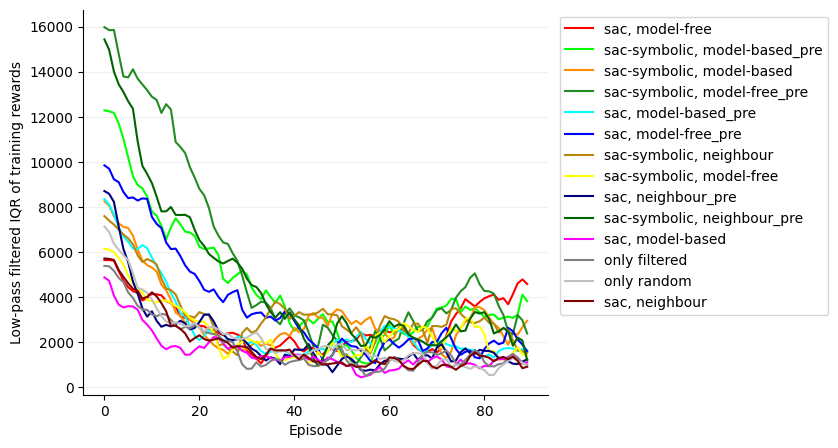

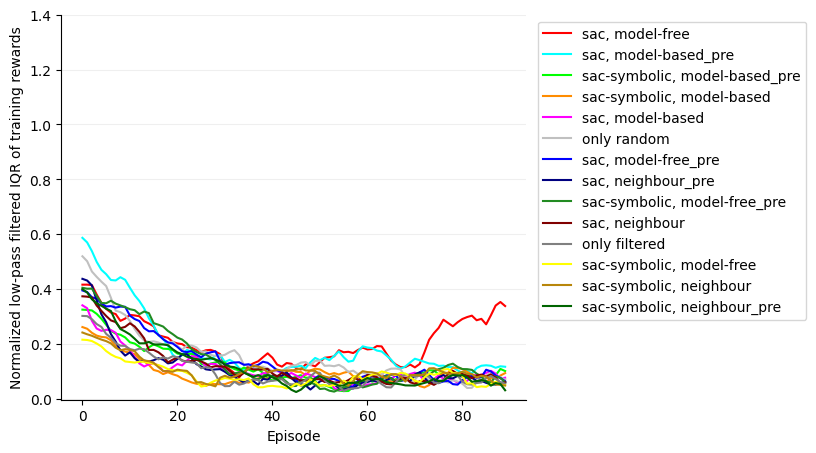

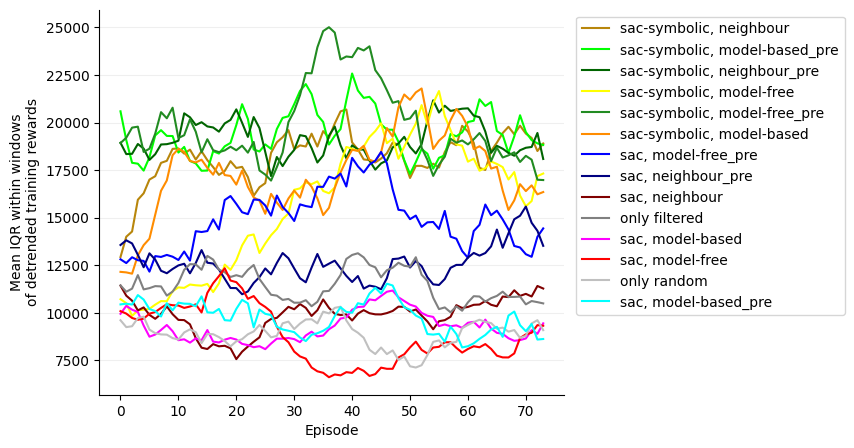

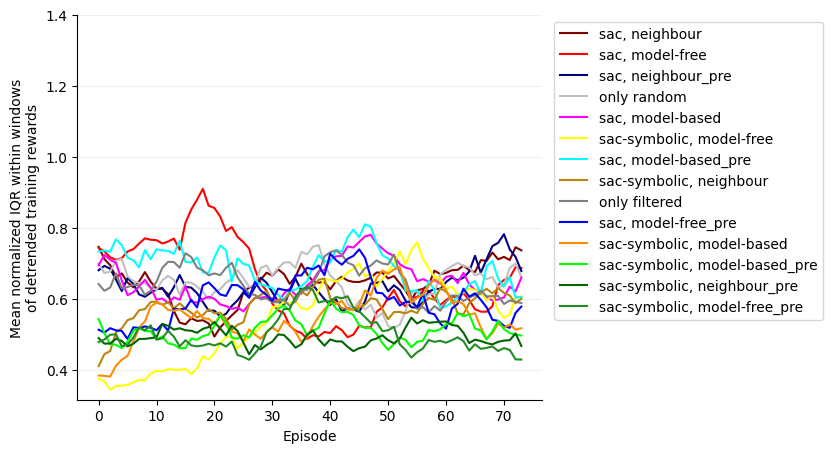

In [68]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial

omega_c = 0.01
T = 5

SEEDS = [101,102,103,104,105]
AGENT_TYPES = ["prioritized","sac","prioritized_symbolic","sac_symbolic"]
MBRL_KEYS = ["non-mbrl","mbrl","neighbour"]

legend_dict = {
    "prioritized":"dqn",
    "sac":"sac",
    "prioritized_symbolic":"dqn-symbolic",
    "sac_symbolic":"sac-symbolic",
    "non-mbrl":"model-free",
    "neighbour":"neighbour",
    "mbrl":"model-based"
}

legend_dict_reverse = {
    "dqn":"prioritized",
    "sac":"sac",
    "dqn-symbolic":"prioritized_symbolic",
    "sac-symbolic":"sac_symbolic",
    "model-free":"non-mbrl",
    "neighbour":"neighbour",
    "model-based":"mbrl"
}
color_dict = {
    "dqn, model-free":"red",
    "sac, model-free":"blue",
    "dqn-symbolic, model-free":"yellow",
    "sac-symbolic, model-free":"forestgreen",
    "dqn, neighbour":"maroon",
    "sac, neighbour":"navy",
    "dqn-symbolic, neighbour":"darkgoldenrod",
    "sac-symbolic, neighbour":"darkgreen",
    "dqn, model-based":"magenta",
    "sac, model-based":"cyan",
    "dqn-symbolic, model-based":"darkorange",
    "sac-symbolic, model-based":"lime",
    "only filtered":"grey",
    "only random":"silver"
}

color_dict_pretrained = {
    "pretrained":{
        "dqn, model-free":"blue",
        "sac, model-free":"blue",
        "dqn-symbolic, model-free":"forestgreen",
        "sac-symbolic, model-free":"forestgreen",
        "dqn, neighbour":"navy",
        "sac, neighbour":"navy",
        "dqn-symbolic, neighbour":"darkgreen",
        "sac-symbolic, neighbour":"darkgreen",
        "dqn, model-based":"cyan",
        "sac, model-based":"cyan",
        "dqn-symbolic, model-based":"lime",
        "sac-symbolic, model-based":"lime",
        "only filtered":"grey",
        "only random":"silver"
    },
    "base":{
        "dqn, model-free":"red",
        "sac, model-free":"red",
        "dqn-symbolic, model-free":"yellow",
        "sac-symbolic, model-free":"yellow",
        "dqn, neighbour":"maroon",
        "sac, neighbour":"maroon",
        "dqn-symbolic, neighbour":"darkgoldenrod",
        "sac-symbolic, neighbour":"darkgoldenrod",
        "dqn, model-based":"magenta",
        "sac, model-based":"magenta",
        "dqn-symbolic, model-based":"darkorange",
        "sac-symbolic, model-based":"darkorange",
        "only filtered":"grey",
        "only random":"silver"
    }

}


def generate_path_for_pretrained_results(plot_tuple, seed, test_seed):
    data_key_tuple = (legend_dict_reverse[plot_tuple.split(", ")[0]],legend_dict_reverse[plot_tuple.split(", ")[1]])
    path = f"experiments/evaluations/pretraining_results/{data_key_tuple[0]}_{data_key_tuple[1]}_{seed}_{test_seed}.pickle"
    return path
    




def plot_pretrained_results(seeds, data_key_tuples, window_length, folder_name = None, compare_flag = "pretrained"):
    ground_type = 0.0
    drywet = 1.0
    if compare_flag == "only_pretrained" or compare_flag == "both":
        n_episodes = 90
    else:
        n_episodes = 180
    partial_calculate_iqr_across_time_window = partial(calculate_iqr_across_time_window, window_length=window_length)
    plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    results_dict = {
        "pretrained":{},
        "base":{}
    }
    if compare_flag == "both":
        keys = ["pretrained","base"]
    else:
        keys = ["pretrained"]
    for intended_key in keys:
        for plot_tuple in plot_tuples:
            if intended_key == "pretrained":
                if plot_tuple in ["only filtered","only random"]:
                    key = "base"
                else:
                    key = "pretrained"
            else:
                if plot_tuple in ["only filtered","only random"]:
                    continue
                else:
                    key = "base"

            results_dict[key][plot_tuple] = {}
            rewards_across_runs = np.empty((0,n_episodes))
            cumulative_rewards_across_runs = np.empty((0,n_episodes))
            diffs_during_runs = np.empty((0,n_episodes-1))
            q95s = []
            for seed in seeds:
                test_seeds = [seed+5,seed+10,seed+15]
                for test_seed in test_seeds:
                    if key == "base":
                        path = generate_path_for_results(plot_tuple, ground_type, drywet, test_seed)
                    else:
                        path = generate_path_for_pretrained_results(plot_tuple, seed, test_seed)
                    with open(path,"rb") as f:
                        result = pickle.load(f)
                    rewards = result["training_rewards"][:n_episodes]
                    diff_rewards = np.diff(rewards)
                    cumulative_rewards = result["cumulative_training_rewards"][:n_episodes]
                    rewards_across_runs = np.vstack((rewards_across_runs,rewards))
                    cumulative_rewards_across_runs = np.vstack((cumulative_rewards_across_runs,cumulative_rewards))
                    diffs_during_runs = np.vstack((diffs_during_runs,diff_rewards))
                    q95 = np.quantile(rewards,0.95)
                    q95s.append(q95)
            q95_mean = np.mean(q95s)
            mean_rewards_across_runs = np.mean(rewards_across_runs,axis=0)
            mean_cumulative_rewards_across_runs = np.mean(cumulative_rewards_across_runs,axis=0)
            cumulative_rewards_last_entry = cumulative_rewards_across_runs[:,-1].flatten()
            cumulative_lower_30_quantile = np.quantile(cumulative_rewards_last_entry,0.3)
            lowest_30_percent_cumulative_rewards = cumulative_rewards_across_runs[cumulative_rewards_last_entry <= cumulative_lower_30_quantile]
            results_dict[key][plot_tuple]["mean_rewards"] = mean_rewards_across_runs
            results_dict[key][plot_tuple]["mean_cumulative_rewards"] = mean_cumulative_rewards_across_runs
            results_dict[key][plot_tuple]["cvar_cumulative_rewards"] = np.mean(lowest_30_percent_cumulative_rewards, axis=0)
            iqr_across_runs = calculate_lpf_iqr(rewards_across_runs, omega_c, T)
            results_dict[key][plot_tuple]["iqr_across_runs"] = iqr_across_runs
            results_dict[key][plot_tuple]["iqr_across_runs_normalized"] = iqr_across_runs/q95_mean
            iqrs_during_runs = np.apply_along_axis(partial_calculate_iqr_across_time_window,axis=1,arr=diffs_during_runs)
            mean_iqrs_during_runs = np.mean(iqrs_during_runs,axis=0)
            results_dict[key][plot_tuple]["mean_iqrs_during_runs"] = mean_iqrs_during_runs
            results_dict[key][plot_tuple]["mean_iqrs_during_runs_normalized"] = mean_iqrs_during_runs/q95_mean           
            
    if folder_name is not None:
        general_path = f"plots/{folder_name}"
        if not os.path.exists(general_path):
            os.makedirs(general_path)

    def plot_results_per_key(key,ylabel,ymax=None):
        # Plot mean rewards
        plt.figure(figsize=(6,5))
        plot_tuple_tuples_unsorted = []
        plot_tuple_tuples_sorted = []
        if key == "mean_cumulative_rewards" or "cvar_cumulative_rewards":
            for plot_tuple in plot_tuples:
                if compare_flag == "both":
                    if plot_tuple not in ["only filtered","only random"]:
                        plot_tuple_tuples_unsorted.append((results_dict["pretrained"][plot_tuple][key],plot_tuple, "pretrained"))
                    plot_tuple_tuples_unsorted.append((results_dict["base"][plot_tuple][key],plot_tuple, "base"))
                else:
                    if plot_tuple not in ["only filtered","only random"]:
                        plot_tuple_tuples_unsorted.append((results_dict["pretrained"][plot_tuple][key],plot_tuple, "pretrained"))
                    else:
                        plot_tuple_tuples_unsorted.append((results_dict["base"][plot_tuple][key],plot_tuple, "base"))  
            plot_tuple_tuples_sorted = sorted(plot_tuple_tuples_unsorted, key=lambda x: x[0][-1], reverse=True)
            for plot_tuple_tuple in plot_tuple_tuples_sorted:
                if plot_tuple_tuple[2] == "pretrained":
                    plt.plot(plot_tuple_tuple[0],label=plot_tuple_tuple[1]+"_pre", alpha=1.0, color=color_dict_pretrained["pretrained"][plot_tuple_tuple[1]])
                else:
                    plt.plot(plot_tuple_tuple[0],label=plot_tuple_tuple[1], alpha=1.0, color=color_dict_pretrained["base"][plot_tuple_tuple[1]])

        else:
            for plot_tuple in plot_tuples:
                if compare_flag == "both":
                    if plot_tuple not in ["only filtered","only random"]:
                        plt.plot(results_dict["pretrained"][plot_tuple][key],label=plot_tuple+", pre", alpha=1.0, color=color_dict_pretrained["pretrained"][plot_tuple])
                    
                    plt.plot(results_dict["base"][plot_tuple][key],label=plot_tuple, alpha=1.0, color=color_dict_pretrained["base"][plot_tuple])
                else:
                    if plot_tuple not in ["only filtered","only random"]:
                        plt.plot(results_dict["pretrained"][plot_tuple][key],label=plot_tuple+", pre", alpha=1.0, color=color_dict[plot_tuple])
                    else:
                        plt.plot(results_dict["base"][plot_tuple][key],label=plot_tuple, alpha=1.0, color=color_dict[plot_tuple])    
        plt.grid(axis="y", alpha=0.2)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.xlabel("Episode")
        plt.ylabel(ylabel)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        if ymax:
            plt.ylim(top=ymax)
        if folder_name is not None:
            image_path = f"{general_path}/{key}.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{key}.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()

    key = "mean_rewards"
    ylabel = "Mean training rewards across runs"
    plot_results_per_key(key,ylabel, ymax=30000)

    key = "mean_cumulative_rewards"
    ylabel = "Mean cumulative training rewards across runs"
    plot_results_per_key(key,ylabel, ymax=1.7e6)

    key = "cvar_cumulative_rewards"
    ylabel = "30% CVaR of cumulative training rewards across runs"
    plot_results_per_key(key,ylabel, ymax=1.7e6)

    key = "iqr_across_runs"
    ylabel = "Low-pass filtered IQR of training rewards"
    plot_results_per_key(key,ylabel)

    key = "iqr_across_runs_normalized"
    ylabel = "Normalized low-pass filtered IQR of training rewards"
    plot_results_per_key(key,ylabel, ymax=1.4)

    key = "mean_iqrs_during_runs"
    ylabel = "Mean IQR within windows\nof detrended training rewards"
    plot_results_per_key(key,ylabel)

    key = "mean_iqrs_during_runs_normalized"
    ylabel = "Mean normalized IQR within windows\nof detrended training rewards"
    plot_results_per_key(key,ylabel, ymax=1.4)



# folder_name = "dqn_non-symbolic_compare-pt_baseline"
# agent_type = "prioritized"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl")]
# plot_pretrained_results(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, compare_flag = "both")

# folder_name = "sac_non-symbolic_compare-pt_baseline"
# agent_type = "sac"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl")]
# plot_pretrained_results(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, compare_flag = "both")



# folder_name = "dqn_symbolic_compare-pt_baseline"
# agent_type = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl")]
# plot_pretrained_results(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, compare_flag = "both")

folder_name = "dqn_all_compare-pt_baseline"
agent_type = "prioritized"
agent_type2 = "prioritized_symbolic"
data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
plot_pretrained_results(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, compare_flag = "both")

folder_name = "sac_all_compare-pt_baseline"
agent_type = "sac"
agent_type2 = "sac_symbolic"
data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
plot_pretrained_results(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, compare_flag = "both")

# 1000ep plots

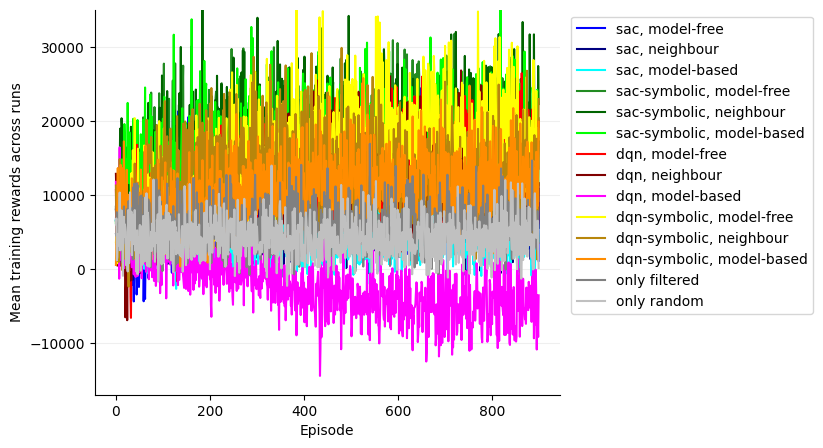

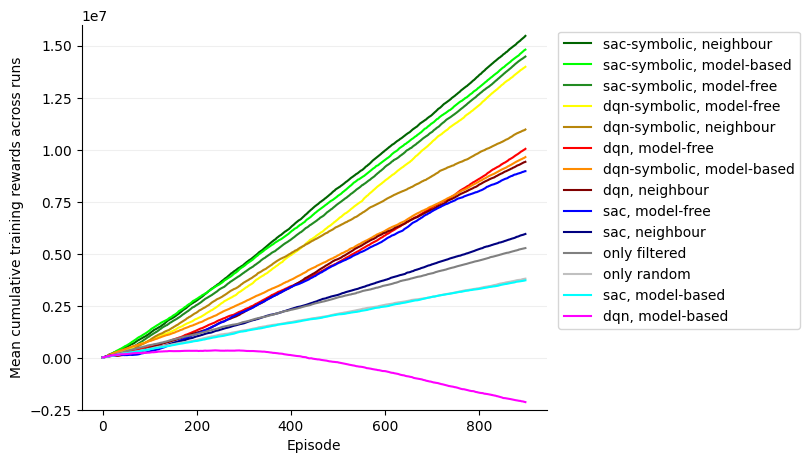

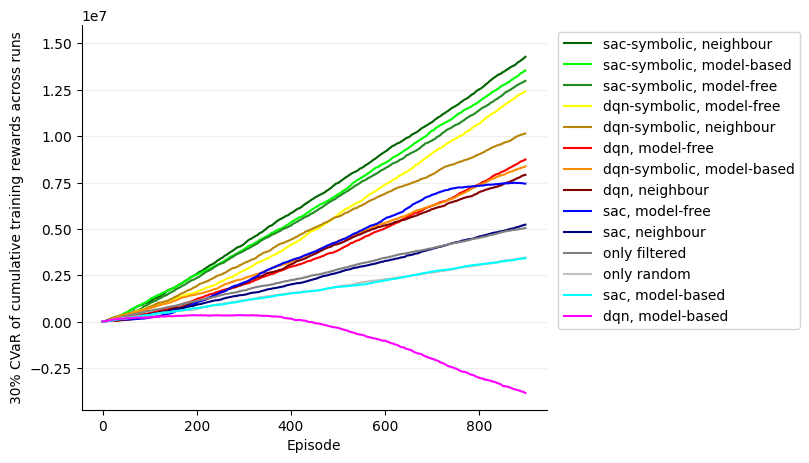

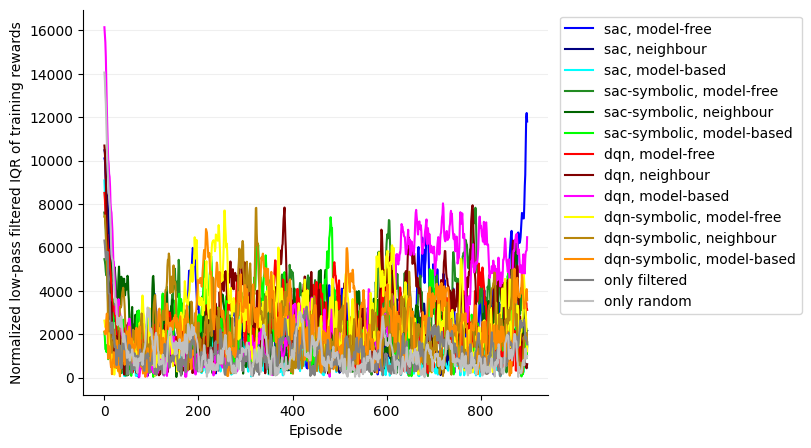

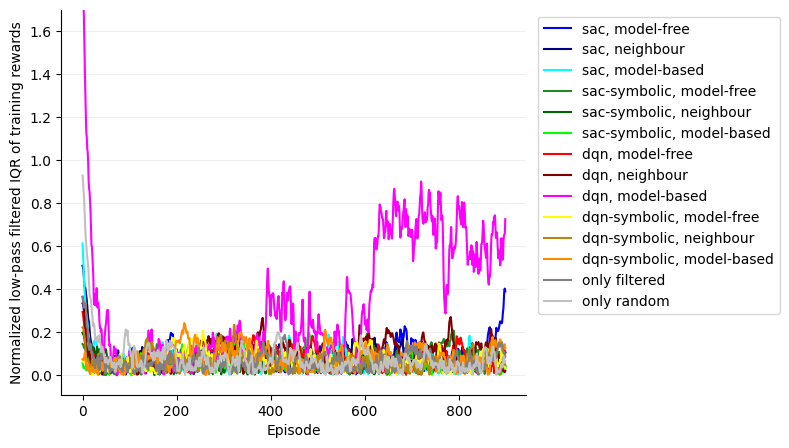

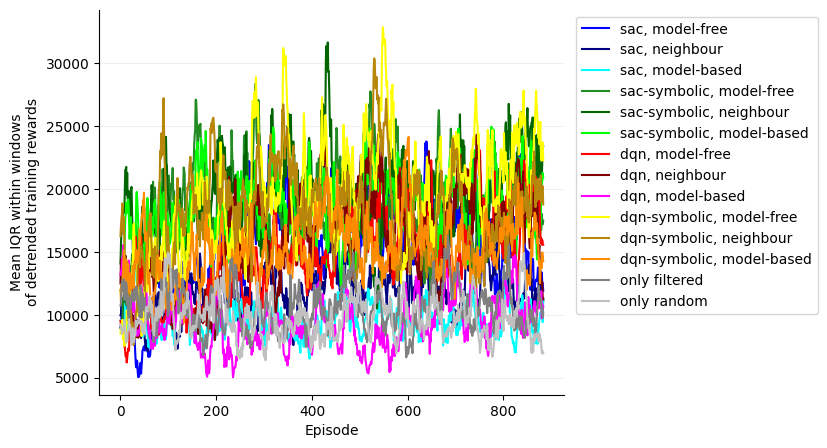

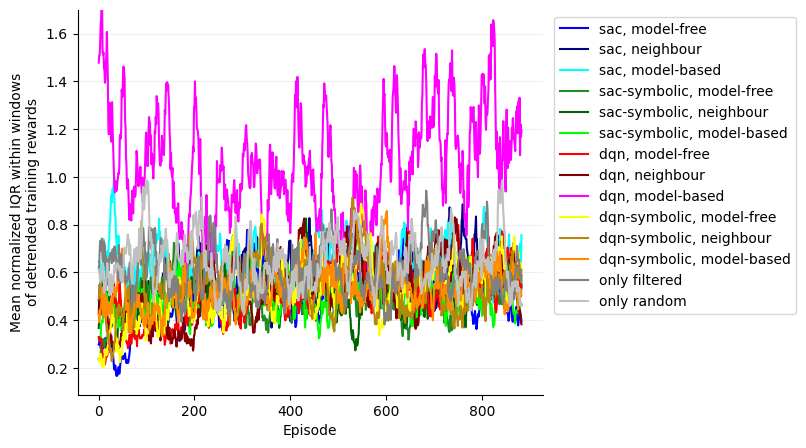

In [79]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
omega_c = 0.01
T = 5

SEEDS = [101,102,103,104,105]
AGENT_TYPES = ["prioritized","sac","prioritized_symbolic","sac_symbolic"]
MBRL_KEYS = ["non-mbrl","mbrl","neighbour"]
GROUND_TYPES = [-1.0,0.0,1.0]
DRYWETS = [0.0,1.0]
data_type = "cumulative_training_rewards"

# mbrl_key = "non-mbrl"
# mbrl_key = "neighbour"
mbrl_key = "mbrl"

legend_dict = {
    "prioritized":"dqn",
    "sac":"sac",
    "prioritized_symbolic":"dqn-symbolic",
    "sac_symbolic":"sac-symbolic",
    "non-mbrl":"model-free",
    "neighbour":"neighbour",
    "mbrl":"model-based"
}

legend_dict_reverse = {
    "dqn":"prioritized",
    "sac":"sac",
    "dqn-symbolic":"prioritized_symbolic",
    "sac-symbolic":"sac_symbolic",
    "model-free":"non-mbrl",
    "neighbour":"neighbour",
    "model-based":"mbrl"
}

color_dict = {
    "dqn, model-free":"red",
    "sac, model-free":"blue",
    "dqn-symbolic, model-free":"yellow",
    "sac-symbolic, model-free":"forestgreen",
    "dqn, neighbour":"maroon",
    "sac, neighbour":"navy",
    "dqn-symbolic, neighbour":"darkgoldenrod",
    "sac-symbolic, neighbour":"darkgreen",
    "dqn, model-based":"magenta",
    "sac, model-based":"cyan",
    "dqn-symbolic, model-based":"darkorange",
    "sac-symbolic, model-based":"lime",
    "only filtered":"grey",
    "only random":"silver"
}


def generate_path_for_results_1000(plot_tuple,ground_type, drywet, seed):
    if plot_tuple == "only filtered":
        path = f"experiments/evaluations/results/symbolic_only_filter_{ground_type}_{drywet}_{seed}_1000ep.pickle"
        return path
    elif plot_tuple == "only random":
        path = f"experiments/evaluations/results/only_random_{ground_type}_{drywet}_{seed}_1000ep.pickle"
        return path
    else:
        data_key_tuple = (legend_dict_reverse[plot_tuple.split(", ")[0]],legend_dict_reverse[plot_tuple.split(", ")[1]])
        path = f"experiments/evaluations/results/{data_key_tuple[0]}_{data_key_tuple[1]}_{ground_type}_{drywet}_{seed}_1000ep.pickle"
        return path
    




def plot_results_1000(seeds, data_key_tuples, window_length, folder_name = None):
    ground_type = 0.0
    drywet = 1.0
    partial_calculate_iqr_across_time_window = partial(calculate_iqr_across_time_window, window_length=window_length)
    plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    results_dict = {}
    for plot_tuple in plot_tuples:
        results_dict[plot_tuple] = {}
        rewards_across_runs = np.empty((0,900))
        cumulative_rewards_across_runs = np.empty((0,900))
        diffs_during_runs = np.empty((0,899))
        q95s = []
        for seed in seeds:
            path = generate_path_for_results_1000(plot_tuple, ground_type, drywet, seed)
            with open(path,"rb") as f:
                result = pickle.load(f)
            rewards = result["training_rewards"]
            diff_rewards = np.diff(rewards)
            cumulative_rewards = result["cumulative_training_rewards"]
            rewards_across_runs = np.vstack((rewards_across_runs,rewards))
            cumulative_rewards_across_runs = np.vstack((cumulative_rewards_across_runs,cumulative_rewards))
            diffs_during_runs = np.vstack((diffs_during_runs,diff_rewards))
            q95 = np.quantile(rewards,0.95)
            q95s.append(q95)
        q95_mean = np.mean(q95s)
        mean_rewards_across_runs = np.mean(rewards_across_runs,axis=0)
        mean_cumulative_rewards_across_runs = np.mean(cumulative_rewards_across_runs,axis=0)
        cumulative_rewards_last_entry = cumulative_rewards_across_runs[:,-1].flatten()
        cumulative_lower_30_quantile = np.quantile(cumulative_rewards_last_entry,0.3)
        lowest_30_percent_cumulative_rewards = cumulative_rewards_across_runs[cumulative_rewards_last_entry <= cumulative_lower_30_quantile]
        results_dict[plot_tuple]["mean_rewards"] = mean_rewards_across_runs
        results_dict[plot_tuple]["mean_cumulative_rewards"] = mean_cumulative_rewards_across_runs
        results_dict[plot_tuple]["cvar_cumulative_rewards"] = np.mean(lowest_30_percent_cumulative_rewards, axis=0)
        iqr_across_runs = calculate_lpf_iqr(rewards_across_runs, omega_c, T)
        results_dict[plot_tuple]["iqr_across_runs"] = iqr_across_runs
        results_dict[plot_tuple]["iqr_across_runs_normalized"] = iqr_across_runs/q95_mean
        iqrs_during_runs = np.apply_along_axis(partial_calculate_iqr_across_time_window,axis=1,arr=diffs_during_runs)
        mean_iqrs_during_runs = np.mean(iqrs_during_runs,axis=0)
        results_dict[plot_tuple]["mean_iqrs_during_runs"] = mean_iqrs_during_runs
        results_dict[plot_tuple]["mean_iqrs_during_runs_normalized"] = mean_iqrs_during_runs/q95_mean


    if folder_name is not None:
        general_path = f"plots/{folder_name}"
        if not os.path.exists(general_path):
            os.makedirs(general_path)


    def plot_results_per_key(key,ylabel,ymax=None, ymin = None):
        plt.figure(figsize=(6,5))
        plot_tuples_unsorted = []
        if key == "mean_cumulative_rewards" or key == "cvar_cumulative_rewards":
            for plot_tuple in plot_tuples:
                plot_tuples_unsorted.append((results_dict[plot_tuple][key][-1],plot_tuple))
            plot_tuples_sorted = sorted(plot_tuples_unsorted, key = lambda x: x[0], reverse=True)
            for t in plot_tuples_sorted:
                result, plot_tuple = t
                plt.plot(results_dict[plot_tuple][key],label=plot_tuple, alpha=1.0, color=color_dict[plot_tuple])
        else:
            for plot_tuple in plot_tuples:
                plt.plot(results_dict[plot_tuple][key],label=plot_tuple, alpha=1.0, color=color_dict[plot_tuple])
        plt.grid(axis="y", alpha=0.2)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.xlabel("Episode")
        plt.ylabel(ylabel)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        if ymax:
            plt.ylim(top=ymax)
        if ymin:
            plt.ylim(bottom=ymin)
        if folder_name is not None:
            image_path = f"{general_path}/{key}.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{key}.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()

    key = "mean_rewards"
    ylabel = "Mean training rewards across runs"
    plot_results_per_key(key,ylabel, ymax=35000)

    key = "mean_cumulative_rewards"
    ylabel = "Mean cumulative training rewards across runs"
    plot_results_per_key(key,ylabel, ymax = 1.6e7, ymin = -0.25e7)

    key = "cvar_cumulative_rewards"
    ylabel = "30% CVaR of cumulative training rewards across runs"
    plot_results_per_key(key,ylabel, ymax = 1.6e7)

    key = "iqr_across_runs"
    ylabel = "Normalized low-pass filtered IQR of training rewards"
    plot_results_per_key(key,ylabel)

    key = "iqr_across_runs_normalized"
    ylabel = "Normalized low-pass filtered IQR of training rewards"
    plot_results_per_key(key,ylabel, ymax = 1.7)

    key = "mean_iqrs_during_runs"
    ylabel = "Mean IQR within windows\nof detrended training rewards"
    plot_results_per_key(key,ylabel)

    key = "mean_iqrs_during_runs_normalized"
    ylabel = "Mean normalized IQR within windows\nof detrended training rewards"
    plot_results_per_key(key,ylabel, ymax = 1.7)




# folder_name = "all_non-symbolic_nopt_baseline_1000"
# agent_type = "sac"
# agent_type2 = "prioritized"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# plot_results_1000(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)

# folder_name = "all_symbolic_nopt_baseline_1000"
# agent_type = "sac_symbolic"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# plot_results_1000(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)

# folder_name = "dqn_all_nopt_baseline_1000"
# agent_type = "prioritized"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# plot_results_1000(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)

# folder_name = "sac_all_nopt_baseline_1000"
# agent_type = "sac"
# agent_type2 = "sac_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# plot_results_1000(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)


folder_name = "all_all_nopt_baseline_1000"
agent_type = "sac"
agent_type2 = "sac_symbolic"
agent_type3 = "prioritized"
agent_type4 = "prioritized_symbolic"
data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl"),(agent_type3,"non-mbrl"),(agent_type3,"neighbour"),(agent_type3,"mbrl"),(agent_type4,"non-mbrl"),(agent_type4,"neighbour"),(agent_type4,"mbrl")]
plot_results_1000(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name)

# Calculating bootstrap confidence intervals for all metrics

## Helpers

In [4]:
from scipy import stats
def calculate_lpf_raw(raw_data, omega_c, T):
    lpf_partial = partial(lpf, omega_c=omega_c, T=T)
    data_lpf = np.apply_along_axis(lpf_partial,1,raw_data)
    return data_lpf

def calculate_IQR_across_runs_from_LPF(raw_lpf_data):
    upper_quartile = np.quantile(raw_lpf_data,0.75,axis=0)
    lower_quartile = np.quantile(raw_lpf_data,0.25,axis=0)
    iqr = upper_quartile - lower_quartile
    return iqr

def permutation_test_mean(means1, means2, n_permutations):
    assert len(means1) == len(means2)
    n = len(means1)
    mean_diff = np.mean(means1) - np.mean(means2)
    all_means = np.concatenate((means1,means2))
    num_greater = 0
    for i in range(n_permutations):
        all_means_permuted = random.permutation(all_means)
        mean_diff_permuted = np.mean(all_means_permuted[:n]) - np.mean(all_means_permuted[n:])
        if mean_diff_permuted > mean_diff:
            num_greater += 1
    return num_greater/n_permutations

def permutation_test_normalized_iqrs(lpf_rewards1, lpf_rewards2, q95s1, q95s2, n_permutations):
    normalized_iqr_across_runs1 = calculate_IQR_across_runs_from_LPF(lpf_rewards1)/(q95s1.mean())
    normalized_iqr_across_runs2 = calculate_IQR_across_runs_from_LPF(lpf_rewards2)/(q95s2.mean())
    n = lpf_rewards1.shape[0]
    mean_diff = np.mean(normalized_iqr_across_runs1) - np.mean(normalized_iqr_across_runs2)
    concatenated_lpf_rewards = np.concatenate((lpf_rewards1,lpf_rewards2),axis=0)
    concatenated_q95s = np.concatenate((q95s1,q95s2))
    combined_length = concatenated_lpf_rewards.shape[0]
    unpermuted_idxs = np.arange(combined_length)
    num_greater = 0
    for i in range(n_permutations):
        permuted_idxs = random.permutation(unpermuted_idxs)
        permuted_lpf_rewards = concatenated_lpf_rewards[permuted_idxs]
        permuted_q95s = concatenated_q95s[permuted_idxs]
        permuted_lpf_rewards1 = calculate_IQR_across_runs_from_LPF(permuted_lpf_rewards[:n])
        permuted_lpf_rewards2 = calculate_IQR_across_runs_from_LPF(permuted_lpf_rewards[n:])
        normalized_permuted_lpf_rewards1 = permuted_lpf_rewards1/(permuted_q95s[:n].mean())
        normalized_permuted_lpf_rewards2 = permuted_lpf_rewards2/(permuted_q95s[n:].mean())
        mean_diff_permuted = np.mean(normalized_permuted_lpf_rewards1) - np.mean(normalized_permuted_lpf_rewards2)
        if mean_diff_permuted > mean_diff:
            num_greater += 1
    return num_greater/n_permutations

def calculate_entropy(crops_selected_idxs_list):
    crops_selected_idxs_array = np.array(flatten_comprehension(crops_selected_idxs_list))
    unique, counts = np.unique(crops_selected_idxs_array, return_counts=True)
    counts = counts/counts.sum()
    entropy = stats.entropy(counts)
    return entropy

def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

## Bootstrapped Standard results

100%|██████████| 50000/50000 [00:18<00:00, 2677.16it/s]


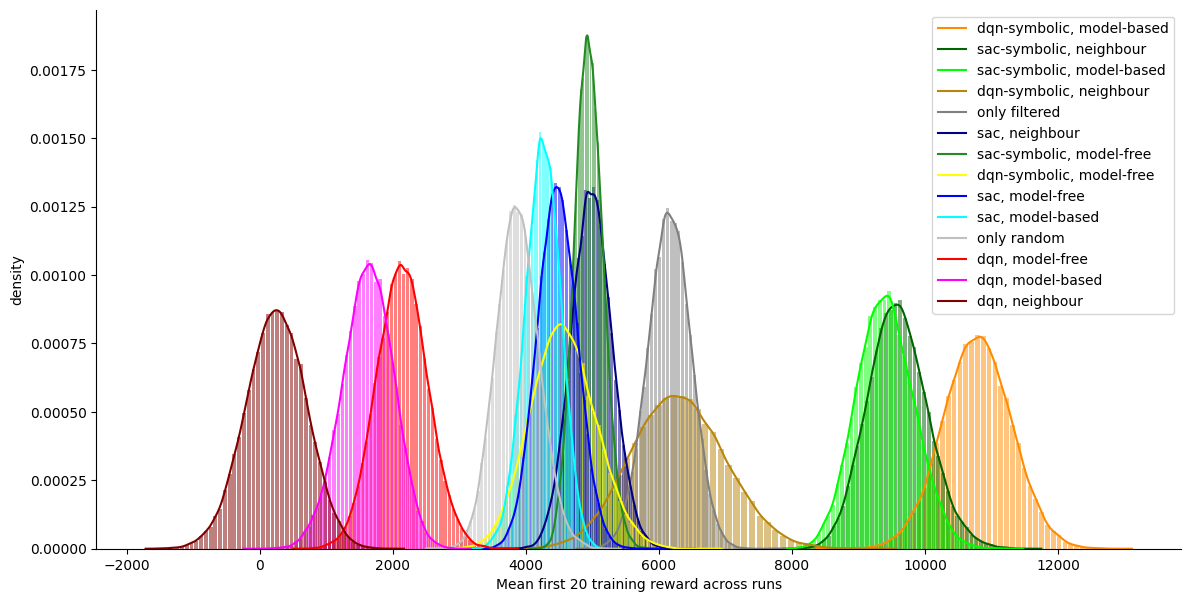

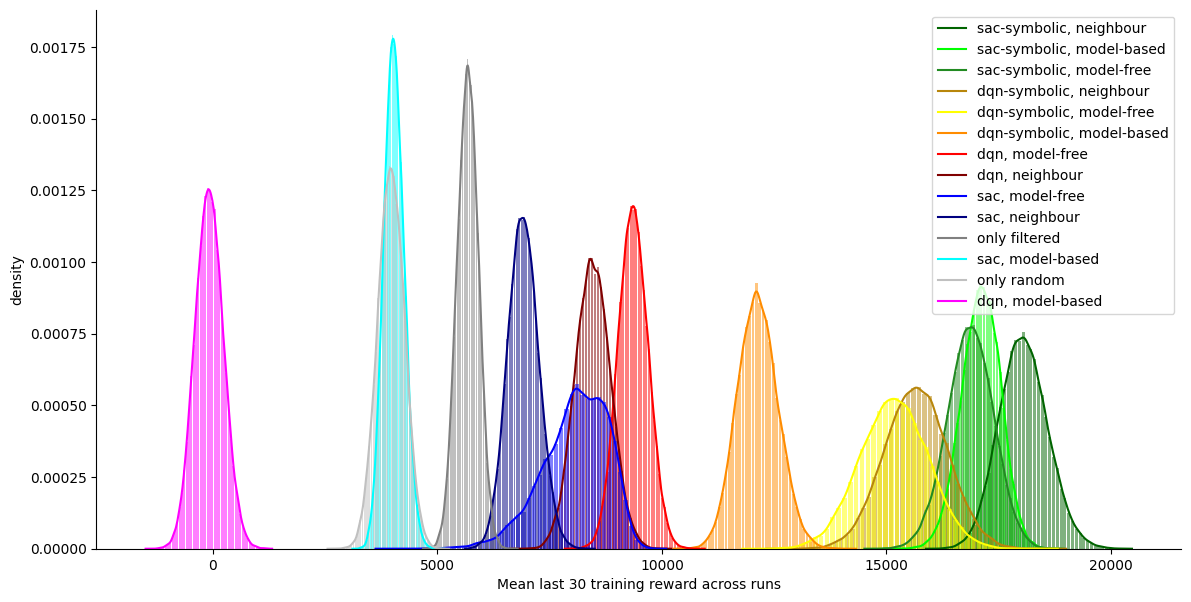

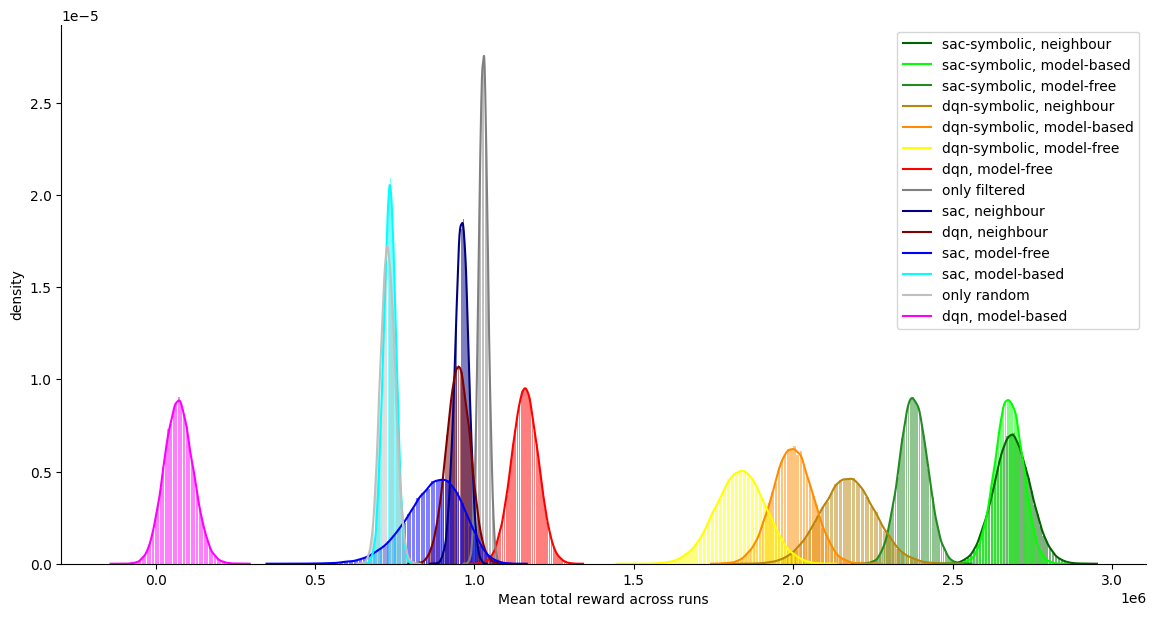

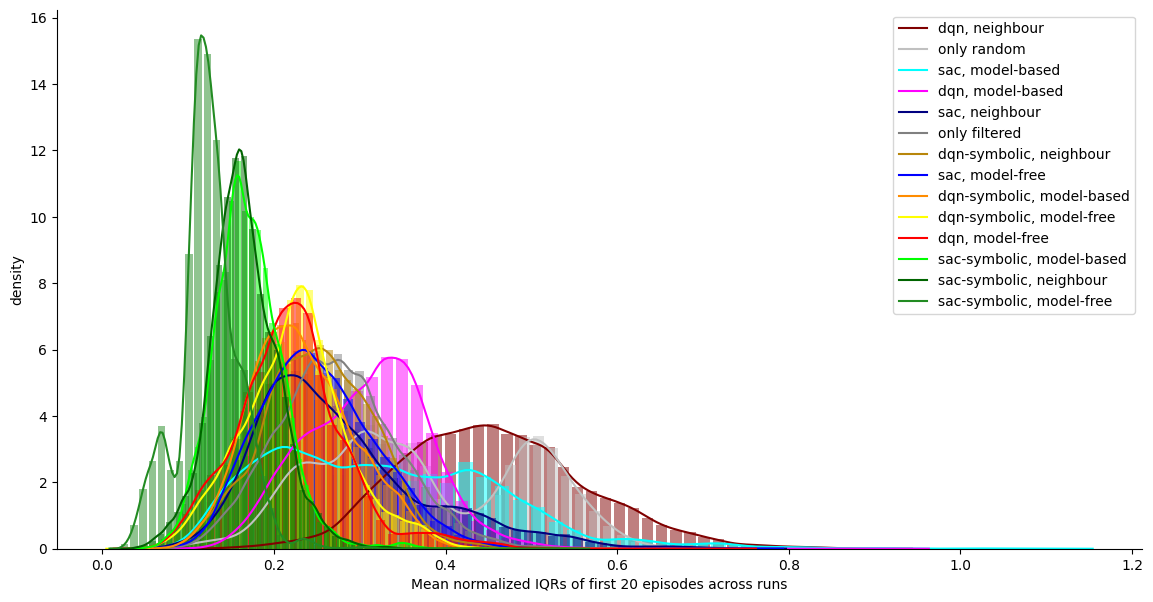

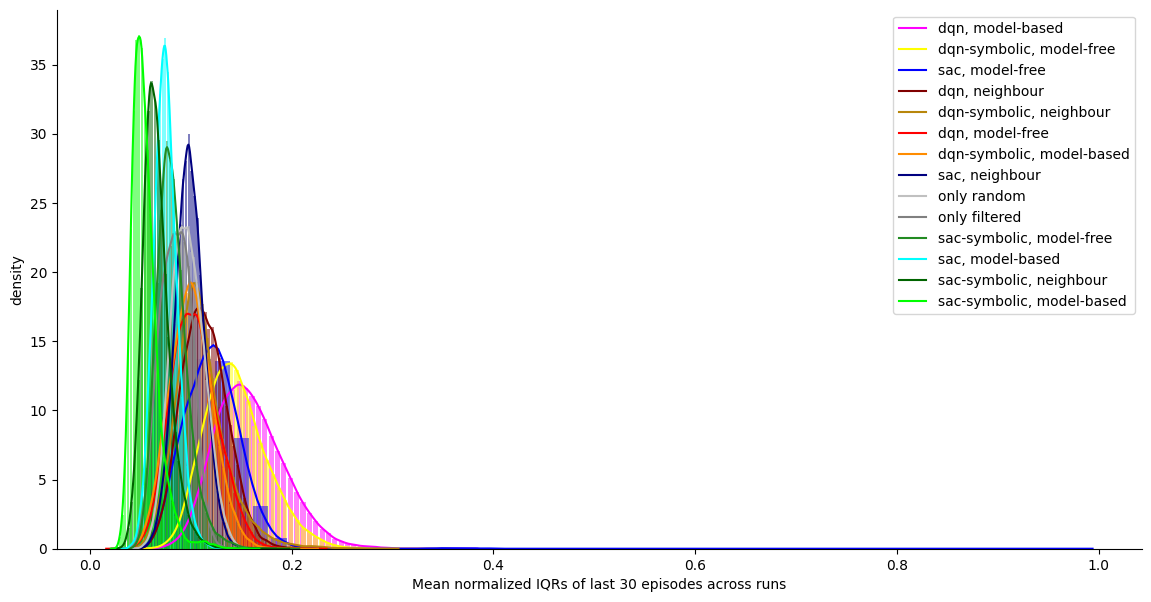

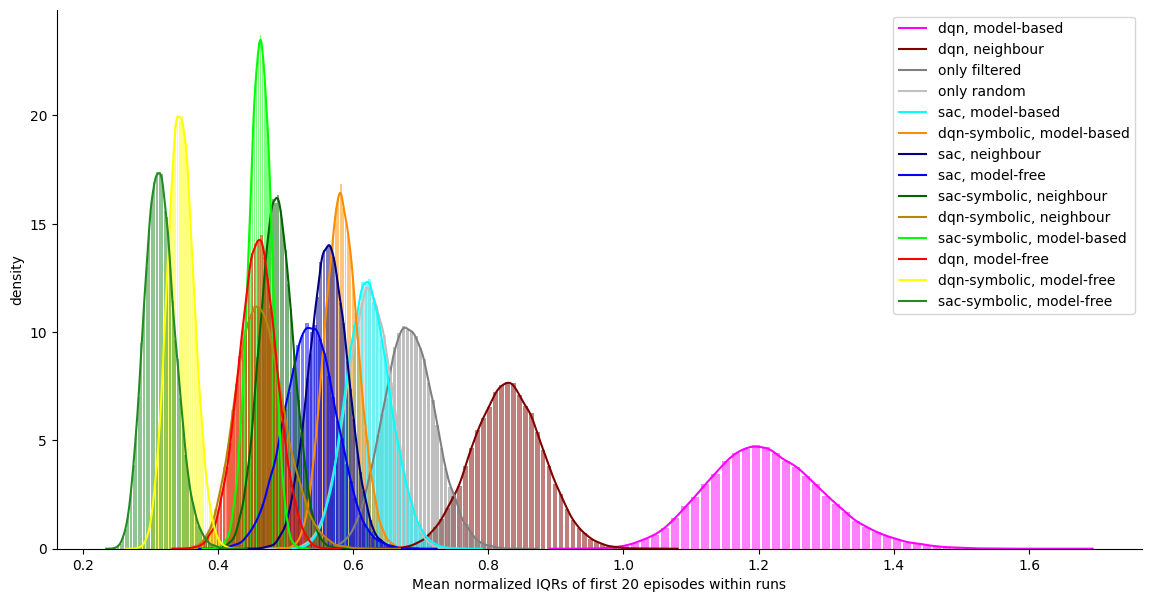

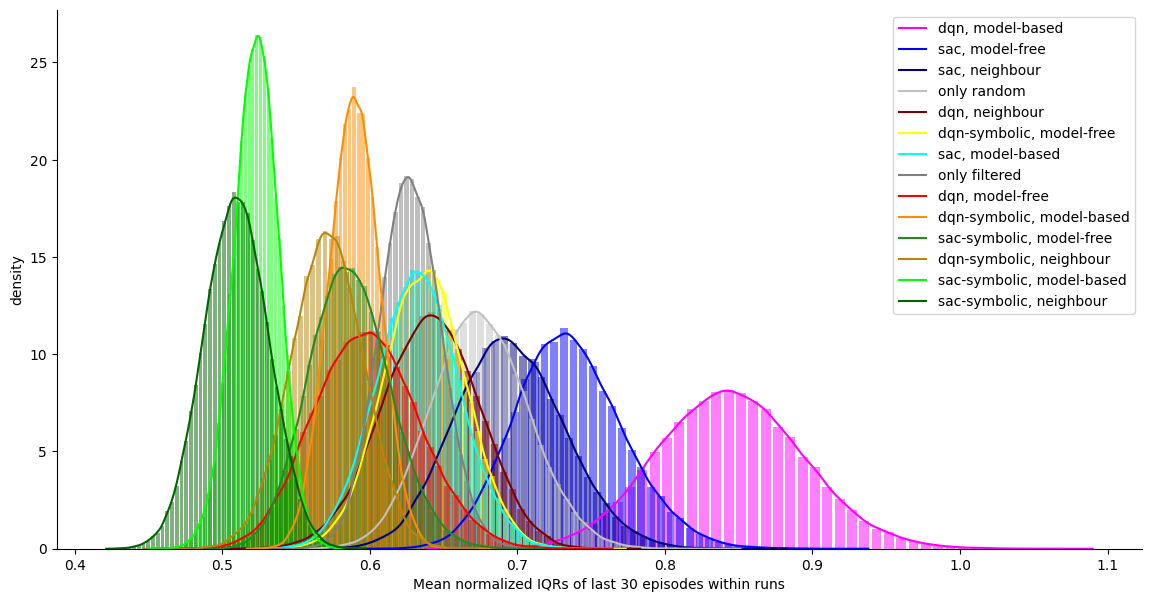

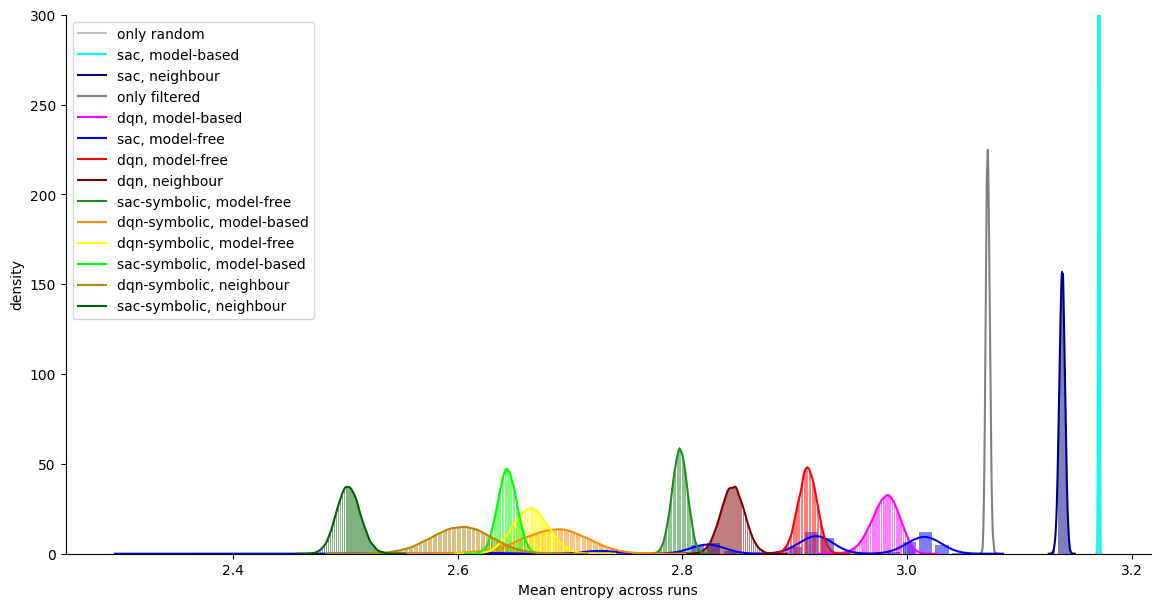

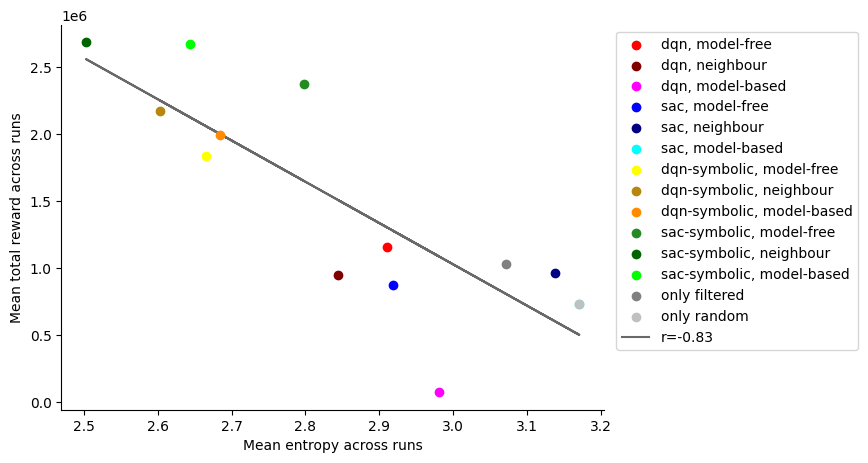

In [96]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
from numpy import random
random.seed(42)
from tqdm import tqdm
import seaborn as sns
import pickle
import os
from scipy import stats


omega_c = 0.01
T = 5

SEEDS = [101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120]
AGENT_TYPES = ["prioritized","sac","prioritized_symbolic","sac_symbolic"]
MBRL_KEYS = ["non-mbrl","mbrl","neighbour"]
GROUND_TYPES = [-1.0,0.0,1.0]
DRYWETS = [0.0,1.0]
data_type = "cumulative_training_rewards"

# mbrl_key = "non-mbrl"
# mbrl_key = "neighbour"
mbrl_key = "mbrl"

legend_dict = {
    "prioritized":"dqn",
    "sac":"sac",
    "prioritized_symbolic":"dqn-symbolic",
    "sac_symbolic":"sac-symbolic",
    "non-mbrl":"model-free",
    "neighbour":"neighbour",
    "mbrl":"model-based"
}

legend_dict_reverse = {
    "dqn":"prioritized",
    "sac":"sac",
    "dqn-symbolic":"prioritized_symbolic",
    "sac-symbolic":"sac_symbolic",
    "model-free":"non-mbrl",
    "neighbour":"neighbour",
    "model-based":"mbrl"
}

color_dict = {
    "dqn, model-free":"red",
    "sac, model-free":"blue",
    "dqn-symbolic, model-free":"yellow",
    "sac-symbolic, model-free":"forestgreen",
    "dqn, neighbour":"maroon",
    "sac, neighbour":"navy",
    "dqn-symbolic, neighbour":"darkgoldenrod",
    "sac-symbolic, neighbour":"darkgreen",
    "dqn, model-based":"magenta",
    "sac, model-based":"cyan",
    "dqn-symbolic, model-based":"darkorange",
    "sac-symbolic, model-based":"lime",
    "only filtered":"grey",
    "only random":"silver"
}


def generate_path_for_results(plot_tuple,ground_type, drywet, seed):
    if plot_tuple == "only filtered":
        path = f"experiments/evaluations/results/symbolic_only_filter_{ground_type}_{drywet}_{seed}.pickle"
        return path
    elif plot_tuple == "only random":
        path = f"experiments/evaluations/results/only_random_{ground_type}_{drywet}_{seed}.pickle"
        return path
    else:
        data_key_tuple = (legend_dict_reverse[plot_tuple.split(", ")[0]],legend_dict_reverse[plot_tuple.split(", ")[1]])
        path = f"experiments/evaluations/results/{data_key_tuple[0]}_{data_key_tuple[1]}_{ground_type}_{drywet}_{seed}.pickle"
        return path
    
# folder_name = "all_non-symbolic_nopt_baseline"
# agent_type = "sac"
# agent_type2 = "prioritized"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

# folder_name = "all_symbolic_nopt_baseline"
# agent_type = "sac_symbolic"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

# folder_name = "dqn_all_nopt_baseline"
# agent_type = "prioritized"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

# folder_name = "sac_all_nopt_baseline"
# agent_type = "sac"
# agent_type2 = "sac_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

folder_name = "all_all_nopt_baseline"
agent_type = "prioritized"
agent_type2 = "sac"
agent_type3 = "prioritized_symbolic"
agent_type4 = "sac_symbolic"

data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl"),(agent_type3,"non-mbrl"),(agent_type3,"neighbour"),(agent_type3,"mbrl"),(agent_type4,"non-mbrl"),(agent_type4,"neighbour"),(agent_type4,"mbrl")]




def plot_bootstrapped_results(seeds, ground_type, drywet, data_key_tuples, window_length, folder_name = None, n_bootstrap = 10, overwrite = False):
    result_path = "plots/statistical_tests/results"
    n_runs = 20
    bootstrap_idxs_list = []
    for i in range(n_bootstrap):
        bootstrap_idxs_list.append(random.choice(range(n_runs),n_runs, replace=True))
    partial_calculate_iqr_across_time_window = partial(calculate_iqr_across_time_window, window_length=window_length)
    plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    intermediate_data_dict = {}
    results_dict = {}
    bootstrap_results_dict = {}
    for plot_tuple in plot_tuples:
        # check if path  already exists
        current_path = result_path+f"/{plot_tuple}_{n_bootstrap}.pickle"
        # check if file exists under the path
        if os.path.exists(current_path):
            with open(current_path,"rb") as f:
                bootstrap_results_dict[plot_tuple] = pickle.load(f)
        if overwrite or not os.path.exists(current_path):   
            intermediate_data_dict[plot_tuple] = {}
            results_dict[plot_tuple] = {}
            bootstrap_results_dict[plot_tuple] = {}
            rewards_across_runs = np.empty((0,180))
            cumulative_rewards_across_runs = np.empty((0,180))
            diffs_during_runs = np.empty((0,179))
            entropy_across_runs = []
            entropy_across_first20_runs = []
            entropy_across_last30_runs = []
            for seed in seeds:
                path = generate_path_for_results(plot_tuple, ground_type, drywet, seed)
                with open(path,"rb") as f:
                    result = pickle.load(f)
                rewards = result["training_rewards"]
                diff_rewards = np.diff(rewards)
                cumulative_rewards = result["cumulative_training_rewards"]
                rewards_across_runs = np.vstack((rewards_across_runs,rewards))
                cumulative_rewards_across_runs = np.vstack((cumulative_rewards_across_runs,cumulative_rewards))
                diffs_during_runs = np.vstack((diffs_during_runs,diff_rewards))
                entropy_across_runs.append(calculate_entropy(result["crops_selected_idxs_list"]))
                entropy_across_first20_runs.append(calculate_entropy(result["crops_selected_idxs_list"][:20]))
                entropy_across_last30_runs.append(calculate_entropy(result["crops_selected_idxs_list"][-30:]))

            intermediate_data_dict[plot_tuple]["mean_rewards_across_runs_first20"]=np.mean(rewards_across_runs[:,:20],axis=1)
            intermediate_data_dict[plot_tuple]["mean_rewards_across_runs_last30"]=np.mean(rewards_across_runs[:,-30:],axis=1)
            intermediate_data_dict[plot_tuple]["q95_rewards_across_runs"] = np.quantile(rewards_across_runs,0.95,axis=1)
            intermediate_data_dict[plot_tuple]["total_reward_across_runs"]=cumulative_rewards_across_runs[:,-1]
            intermediate_data_dict[plot_tuple]["lpf_rewards_across_runs"]=calculate_lpf_raw(rewards_across_runs, omega_c, T)
            iqrs_during_runs = np.apply_along_axis(partial_calculate_iqr_across_time_window,axis=1,arr=diffs_during_runs)
            intermediate_data_dict[plot_tuple]["mean_iqrs_during_runs_first20"]=np.mean(iqrs_during_runs[:,:20],axis=1)
            intermediate_data_dict[plot_tuple]["mean_iqrs_during_runs_last30"]=np.mean(iqrs_during_runs[:,-30:],axis=1)
            intermediate_data_dict[plot_tuple]["entropy_across_runs"]=np.array(entropy_across_runs)
            intermediate_data_dict[plot_tuple]["entropy_across_first20_runs"]=np.array(entropy_across_first20_runs)
            intermediate_data_dict[plot_tuple]["entropy_across_last30_runs"]=np.array(entropy_across_last30_runs)

            bootstrap_results_dict[plot_tuple]["mean_rewards_across_runs_first20"] = []
            bootstrap_results_dict[plot_tuple]["mean_rewards_across_runs_last30"] = []
            bootstrap_results_dict[plot_tuple]["mean_total_reward_across_runs"] = []
            bootstrap_results_dict[plot_tuple]["mean_iqrs_across_runs_first20"] = []
            bootstrap_results_dict[plot_tuple]["mean_iqrs_across_runs_last30"] = []
            bootstrap_results_dict[plot_tuple]["mean_iqrs_across_runs_first20_norm"] = []
            bootstrap_results_dict[plot_tuple]["mean_iqrs_across_runs_last30_norm"] = []
            bootstrap_results_dict[plot_tuple]["mean_iqrs_during_runs_first20"] = []
            bootstrap_results_dict[plot_tuple]["mean_iqrs_during_runs_last30"] = []
            bootstrap_results_dict[plot_tuple]["mean_iqrs_during_runs_first20_norm"] = []
            bootstrap_results_dict[plot_tuple]["mean_iqrs_during_runs_last30_norm"] = []
            bootstrap_results_dict[plot_tuple]["mean_entropy_across_runs"] = []
            bootstrap_results_dict[plot_tuple]["mean_entropy_across_first20_runs"] = []
            bootstrap_results_dict[plot_tuple]["mean_entropy_across_last30_runs"] = [] 
            for bootstrap_idxs in tqdm(bootstrap_idxs_list):
                bootstrap_results_dict[plot_tuple]["mean_rewards_across_runs_first20"].append(np.mean(intermediate_data_dict[plot_tuple]["mean_rewards_across_runs_first20"][bootstrap_idxs]))
                bootstrap_results_dict[plot_tuple]["mean_rewards_across_runs_last30"].append(np.mean(intermediate_data_dict[plot_tuple]["mean_rewards_across_runs_last30"][bootstrap_idxs]))
                bootstrap_results_dict[plot_tuple]["mean_total_reward_across_runs"].append(np.mean(intermediate_data_dict[plot_tuple]["total_reward_across_runs"][bootstrap_idxs]))

                # calculate q95 from rewards across runs
                q95_mean_bootstrapped = intermediate_data_dict[plot_tuple]["q95_rewards_across_runs"][bootstrap_idxs].mean()

                # IQR across runs calculation from LPF raw data
                lpf_rewards_across_runs_bootstrapped = intermediate_data_dict[plot_tuple]["lpf_rewards_across_runs"][bootstrap_idxs]
                iqr_across_runs_bootstrapped = calculate_IQR_across_runs_from_LPF(lpf_rewards_across_runs_bootstrapped)
                mean_iqr_across_runs_bootstrapped_first20 = np.mean(iqr_across_runs_bootstrapped[:20])
                mean_iqr_across_runs_bootstrapped_last30 = np.mean(iqr_across_runs_bootstrapped[-30:])
                bootstrap_results_dict[plot_tuple]["mean_iqrs_across_runs_first20"].append(mean_iqr_across_runs_bootstrapped_first20)
                bootstrap_results_dict[plot_tuple]["mean_iqrs_across_runs_last30"].append(mean_iqr_across_runs_bootstrapped_last30)
                bootstrap_results_dict[plot_tuple]["mean_iqrs_across_runs_first20_norm"].append(mean_iqr_across_runs_bootstrapped_first20/q95_mean_bootstrapped)
                bootstrap_results_dict[plot_tuple]["mean_iqrs_across_runs_last30_norm"].append(mean_iqr_across_runs_bootstrapped_last30/q95_mean_bootstrapped)

                # IQR during runs calculation
                mean_iqrs_during_runs_bootstrapped_first20 = np.mean(intermediate_data_dict[plot_tuple]["mean_iqrs_during_runs_first20"][bootstrap_idxs])
                mean_iqrs_during_runs_bootstrapped_last30 = np.mean(intermediate_data_dict[plot_tuple]["mean_iqrs_during_runs_last30"][bootstrap_idxs])
                bootstrap_results_dict[plot_tuple]["mean_iqrs_during_runs_first20"].append(mean_iqrs_during_runs_bootstrapped_first20)
                bootstrap_results_dict[plot_tuple]["mean_iqrs_during_runs_last30"].append(mean_iqrs_during_runs_bootstrapped_last30)
                bootstrap_results_dict[plot_tuple]["mean_iqrs_during_runs_first20_norm"].append(mean_iqrs_during_runs_bootstrapped_first20/q95_mean_bootstrapped)
                bootstrap_results_dict[plot_tuple]["mean_iqrs_during_runs_last30_norm"].append(mean_iqrs_during_runs_bootstrapped_last30/q95_mean_bootstrapped)

                bootstrap_results_dict[plot_tuple]["mean_entropy_across_runs"].append(np.mean(intermediate_data_dict[plot_tuple]["entropy_across_runs"][bootstrap_idxs]))
                bootstrap_results_dict[plot_tuple]["mean_entropy_across_first20_runs"].append(np.mean(intermediate_data_dict[plot_tuple]["entropy_across_first20_runs"][bootstrap_idxs]))
                bootstrap_results_dict[plot_tuple]["mean_entropy_across_last30_runs"].append(np.mean(intermediate_data_dict[plot_tuple]["entropy_across_last30_runs"][bootstrap_idxs]))

            with open(current_path,"wb") as f:
                pickle.dump(bootstrap_results_dict[plot_tuple],f)


    if folder_name is not None:
        general_path = f"plots/statistical_tests/vis/{folder_name}"
        if not os.path.exists(general_path):
            os.makedirs(general_path)

    
    def plot_bootstrap_results_by_key(key, xlabel, ymax = None):
        # Mean first 20 training rewards
        plt.figure(figsize = (14,7))
        sorted_plot_tuples = []
        for plot_tuple in plot_tuples:
            a = np.array(bootstrap_results_dict[plot_tuple][key])
            tmp_mean = np.mean(a)
            tmp_std = np.std(a)
            sorted_plot_tuples.append((tmp_mean,plot_tuple))
        sorted_plot_tuples = sorted(sorted_plot_tuples, reverse = True)   
        for _, plot_tuple in sorted_plot_tuples:
            a = np.array(bootstrap_results_dict[plot_tuple][key])
            plt.hist(a, bins=50, alpha=0.5, color=color_dict[plot_tuple], density=True, rwidth = 0.8)
            # Plot the percentiles
            # ci_lower, ci_upper = np.percentile(a, [2.5, 97.5])
            # plt.axvline(ci_lower, color=color_dict[plot_tuple], alpha = 0.7, linestyle='dotted', linewidth=1.0)
            # plt.axvline(ci_upper, color=color_dict[plot_tuple], alpha = 0.7, linestyle='dashed', linewidth=1.0)
        for _, plot_tuple in sorted_plot_tuples:
            a = np.array(bootstrap_results_dict[plot_tuple][key])
            sns.kdeplot(a, color=color_dict[plot_tuple], alpha=1.0, label = plot_tuple)
        plt.xlabel(xlabel)
        plt.ylabel("density")
        plt.legend()
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        if ymax:
            plt.ylim(top=ymax)
        if folder_name is not None:
            image_path = f"{general_path}/{key}.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{key}.png"
            plt.savefig(image_path, bbox_inches='tight')

        plt.show()

    def plot_two_bootstrap_means_against_each_other(key1, key2, label1, label2, ymax= None):
        # Mean first 20 training rewards
        plt.figure(figsize = (7,5))
        plot_results = {}
        for plot_tuple in plot_tuples:
            a = np.array(bootstrap_results_dict[plot_tuple][key1])
            b = np.array(bootstrap_results_dict[plot_tuple][key2])
            mean1 = np.mean(a)
            mean2 = np.mean(b)
            plot_results[plot_tuple] = (mean1,mean2)

        # create plot with mean1 on x-axis and mean2 on y-axis
        for plot_tuple in plot_tuples:
            plt.scatter(plot_results[plot_tuple][0],plot_results[plot_tuple][1], color=color_dict[plot_tuple], alpha=1.0, label = plot_tuple, zorder=2)
        # plot linear regression line
        x = np.array([plot_results[plot_tuple][0] for plot_tuple in plot_tuples])
        y = np.array([plot_results[plot_tuple][1] for plot_tuple in plot_tuples])
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        plt.plot(x, intercept + slope*x, color="dimgrey", alpha=1.0, label = f"r={r_value:.2f}", zorder=1)

        plt.xlabel(label1)
        plt.ylabel(label2)
        # add legend to the right of the plot
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        if ymax:
            plt.ylim(top=ymax)
        if folder_name is not None:
            image_path = f"{general_path}/scatter_{key1}_{key2}.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/scatter_{key1}_{key2}.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()


    key = "mean_rewards_across_runs_first20"
    xlabel = "Mean first 20 training reward across runs"
    plot_bootstrap_results_by_key(key, xlabel)

    key = "mean_rewards_across_runs_last30"
    xlabel = "Mean last 30 training reward across runs"
    plot_bootstrap_results_by_key(key, xlabel)

    key = "mean_total_reward_across_runs"
    xlabel = "Mean total reward across runs"
    plot_bootstrap_results_by_key(key, xlabel)

    key = "mean_iqrs_across_runs_first20_norm"
    xlabel = "Mean normalized IQRs of first 20 episodes across runs"
    plot_bootstrap_results_by_key(key, xlabel)

    key = "mean_iqrs_across_runs_last30_norm"
    xlabel = "Mean normalized IQRs of last 30 episodes across runs"
    plot_bootstrap_results_by_key(key, xlabel)

    key = "mean_iqrs_during_runs_first20_norm"
    xlabel = "Mean normalized IQRs of first 20 episodes within runs"
    plot_bootstrap_results_by_key(key, xlabel)

    key = "mean_iqrs_during_runs_last30_norm"
    xlabel = "Mean normalized IQRs of last 30 episodes within runs"
    plot_bootstrap_results_by_key(key, xlabel)

    key = "mean_entropy_across_runs"
    xlabel = "Mean entropy across runs"
    plot_bootstrap_results_by_key(key, xlabel, ymax = 300)

    key2 = "mean_total_reward_across_runs"
    key1 = "mean_entropy_across_runs"
    label2 = "Mean total reward across runs"
    label1 = "Mean entropy across runs"
    plot_two_bootstrap_means_against_each_other(key1, key2, label1, label2)


plot_bootstrapped_results(SEEDS, ground_type = 0.0,drywet = 1.0, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, n_bootstrap = 50000, overwrite = True)

## Bootstrap Pretraining results

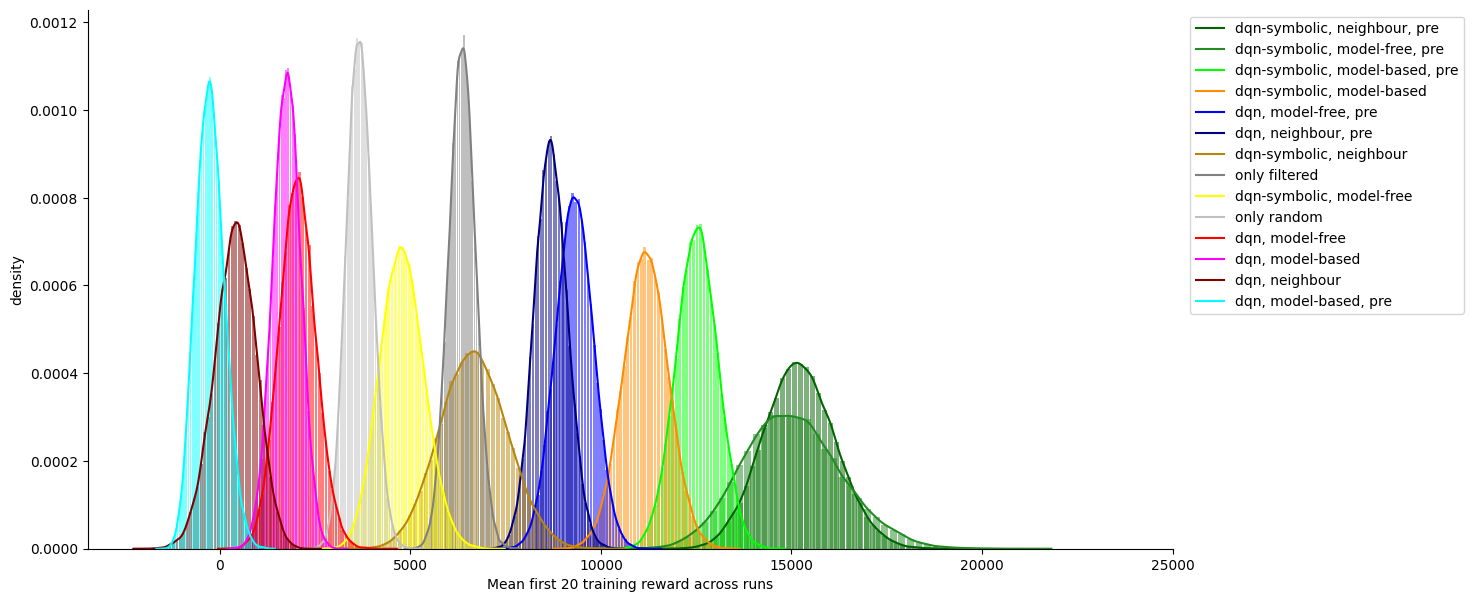

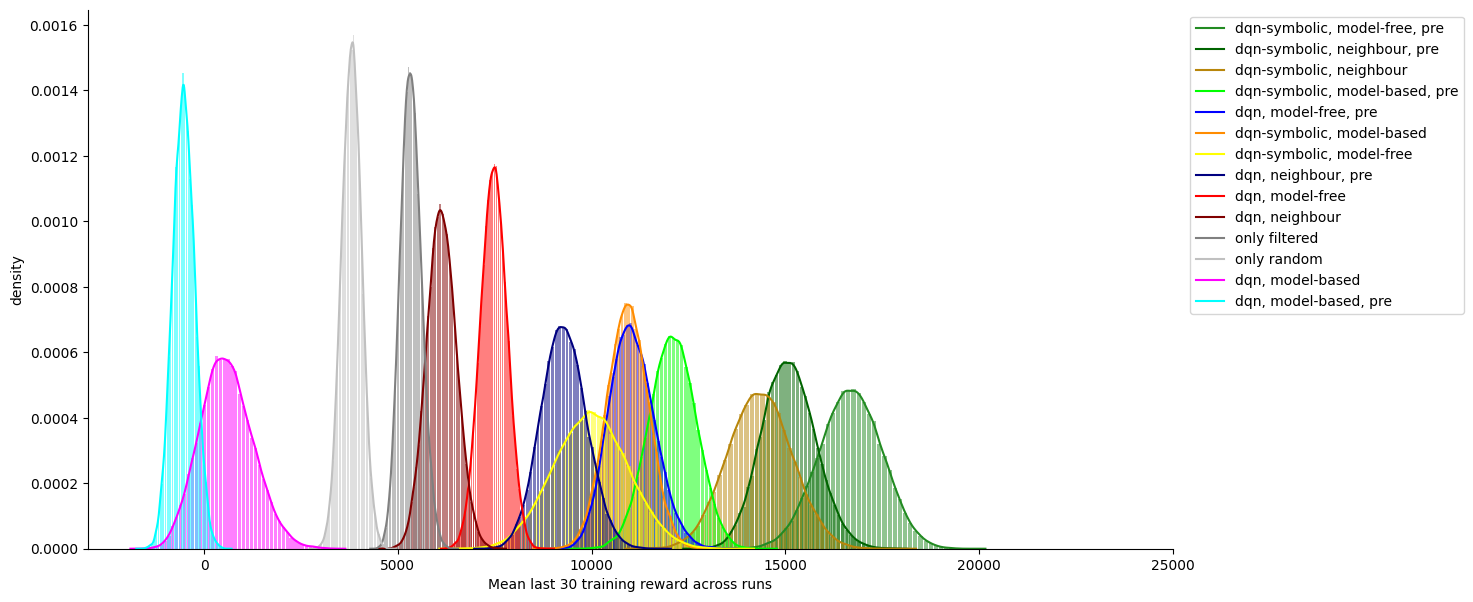

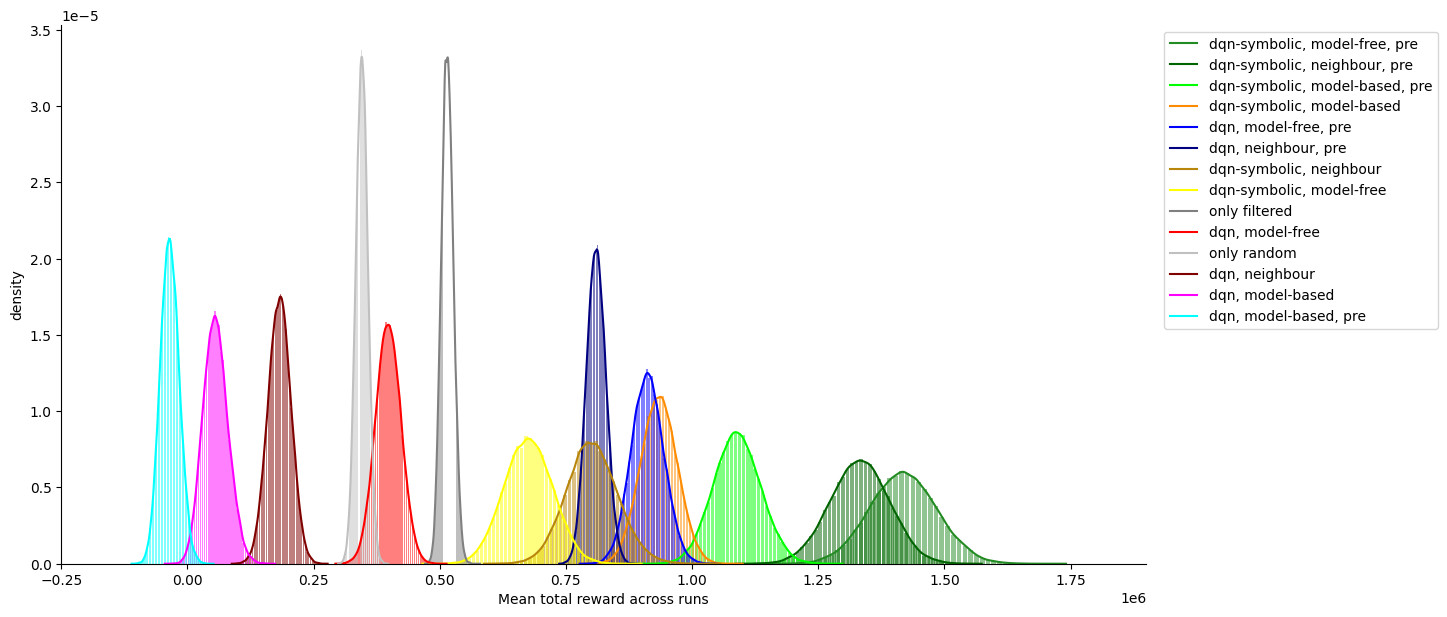

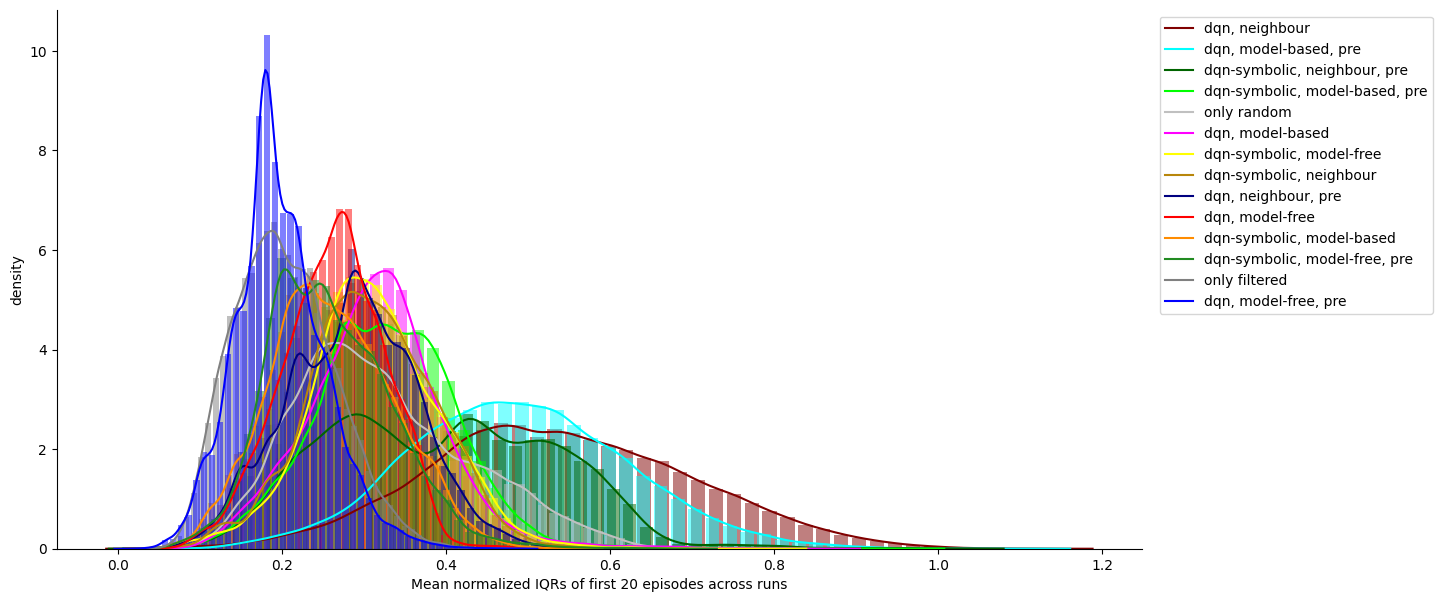

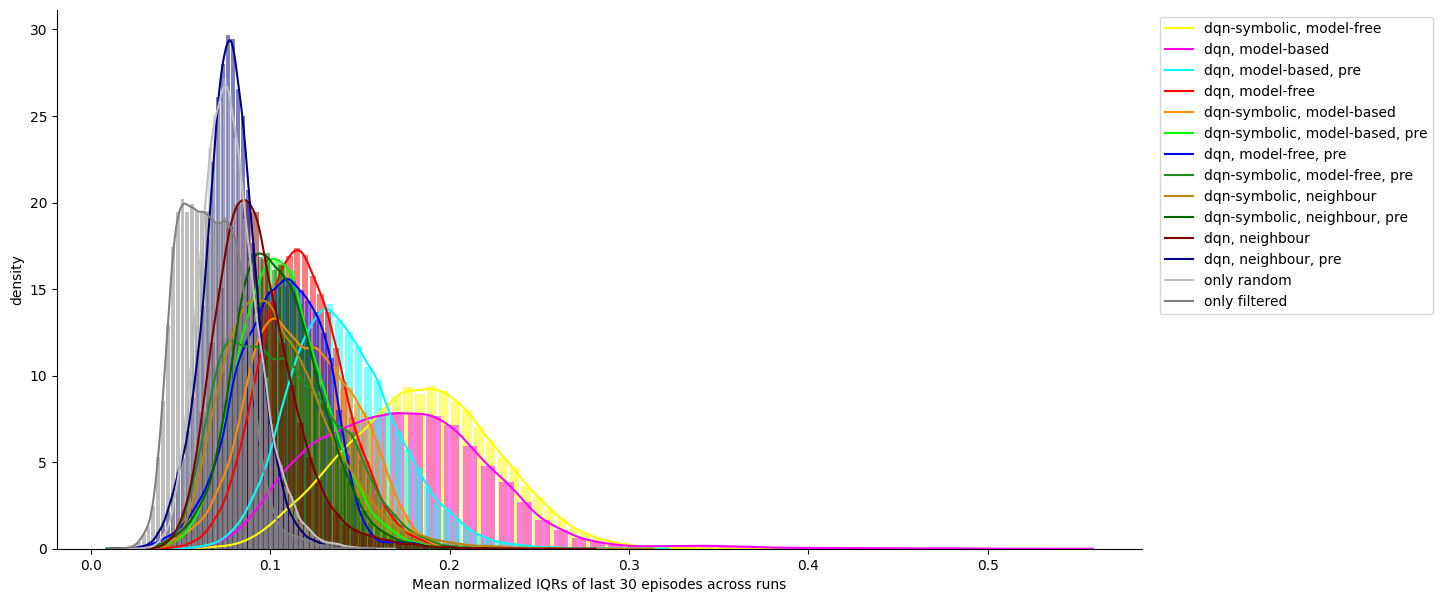

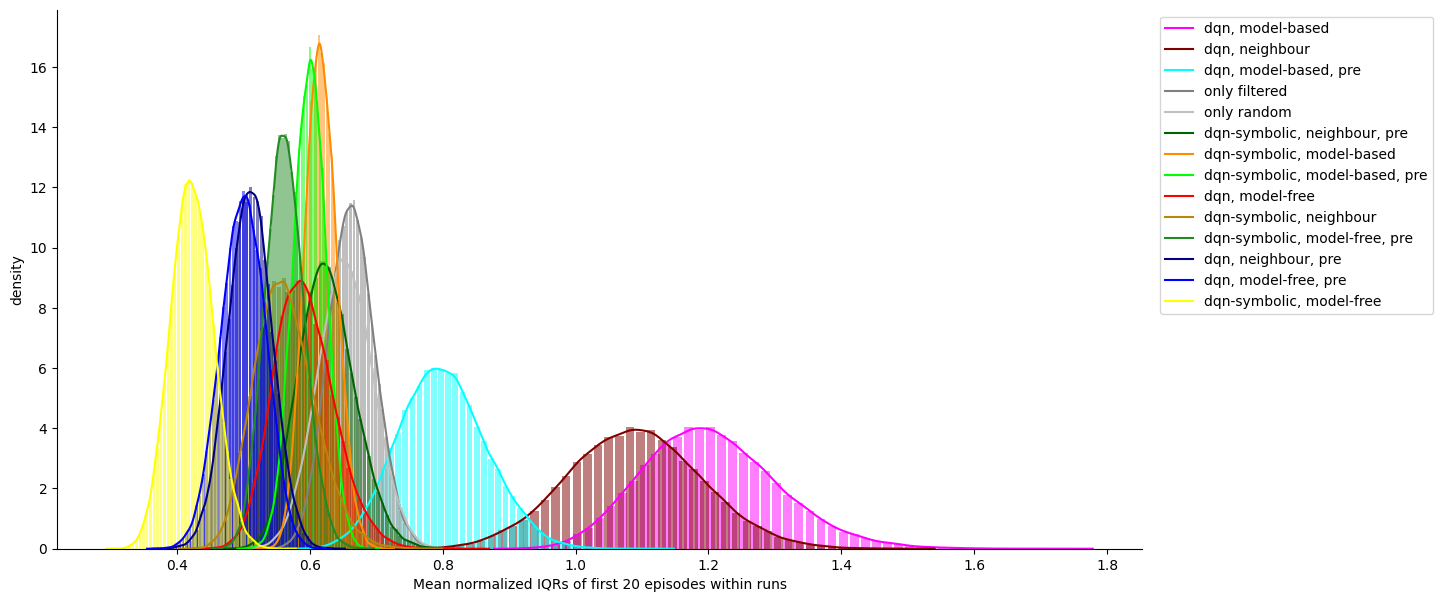

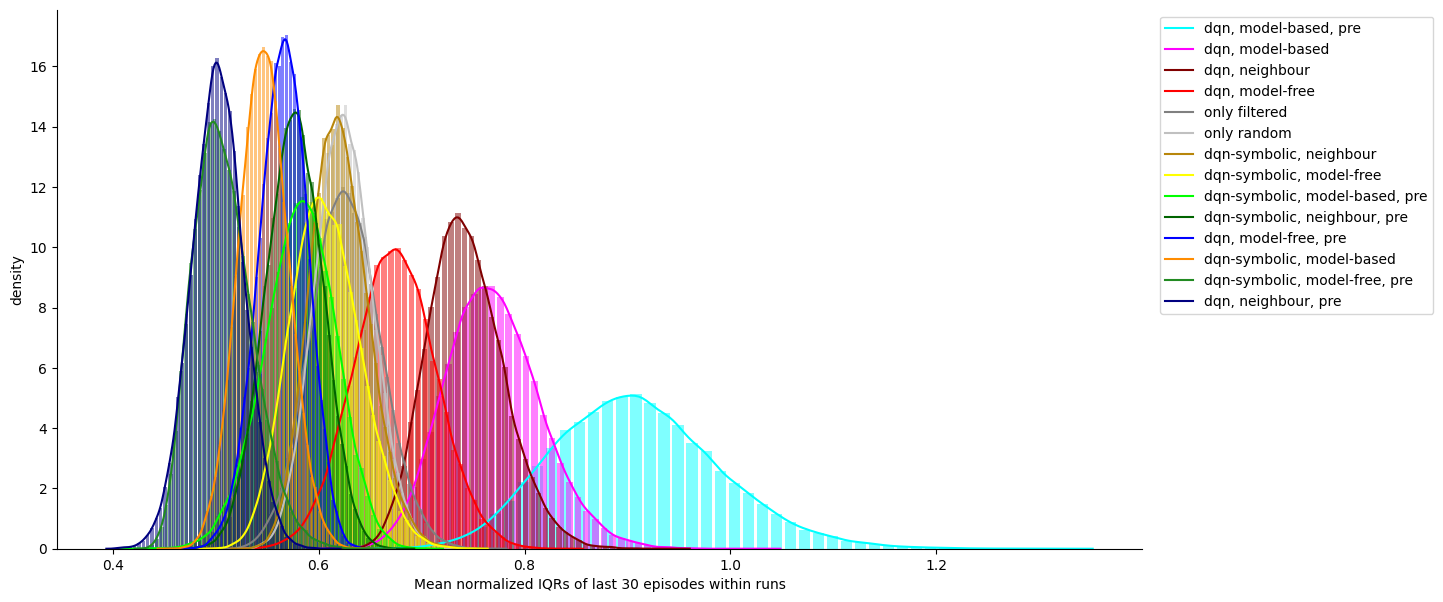

In [83]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
from numpy import random
random.seed(42)
from tqdm import tqdm
import seaborn as sns
import pickle
import os
from scipy import stats


omega_c = 0.01
T = 5

SEEDS = [101,102,103,104,105]
AGENT_TYPES = ["prioritized","sac","prioritized_symbolic","sac_symbolic"]
MBRL_KEYS = ["non-mbrl","mbrl","neighbour"]

# mbrl_key = "non-mbrl"
# mbrl_key = "neighbour"
mbrl_key = "mbrl"

legend_dict = {
    "prioritized":"dqn",
    "sac":"sac",
    "prioritized_symbolic":"dqn-symbolic",
    "sac_symbolic":"sac-symbolic",
    "non-mbrl":"model-free",
    "neighbour":"neighbour",
    "mbrl":"model-based"
}

legend_dict_reverse = {
    "dqn":"prioritized",
    "sac":"sac",
    "dqn-symbolic":"prioritized_symbolic",
    "sac-symbolic":"sac_symbolic",
    "model-free":"non-mbrl",
    "neighbour":"neighbour",
    "model-based":"mbrl"
}

color_dict = {
    "dqn, model-free":"red",
    "sac, model-free":"blue",
    "dqn-symbolic, model-free":"yellow",
    "sac-symbolic, model-free":"forestgreen",
    "dqn, neighbour":"maroon",
    "sac, neighbour":"navy",
    "dqn-symbolic, neighbour":"darkgoldenrod",
    "sac-symbolic, neighbour":"darkgreen",
    "dqn, model-based":"magenta",
    "sac, model-based":"cyan",
    "dqn-symbolic, model-based":"darkorange",
    "sac-symbolic, model-based":"lime",
    "only filtered":"grey",
    "only random":"silver"
}

color_dict_pretrained = {
    "pretrained":{
        "dqn, model-free":"blue",
        "sac, model-free":"blue",
        "dqn-symbolic, model-free":"forestgreen",
        "sac-symbolic, model-free":"forestgreen",
        "dqn, neighbour":"navy",
        "sac, neighbour":"navy",
        "dqn-symbolic, neighbour":"darkgreen",
        "sac-symbolic, neighbour":"darkgreen",
        "dqn, model-based":"cyan",
        "sac, model-based":"cyan",
        "dqn-symbolic, model-based":"lime",
        "sac-symbolic, model-based":"lime",
        "only filtered":"grey",
        "only random":"silver"
    },
    "base":{
        "dqn, model-free":"red",
        "sac, model-free":"red",
        "dqn-symbolic, model-free":"yellow",
        "sac-symbolic, model-free":"yellow",
        "dqn, neighbour":"maroon",
        "sac, neighbour":"maroon",
        "dqn-symbolic, neighbour":"darkgoldenrod",
        "sac-symbolic, neighbour":"darkgoldenrod",
        "dqn, model-based":"magenta",
        "sac, model-based":"magenta",
        "dqn-symbolic, model-based":"darkorange",
        "sac-symbolic, model-based":"darkorange",
        "only filtered":"grey",
        "only random":"silver"
    }

}

def generate_path_for_pretrained_results(plot_tuple, seed, test_seed):
    data_key_tuple = (legend_dict_reverse[plot_tuple.split(", ")[0]],legend_dict_reverse[plot_tuple.split(", ")[1]])
    path = f"experiments/evaluations/pretraining_results/{data_key_tuple[0]}_{data_key_tuple[1]}_{seed}_{test_seed}.pickle"
    return path

def generate_path_for_results(plot_tuple,ground_type, drywet, seed):
    if plot_tuple == "only filtered":
        path = f"experiments/evaluations/results/symbolic_only_filter_{ground_type}_{drywet}_{seed}.pickle"
        return path
    elif plot_tuple == "only random":
        path = f"experiments/evaluations/results/only_random_{ground_type}_{drywet}_{seed}.pickle"
        return path
    else:
        data_key_tuple = (legend_dict_reverse[plot_tuple.split(", ")[0]],legend_dict_reverse[plot_tuple.split(", ")[1]])
        path = f"experiments/evaluations/results/{data_key_tuple[0]}_{data_key_tuple[1]}_{ground_type}_{drywet}_{seed}.pickle"
        return path
    


def plot_pretrained_bootstrapped_results(seeds, data_key_tuples, window_length, folder_name = None, n_bootstrap = 10, compare_flag = "pretrained", overwrite = False):
    ground_type = 0.0
    drywet = 1.0
    result_path_pretrained = "plots/statistical_tests/pretrained_results"
    result_path_base = "plots/statistical_tests/results_cropped90ep"
    n_runs = 15
    n_episodes = 90
    bootstrap_idxs_list = []
    for i in range(n_bootstrap):
        bootstrap_idxs_list.append(random.choice(range(n_runs),n_runs, replace=True))
    partial_calculate_iqr_across_time_window = partial(calculate_iqr_across_time_window, window_length=window_length)
    plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    intermediate_data_dict = {
        "pretrained":{},
        "base":{}
    }
    results_dict = {
        "pretrained":{},
        "base":{}        
    }
    bootstrap_results_dict = {
        "pretrained":{},
        "base":{}
    }
    if compare_flag == "both":
        keys = ["pretrained","base"]
    else:
        keys = ["pretrained"]
    for intended_key in keys:
        for plot_tuple in plot_tuples:
            if intended_key == "pretrained":
                if plot_tuple in ["only filtered","only random"]:
                    current_path = result_path_base+f"/{plot_tuple}_{n_bootstrap}.pickle"
                    key = "base"
                else:
                    current_path = result_path_pretrained+f"/{plot_tuple}_{n_bootstrap}.pickle"
                    key = "pretrained"
            else:
                if plot_tuple in ["only filtered","only random"]:
                    continue
                else:
                    current_path = result_path_base+f"/{plot_tuple}_{n_bootstrap}.pickle"
                    key = "base"

            if os.path.exists(current_path):
                with open(current_path,"rb") as f:
                    bootstrap_results_dict[key][plot_tuple] = pickle.load(f)
            if overwrite or not os.path.exists(current_path):     
                intermediate_data_dict[key][plot_tuple] = {}
                results_dict[key][plot_tuple] = {}
                bootstrap_results_dict[key][plot_tuple] = {}
                rewards_across_runs = np.empty((0,n_episodes))
                cumulative_rewards_across_runs = np.empty((0,n_episodes))
                diffs_during_runs = np.empty((0,n_episodes-1))
                for seed in seeds:
                    test_seeds = [seed+5,seed+10,seed+15]
                    for test_seed in test_seeds:
                        if key == "pretrained":
                            path = generate_path_for_pretrained_results(plot_tuple, seed, test_seed)
                        else:
                            path = generate_path_for_results(plot_tuple, ground_type, drywet, test_seed)
                        with open(path,"rb") as f:
                            result = pickle.load(f)
                        rewards = result["training_rewards"][:n_episodes]
                        diff_rewards = np.diff(rewards)
                        cumulative_rewards = result["cumulative_training_rewards"][:n_episodes]
                        rewards_across_runs = np.vstack((rewards_across_runs,rewards))
                        cumulative_rewards_across_runs = np.vstack((cumulative_rewards_across_runs,cumulative_rewards))
                        diffs_during_runs = np.vstack((diffs_during_runs,diff_rewards))

                intermediate_data_dict[key][plot_tuple]["mean_rewards_across_runs_first20"]=np.mean(rewards_across_runs[:,:20],axis=1)
                intermediate_data_dict[key][plot_tuple]["mean_rewards_across_runs_last30"]=np.mean(rewards_across_runs[:,-30:],axis=1)
                intermediate_data_dict[key][plot_tuple]["q95_rewards_across_runs"] = np.quantile(rewards_across_runs,0.95,axis=1)
                intermediate_data_dict[key][plot_tuple]["total_reward_across_runs"]=cumulative_rewards_across_runs[:,-1]
                intermediate_data_dict[key][plot_tuple]["lpf_rewards_across_runs"]=calculate_lpf_raw(rewards_across_runs, omega_c, T)
                iqrs_during_runs = np.apply_along_axis(partial_calculate_iqr_across_time_window,axis=1,arr=diffs_during_runs)
                intermediate_data_dict[key][plot_tuple]["mean_iqrs_during_runs_first20"]=np.mean(iqrs_during_runs[:,:20],axis=1)
                intermediate_data_dict[key][plot_tuple]["mean_iqrs_during_runs_last30"]=np.mean(iqrs_during_runs[:,-30:],axis=1)

                bootstrap_results_dict[key][plot_tuple]["mean_rewards_across_runs_first20"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_rewards_across_runs_last30"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_total_reward_across_runs"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_iqrs_across_runs_first20"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_iqrs_across_runs_last30"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_iqrs_across_runs_first20_norm"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_iqrs_across_runs_last30_norm"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_iqrs_during_runs_first20"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_iqrs_during_runs_last30"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_iqrs_during_runs_first20_norm"] = []
                bootstrap_results_dict[key][plot_tuple]["mean_iqrs_during_runs_last30_norm"] = []
                for bootstrap_idxs in tqdm(bootstrap_idxs_list):
                    bootstrap_results_dict[key][plot_tuple]["mean_rewards_across_runs_first20"].append(np.mean(intermediate_data_dict[key][plot_tuple]["mean_rewards_across_runs_first20"][bootstrap_idxs]))
                    bootstrap_results_dict[key][plot_tuple]["mean_rewards_across_runs_last30"].append(np.mean(intermediate_data_dict[key][plot_tuple]["mean_rewards_across_runs_last30"][bootstrap_idxs]))
                    bootstrap_results_dict[key][plot_tuple]["mean_total_reward_across_runs"].append(np.mean(intermediate_data_dict[key][plot_tuple]["total_reward_across_runs"][bootstrap_idxs]))

                    # calculate q95 from rewards across runs
                    q95_mean_bootstrapped = intermediate_data_dict[key][plot_tuple]["q95_rewards_across_runs"][bootstrap_idxs].mean()

                    # IQR across runs calculation from LPF raw data
                    lpf_rewards_across_runs_bootstrapped = intermediate_data_dict[key][plot_tuple]["lpf_rewards_across_runs"][bootstrap_idxs]
                    iqr_across_runs_bootstrapped = calculate_IQR_across_runs_from_LPF(lpf_rewards_across_runs_bootstrapped)
                    mean_iqr_across_runs_bootstrapped_first20 = np.mean(iqr_across_runs_bootstrapped[:20])
                    mean_iqr_across_runs_bootstrapped_last30 = np.mean(iqr_across_runs_bootstrapped[-30:])
                    bootstrap_results_dict[key][plot_tuple]["mean_iqrs_across_runs_first20"].append(mean_iqr_across_runs_bootstrapped_first20)
                    bootstrap_results_dict[key][plot_tuple]["mean_iqrs_across_runs_last30"].append(mean_iqr_across_runs_bootstrapped_last30)
                    bootstrap_results_dict[key][plot_tuple]["mean_iqrs_across_runs_first20_norm"].append(mean_iqr_across_runs_bootstrapped_first20/q95_mean_bootstrapped)
                    bootstrap_results_dict[key][plot_tuple]["mean_iqrs_across_runs_last30_norm"].append(mean_iqr_across_runs_bootstrapped_last30/q95_mean_bootstrapped)

                    # IQR during runs calculation
                    mean_iqrs_during_runs_bootstrapped_first20 = np.mean(intermediate_data_dict[key][plot_tuple]["mean_iqrs_during_runs_first20"][bootstrap_idxs])
                    mean_iqrs_during_runs_bootstrapped_last30 = np.mean(intermediate_data_dict[key][plot_tuple]["mean_iqrs_during_runs_last30"][bootstrap_idxs])
                    bootstrap_results_dict[key][plot_tuple]["mean_iqrs_during_runs_first20"].append(mean_iqrs_during_runs_bootstrapped_first20)
                    bootstrap_results_dict[key][plot_tuple]["mean_iqrs_during_runs_last30"].append(mean_iqrs_during_runs_bootstrapped_last30)
                    bootstrap_results_dict[key][plot_tuple]["mean_iqrs_during_runs_first20_norm"].append(mean_iqrs_during_runs_bootstrapped_first20/q95_mean_bootstrapped)
                    bootstrap_results_dict[key][plot_tuple]["mean_iqrs_during_runs_last30_norm"].append(mean_iqrs_during_runs_bootstrapped_last30/q95_mean_bootstrapped)

                with open(current_path,"wb") as f:
                    pickle.dump(bootstrap_results_dict[key][plot_tuple],f)


    if folder_name is not None:
        general_path = f"plots/statistical_tests/pretrained_vis/{folder_name}"
        if not os.path.exists(general_path):
            os.makedirs(general_path)

    
    def plot_bootstrap_results_by_key(metric_key, xlabel, intended_keys = ["pretrained","base"], xmin = None, xmax = None):
        # Mean first 20 training rewards
        plt.figure(figsize = (14,7))
        sorted_plot_tuples = []
        for intended_key in keys:
            for plot_tuple in plot_tuples:
                if intended_key == "pretrained":
                    if plot_tuple in ["only filtered","only random"]:
                        current_path = result_path_base+f"/{plot_tuple}_{n_bootstrap}.pickle"
                        type_key = "base"
                    else:
                        current_path = result_path_pretrained+f"/{plot_tuple}_{n_bootstrap}.pickle"
                        type_key = "pretrained"
                else:
                    if plot_tuple in ["only filtered","only random"]:
                        continue
                    else:
                        current_path = result_path_base+f"/{plot_tuple}_{n_bootstrap}.pickle"
                        type_key = "base"
                a = np.array(bootstrap_results_dict[type_key][plot_tuple][metric_key])
                tmp_mean = np.mean(a)
                tmp_std = np.std(a)
                sorted_plot_tuples.append((tmp_mean,plot_tuple,type_key))
        sorted_plot_tuples = sorted(sorted_plot_tuples, reverse = True)   
        for _, plot_tuple, type_key in sorted_plot_tuples:
            a = np.array(bootstrap_results_dict[type_key][plot_tuple][metric_key])
            if len(intended_keys)==2:
                plt.hist(a, bins=50, alpha=0.5, color=color_dict_pretrained[type_key][plot_tuple], density=True, rwidth = 0.8)
            else:
                plt.hist(a, bins=50, alpha=0.5, color=color_dict[plot_tuple], density=True, rwidth = 0.8)
            # Plot the percentiles
            # ci_lower, ci_upper = np.percentile(a, [2.5, 97.5])
            # plt.axvline(ci_lower, color=color_dict[plot_tuple], alpha = 0.7, linestyle='dotted', linewidth=1.0)
            # plt.axvline(ci_upper, color=color_dict[plot_tuple], alpha = 0.7, linestyle='dashed', linewidth=1.0)
        for _, plot_tuple, type_key in sorted_plot_tuples:
            a = np.array(bootstrap_results_dict[type_key][plot_tuple][metric_key])
            if len(intended_keys)==2:
                if type_key == "pretrained":
                    sns.kdeplot(a, color=color_dict_pretrained[type_key][plot_tuple], alpha=1.0, label = plot_tuple+", pre")
                else:
                    sns.kdeplot(a, color=color_dict_pretrained[type_key][plot_tuple], alpha=1.0, label = plot_tuple)
            else:
                sns.kdeplot(a, color=color_dict[plot_tuple], alpha=1.0, label = plot_tuple+", pre")
        plt.xlabel(xlabel)
        plt.ylabel("density")
        # put legend to the right of the plot
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        if xmax is not None:
            plt.xlim(right = xmax)
        if xmin is not None:
            plt.xlim(left = xmin)
        if folder_name is not None:
            image_path = f"{general_path}/{metric_key}.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{metric_key}.png"
            plt.savefig(image_path, bbox_inches='tight')

        plt.show()


    key = "mean_rewards_across_runs_first20"
    xlabel = "Mean first 20 training reward across runs"
    plot_bootstrap_results_by_key(key, xlabel, intended_keys = keys, xmax = 25000)

    key = "mean_rewards_across_runs_last30"
    xlabel = "Mean last 30 training reward across runs"
    plot_bootstrap_results_by_key(key, xlabel, intended_keys = keys, xmax = 25000)

    key = "mean_total_reward_across_runs"
    xlabel = "Mean total reward across runs"
    plot_bootstrap_results_by_key(key, xlabel, intended_keys = keys, xmin =-0.25e6, xmax = 1.9e6)

    key = "mean_iqrs_across_runs_first20_norm"
    xlabel = "Mean normalized IQRs of first 20 episodes across runs"
    plot_bootstrap_results_by_key(key, xlabel, intended_keys = keys)

    key = "mean_iqrs_across_runs_last30_norm"
    xlabel = "Mean normalized IQRs of last 30 episodes across runs"
    plot_bootstrap_results_by_key(key, xlabel, intended_keys = keys)

    key = "mean_iqrs_during_runs_first20_norm"
    xlabel = "Mean normalized IQRs of first 20 episodes within runs"
    plot_bootstrap_results_by_key(key, xlabel, intended_keys = keys)

    key = "mean_iqrs_during_runs_last30_norm"
    xlabel = "Mean normalized IQRs of last 30 episodes within runs"
    plot_bootstrap_results_by_key(key, xlabel, intended_keys = keys)


folder_name = "dqn_all_pt_baseline"
agent_type = "prioritized"
agent_type2 = "prioritized_symbolic"
data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

# folder_name = "sac_all_pt_baseline"
# agent_type = "sac"
# agent_type2 = "sac_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

# folder_name = "all_all_onlypt_baseline"
# agent_type = "prioritized"
# agent_type2 = "sac"
# agent_type3 = "prioritized_symbolic"
# agent_type4 = "sac_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl"),(agent_type3,"non-mbrl"),(agent_type3,"neighbour"),(agent_type3,"mbrl"),(agent_type4,"non-mbrl"),(agent_type4,"neighbour"),(agent_type4,"mbrl")]

plot_pretrained_bootstrapped_results(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, n_bootstrap = 50000, compare_flag = "both", overwrite = False)

## Barplots Main Results

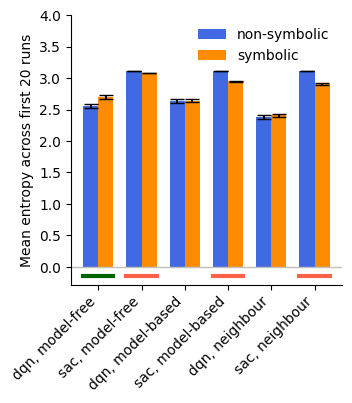

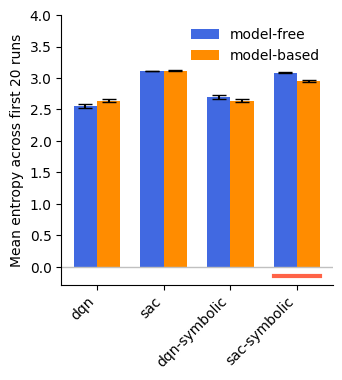

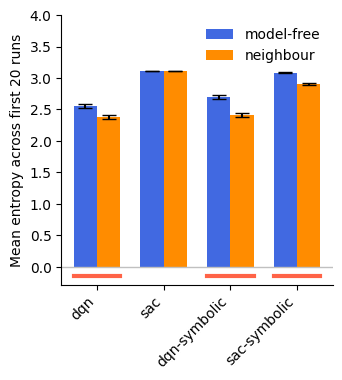

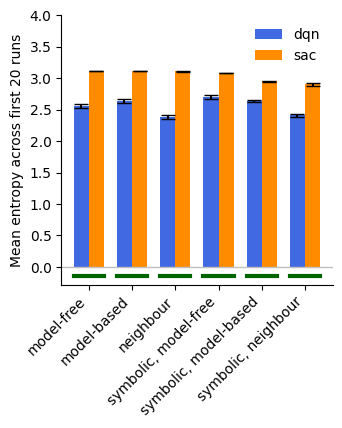

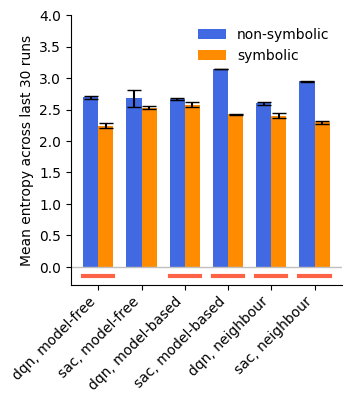

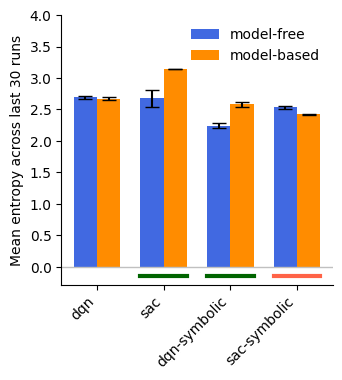

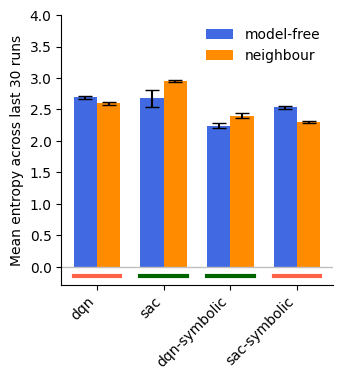

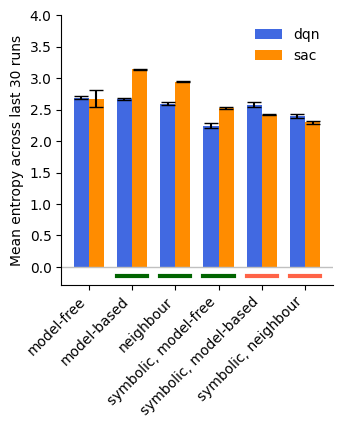

In [24]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
from numpy import random
random.seed(42)
from tqdm import tqdm
import seaborn as sns
import pickle
import os
from scipy import stats
from matplotlib.colors import ListedColormap


omega_c = 0.01
T = 5

SEEDS = [101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120]
AGENT_TYPES = ["prioritized","sac","prioritized_symbolic","sac_symbolic"]
MBRL_KEYS = ["non-mbrl","mbrl","neighbour"]
GROUND_TYPES = [-1.0,0.0,1.0]
DRYWETS = [0.0,1.0]
data_type = "cumulative_training_rewards"

# mbrl_key = "non-mbrl"
# mbrl_key = "neighbour"
mbrl_key = "mbrl"

legend_dict = {
    "prioritized":"dqn",
    "sac":"sac",
    "prioritized_symbolic":"dqn-symbolic",
    "sac_symbolic":"sac-symbolic",
    "non-mbrl":"model-free",
    "neighbour":"neighbour",
    "mbrl":"model-based"
}

legend_dict_reverse = {
    "dqn":"prioritized",
    "sac":"sac",
    "dqn-symbolic":"prioritized_symbolic",
    "sac-symbolic":"sac_symbolic",
    "model-free":"non-mbrl",
    "neighbour":"neighbour",
    "model-based":"mbrl"
}

color_dict = {
    "dqn, model-free":"red",
    "sac, model-free":"blue",
    "dqn-symbolic, model-free":"yellow",
    "sac-symbolic, model-free":"forestgreen",
    "dqn, neighbour":"maroon",
    "sac, neighbour":"navy",
    "dqn-symbolic, neighbour":"darkgoldenrod",
    "sac-symbolic, neighbour":"darkgreen",
    "dqn, model-based":"magenta",
    "sac, model-based":"cyan",
    "dqn-symbolic, model-based":"darkorange",
    "sac-symbolic, model-based":"lime",
    "only filtered":"grey",
    "only random":"silver"
}


def generate_path_for_results(plot_tuple,ground_type, drywet, seed):
    if plot_tuple == "only filtered":
        path = f"experiments/evaluations/results/symbolic_only_filter_{ground_type}_{drywet}_{seed}.pickle"
        return path
    elif plot_tuple == "only random":
        path = f"experiments/evaluations/results/only_random_{ground_type}_{drywet}_{seed}.pickle"
        return path
    else:
        data_key_tuple = (legend_dict_reverse[plot_tuple.split(", ")[0]],legend_dict_reverse[plot_tuple.split(", ")[1]])
        path = f"experiments/evaluations/results/{data_key_tuple[0]}_{data_key_tuple[1]}_{ground_type}_{drywet}_{seed}.pickle"
        return path
    
# folder_name = "all_non-symbolic_nopt_baseline"
# agent_type = "sac"
# agent_type2 = "prioritized"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

# folder_name = "all_symbolic_nopt_baseline"
# agent_type = "sac_symbolic"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

# folder_name = "dqn_all_nopt_baseline"
# agent_type = "prioritized"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]

# folder_name = "sac_all_nopt_baseline"
# agent_type = "sac"
# agent_type2 = "sac_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]




def create_intermediate_results(seeds, ground_type, drywet, data_key_tuples, window_length, overwrite = False):
    intermediate_result_path = "plots/statistical_tests/intermediate_results"
    partial_calculate_iqr_across_time_window = partial(calculate_iqr_across_time_window, window_length=window_length)
    plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    intermediate_data_dict = {}
    for plot_tuple in plot_tuples:
        # check if path  already exists
        current_path = intermediate_result_path+f"/{plot_tuple}.pickle"
        # check if file exists under the path
        if os.path.exists(current_path) and not overwrite:
            with open(current_path,"rb") as f:
                intermediate_data_dict[plot_tuple] = pickle.load(f)
        else:
            intermediate_data_dict[plot_tuple] = {}
            rewards_across_runs = np.empty((0,180))
            cumulative_rewards_across_runs = np.empty((0,180))
            diffs_during_runs = np.empty((0,179))
            entropy_across_runs = []
            entropy_across_first20_runs = []
            entropy_across_last30_runs = []
            for seed in seeds:
                path = generate_path_for_results(plot_tuple, ground_type, drywet, seed)
                with open(path,"rb") as f:
                    result = pickle.load(f)
                rewards = result["training_rewards"]
                diff_rewards = np.diff(rewards)
                cumulative_rewards = result["cumulative_training_rewards"]
                rewards_across_runs = np.vstack((rewards_across_runs,rewards))
                cumulative_rewards_across_runs = np.vstack((cumulative_rewards_across_runs,cumulative_rewards))
                diffs_during_runs = np.vstack((diffs_during_runs,diff_rewards))
                entropy_across_runs.append(calculate_entropy(result["crops_selected_idxs_list"]))
                entropy_across_first20_runs.append(calculate_entropy(result["crops_selected_idxs_list"][:20]))
                entropy_across_last30_runs.append(calculate_entropy(result["crops_selected_idxs_list"][-30:]))

            intermediate_data_dict[plot_tuple]["mean_rewards_across_runs_first20"]=np.mean(rewards_across_runs[:,:20],axis=1)
            intermediate_data_dict[plot_tuple]["mean_rewards_across_runs_last30"]=np.mean(rewards_across_runs[:,-30:],axis=1)
            intermediate_data_dict[plot_tuple]["q95_rewards_across_runs"] = np.quantile(rewards_across_runs,0.95,axis=1)
            intermediate_data_dict[plot_tuple]["total_reward_across_runs"]=cumulative_rewards_across_runs[:,-1]
            intermediate_data_dict[plot_tuple]["lpf_rewards_across_runs"]=calculate_lpf_raw(rewards_across_runs, omega_c, T)
            iqrs_during_runs = np.apply_along_axis(partial_calculate_iqr_across_time_window,axis=1,arr=diffs_during_runs)
            intermediate_data_dict[plot_tuple]["mean_iqrs_during_runs_first20"]=np.mean(iqrs_during_runs[:,:20],axis=1)
            intermediate_data_dict[plot_tuple]["mean_iqrs_during_runs_last30"]=np.mean(iqrs_during_runs[:,-30:],axis=1)
            intermediate_data_dict[plot_tuple]["mean_iqrs_during_runs_first20_norm"]=np.mean(iqrs_during_runs[:,:20],axis=1)/(intermediate_data_dict[plot_tuple]["q95_rewards_across_runs"].max())
            intermediate_data_dict[plot_tuple]["mean_iqrs_during_runs_last30_norm"]=np.mean(iqrs_during_runs[:,-30:],axis=1)/(intermediate_data_dict[plot_tuple]["q95_rewards_across_runs"].max())
            intermediate_data_dict[plot_tuple]["entropy_across_runs"]=np.array(entropy_across_runs)
            intermediate_data_dict[plot_tuple]["entropy_across_first20_runs"]=np.array(entropy_across_first20_runs)
            intermediate_data_dict[plot_tuple]["entropy_across_last30_runs"]=np.array(entropy_across_last30_runs)
            

            with open(current_path,"wb") as f:
                pickle.dump(intermediate_data_dict[plot_tuple],f)
    return intermediate_data_dict


def run_2sample_statistical_tests(plot_tuple1, plot_tuple2,window_length, folder_name, n_permutations = 10, overwrite = False):
    folder_path = f"plots/statistical_tests/results/{folder_name}"
    sig_results_path = f"plots/statistical_tests/results/{folder_name}/significance_results.pickle"
    if os.path.exists(sig_results_path):
        with open(sig_results_path,"rb") as f:
            sig_results = pickle.load(f)
    else:
        if not os.path.exists(folder_path):
            os.makedirs(folder_path, exist_ok=True)
        sig_results = {}
    result_path = "plots/statistical_tests/intermediate_results"
    path1 = result_path+f"/{plot_tuple1}.pickle"
    path2 = result_path+f"/{plot_tuple2}.pickle"
    assert os.path.exists(path1), f"Path {path1} for tuple {plot_tuple1} does not exist"
    assert os.path.exists(path2), f"Path {path2} for tuple {plot_tuple2} does not exist"
    with open(path1,"rb") as f:
        intermediate_data_dict1 = pickle.load(f)
    with open(path2,"rb") as f:
        intermediate_data_dict2 = pickle.load(f)
    if plot_tuple1 in sig_results:
        if plot_tuple2 in sig_results[plot_tuple1]:
            if not overwrite:
                return None
            else:
                print("Already calculated.")
        else:
            sig_results[plot_tuple1][plot_tuple2] = {}
    else:
        sig_results[plot_tuple1] = {}
        sig_results[plot_tuple1][plot_tuple2] = {}
    if plot_tuple2 not in sig_results:
        sig_results[plot_tuple2] = {}
        sig_results[plot_tuple2][plot_tuple1] = {}
    else:
        if plot_tuple1 not in sig_results[plot_tuple2]:
            sig_results[plot_tuple2][plot_tuple1] = {}
    
    
    
    # mean rewards across runs first 20
    means1 = intermediate_data_dict1["mean_rewards_across_runs_first20"]
    means2 = intermediate_data_dict2["mean_rewards_across_runs_first20"]
    p_value = permutation_test_mean(means1, means2, n_permutations)
    print(f"Mean rewards across runs first: {plot_tuple1} > {plot_tuple2}? with p-value {p_value}")
    sig_results[plot_tuple1][plot_tuple2]["mean_rewards_across_runs_first20_1>2"] = p_value
    sig_results[plot_tuple2][plot_tuple1]["mean_rewards_across_runs_first20_1>2"] = 1-p_value

    # mean rewards across runs last 30
    means1 = intermediate_data_dict1["mean_rewards_across_runs_last30"]
    means2 = intermediate_data_dict2["mean_rewards_across_runs_last30"]
    p_value = permutation_test_mean(means1, means2, n_permutations)
    print(f"Mean rewards across runs last 30: {plot_tuple1} > {plot_tuple2}? with p-value {p_value}")
    sig_results[plot_tuple1][plot_tuple2]["mean_rewards_across_runs_last30_1>2"] = p_value
    sig_results[plot_tuple2][plot_tuple1]["mean_rewards_across_runs_last30_1>2"] = 1-p_value


    # mean total reward across runs
    means1 = intermediate_data_dict1["total_reward_across_runs"]
    means2 = intermediate_data_dict2["total_reward_across_runs"]
    p_value = permutation_test_mean(means1, means2, n_permutations)
    print(f"Mean total reward across runs: {plot_tuple1} > {plot_tuple2}? with p-value {p_value}")
    sig_results[plot_tuple1][plot_tuple2]["total_reward_across_runs_1>2"] = p_value
    sig_results[plot_tuple2][plot_tuple1]["total_reward_across_runs_1>2"] = 1-p_value

    # mean iqr across runs first 20 normalized
    lpf_rewards1 = intermediate_data_dict1["lpf_rewards_across_runs"]
    lpf_rewards2 = intermediate_data_dict2["lpf_rewards_across_runs"]
    lpf_rewards1_first20 = lpf_rewards1[:,:20]
    lpf_rewards2_first20 = lpf_rewards2[:,:20]
    lpf_rewards1_last30 = lpf_rewards1[:,-30:]
    lpf_rewards2_last30 = lpf_rewards2[:,-30:]
    q95s = intermediate_data_dict1["q95_rewards_across_runs"]
    q95s = intermediate_data_dict2["q95_rewards_across_runs"]
    p_value_first20 = permutation_test_normalized_iqrs(lpf_rewards1_first20, lpf_rewards2_first20, q95s, q95s, n_permutations)
    p_value_last30 = permutation_test_normalized_iqrs(lpf_rewards1_last30, lpf_rewards2_last30, q95s, q95s, n_permutations)
    print(f"Mean normalized IQRs across runs first 20: {plot_tuple1} > {plot_tuple2}? with p-value {p_value_first20}")
    print(f"Mean normalized IQRs across runs last 30: {plot_tuple1} > {plot_tuple2}? with p-value {p_value_last30}")
    sig_results[plot_tuple1][plot_tuple2]["mean_iqrs_across_runs_first20_norm_1>2"] = p_value_first20
    sig_results[plot_tuple2][plot_tuple1]["mean_iqrs_across_runs_first20_norm_1>2"] = 1-p_value_first20
    sig_results[plot_tuple1][plot_tuple2]["mean_iqrs_across_runs_last30_norm_1>2"] = p_value_last30
    sig_results[plot_tuple2][plot_tuple1]["mean_iqrs_across_runs_last30_norm_1>2"] = 1-p_value_last30
    # mean iqr during runs first 20 normalized
    iqrs_during_runs1 = intermediate_data_dict1["mean_iqrs_during_runs_first20_norm"]
    iqrs_during_runs2 = intermediate_data_dict2["mean_iqrs_during_runs_first20_norm"]
    p_value = permutation_test_mean(iqrs_during_runs1, iqrs_during_runs2, n_permutations)
    print(f"Mean normalized IQRs during runs first 20: {plot_tuple1} > {plot_tuple2}? with p-value {p_value}")
    sig_results[plot_tuple1][plot_tuple2]["mean_iqrs_during_runs_first20_norm_1>2"] = p_value
    sig_results[plot_tuple2][plot_tuple1]["mean_iqrs_during_runs_first20_norm_1>2"] = 1-p_value
    

    # mean iqr during runs last 30 normalized
    iqrs_during_runs1 = intermediate_data_dict1["mean_iqrs_during_runs_last30_norm"]
    iqrs_during_runs2 = intermediate_data_dict2["mean_iqrs_during_runs_last30_norm"]
    p_value = permutation_test_mean(iqrs_during_runs1, iqrs_during_runs2, n_permutations)
    print(f"Mean normalized IQRs during runs last 30: {plot_tuple1} > {plot_tuple2}? with p-value {p_value}")
    sig_results[plot_tuple1][plot_tuple2]["mean_iqrs_during_runs_last30_norm_1>2"] = p_value
    sig_results[plot_tuple2][plot_tuple1]["mean_iqrs_during_runs_last30_norm_1>2"] = 1-p_value

    entropy_across_runs1 = intermediate_data_dict1["entropy_across_runs"]
    entropy_across_runs2 = intermediate_data_dict2["entropy_across_runs"]
    p_value = permutation_test_mean(entropy_across_runs1, entropy_across_runs2, n_permutations)
    print(f"Mean entropy across runs: {plot_tuple1} > {plot_tuple2}? with p-value {p_value}")
    sig_results[plot_tuple1][plot_tuple2]["entropy_across_runs_1>2"] = p_value
    sig_results[plot_tuple2][plot_tuple1]["entropy_across_runs_1>2"] = 1-p_value

    entropy_across_first20_runs1 = intermediate_data_dict1["entropy_across_first20_runs"]
    entropy_across_first20_runs2 = intermediate_data_dict2["entropy_across_first20_runs"]
    p_value = permutation_test_mean(entropy_across_first20_runs1, entropy_across_first20_runs2, n_permutations)
    print(f"Mean entropy across first 20 runs: {plot_tuple1} > {plot_tuple2}? with p-value {p_value}")
    sig_results[plot_tuple1][plot_tuple2]["entropy_across_first20_runs_1>2"] = p_value
    sig_results[plot_tuple2][plot_tuple1]["entropy_across_first20_runs_1>2"] = 1-p_value

    entropy_across_last30_runs1 = intermediate_data_dict1["entropy_across_last30_runs"]
    entropy_across_last30_runs2 = intermediate_data_dict2["entropy_across_last30_runs"]
    p_value = permutation_test_mean(entropy_across_last30_runs1, entropy_across_last30_runs2, n_permutations)
    print(f"Mean entropy across last 30 runs: {plot_tuple1} > {plot_tuple2}? with p-value {p_value}")
    sig_results[plot_tuple1][plot_tuple2]["entropy_across_last30_runs_1>2"] = p_value
    sig_results[plot_tuple2][plot_tuple1]["entropy_across_last30_runs_1>2"] = 1-p_value

    with open(sig_results_path,"wb") as f:
        pickle.dump(sig_results,f)

    return sig_results_path

def barplot_means_and_sigdiffs(seeds, ground_type, drywet, data_key_tuples, window_length, folder_name = None, n_permutations = 1000, overwrite = False):
    result_path = "plots/statistical_tests/results"
    sig_results_path = f"{result_path}/{folder_name}/significance_results.pickle"
    intermediate_results_dict = create_intermediate_results(seeds, ground_type, drywet, data_key_tuples, window_length, overwrite = overwrite)
    plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    if folder_name is not None:
        general_path = f"plots/statistical_tests/vis/{folder_name}"
        if not os.path.exists(general_path):
            os.makedirs(general_path)
    for plot_tuple1 in plot_tuples:
        for plot_tuple2 in plot_tuples[1:]:
            if plot_tuple1 != plot_tuple2:
                run_2sample_statistical_tests(plot_tuple1, plot_tuple2, window_length, folder_name, n_permutations = n_permutations, overwrite = overwrite)

    with open(sig_results_path,"rb") as f:
        sig_results = pickle.load(f)
    bootstrap_results_dict = {}
    for plot_tuple in plot_tuples:
        bootstrap_results_path = result_path+f"/{plot_tuple}_{50000}.pickle"
        if os.path.exists(bootstrap_results_path):
            with open(bootstrap_results_path,"rb") as f:
                bootstrap_results_dict[plot_tuple] = pickle.load(f)
        else:
            raise ValueError(f"Path {bootstrap_results_path} does not exist.")


    def plot_for_single_metric(key, ylabel, bootstrap_key = None):
        if not bootstrap_key:
            bootstrap_key = key
        # Mean first 20 training rewards barplot with significance levels
        plt.figure(figsize = (5,4))
        sorted_plot_tuples = []
        max_mean = -np.inf
        for plot_tuple in plot_tuples:
            a = np.array(bootstrap_results_dict[plot_tuple][bootstrap_key])
            tmp_mean = np.mean(a)
            if tmp_mean > max_mean:
                max_mean = tmp_mean
            sorted_plot_tuples.append((tmp_mean,plot_tuple))
        sorted_plot_tuples = sorted(sorted_plot_tuples)   
        a = np.array([bootstrap_results_dict[plot_tuple][bootstrap_key] for _, plot_tuple in sorted_plot_tuples])
        plt.bar(range(len(plot_tuples)),a.mean(axis=1),yerr=a.std(axis=1),color=[color_dict[plot_tuple] for _, plot_tuple in sorted_plot_tuples],capsize=5, zorder=2)
        plt.xticks(range(len(plot_tuples)), [plot_tuple for _, plot_tuple in sorted_plot_tuples], rotation=45, ha="right")
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        for i, t in enumerate(sorted_plot_tuples):
            plt.axvline(i, color='silver', alpha = 1.0, linestyle='dotted', linewidth=1.0, zorder=1)
        plt.ylabel(ylabel)
        if folder_name is not None:
            image_path = f"{general_path}/{bootstrap_key}_barplot.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{bootstrap_key}_barplot.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()

    def plot_statdiff_matrix(key, ylabel, bootstrap_key = None):
        if not bootstrap_key:
            bootstrap_key = key
        # Mean first 20 training rewards barplot with significance levels
        plt.figure(figsize = (3.5,3.5))
        sorted_plot_tuples = []
        max_mean = -np.inf
        for plot_tuple in plot_tuples:
            a = np.array(bootstrap_results_dict[plot_tuple][bootstrap_key])
            tmp_mean = np.mean(a)
            if tmp_mean > max_mean:
                max_mean = tmp_mean
            sorted_plot_tuples.append((tmp_mean,plot_tuple))
        sorted_plot_tuples = sorted(sorted_plot_tuples, reverse = True)
        reverse_plot_tuples = sorted(sorted_plot_tuples, reverse = False)
        a = np.array([bootstrap_results_dict[plot_tuple][bootstrap_key] for _, plot_tuple in sorted_plot_tuples])  
        num_rows = a.shape[0]
        matrix_data = np.zeros((num_rows,num_rows))
        for i in range(num_rows):
            for j in range(i+1, num_rows):
                if i != j:
                    plot_tuple1, plot_tuple2 = sorted_plot_tuples[i][1], sorted_plot_tuples[j][1]
                    if sig_results[plot_tuple1][plot_tuple2][f"{key}_1>2"] > 0.99:
                        matrix_data[i, j] = -2
                        matrix_data[j, i] = 2
                    elif sig_results[plot_tuple1][plot_tuple2][f"{key}_1>2"] > 0.95:
                        matrix_data[i, j] = -1
                        matrix_data[j, i] = 1
                    elif sig_results[plot_tuple1][plot_tuple2][f"{key}_1>2"] > 0.05:
                        matrix_data[i, j] = 0
                        matrix_data[j, i] = 0
                    elif sig_results[plot_tuple1][plot_tuple2][f"{key}_1>2"] > 0.01:
                        matrix_data[i, j] = 1
                        matrix_data[j, i] = -1
                    else:
                        matrix_data[i, j] = 2
                        matrix_data[j, i] = -2
        # Create a colormap where 2 is dark green, 1 is light green, 0 is white, -1 is light red, -2 is dark red
        colors = ['#8B0000', '#FF6347', '#D3D3D3', '#98FB98', '#006400']
        custom_cmap = ListedColormap(colors)
        matrix_data = matrix_data[:,::-1]
        plt.imshow(matrix_data, cmap=custom_cmap, vmin=-2, vmax=2)
        plt.xticks(range(len(plot_tuples)), [plot_tuple for _, plot_tuple in reverse_plot_tuples], rotation=45, ha="right")
        plt.yticks(range(len(plot_tuples)), [plot_tuple for _, plot_tuple in sorted_plot_tuples])
        # insert grid between each row and column
        for i in range(num_rows-1):
            plt.axhline(i+0.5, color='w', linewidth=1.5)
            plt.axvline(i+0.5, color='w', linewidth=1.5)

        if folder_name is not None:
            image_path = f"{general_path}/{bootstrap_key}_matplot.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{bootstrap_key}_matplot.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()

    def direct_comparison(key, ylabel, bootstrap_key = None, ymax = None):

        # Define the width of the bars
        bar_width = 0.35

        # Define the colors for the bars
        colors = ['royalblue', 'darkorange']



        plot_tuple_dict = {
            "symbolic_non-symbolic": {
                "legend": ["non-symbolic","symbolic"],
                "entries": [{
                    "label": "dqn, model-free",
                    "pair": ["dqn, model-free","dqn-symbolic, model-free"],
                },
                {
                    "label": "sac, model-free",
                    "pair": ["sac, model-free","sac-symbolic, model-free"],
                },
                {
                    "label": "dqn, model-based",
                    "pair": ["dqn, model-based","dqn-symbolic, model-based"],
                },
                {
                    "label": "sac, model-based",
                    "pair": ["sac, model-based","sac-symbolic, model-based"],
                },
                {
                    "label": "dqn, neighbour",
                    "pair": ["dqn, neighbour","dqn-symbolic, neighbour"],
                },
                {
                    "label": "sac, neighbour",
                    "pair": ["sac, neighbour","sac-symbolic, neighbour"],
                }],
            },
            
            "model-free_model-based": {
                "legend": ["model-free","model-based"],
                "entries": [{
                    "label": "dqn",
                    "pair": ["dqn, model-free","dqn, model-based"],
                },
                {
                    "label": "sac",
                    "pair": ["sac, model-free","sac, model-based"],
                },
                {
                    "label": "dqn-symbolic",
                    "pair": ["dqn-symbolic, model-free","dqn-symbolic, model-based"],
                },
                {
                    "label": "sac-symbolic",
                    "pair": ["sac-symbolic, model-free","sac-symbolic, model-based"],
                }],
            },
            "model-free_neighbour": {
                "legend": ["model-free","neighbour"],
                "entries": [{
                    "label": "dqn",
                    "pair": ["dqn, model-free","dqn, neighbour"],
                },
                {
                    "label": "sac",
                    "pair": ["sac, model-free","sac, neighbour"],
                },
                {
                    "label": "dqn-symbolic",
                    "pair": ["dqn-symbolic, model-free","dqn-symbolic, neighbour"],
                },
                {
                    "label": "sac-symbolic",
                    "pair": ["sac-symbolic, model-free","sac-symbolic, neighbour"],
                }],
            },
            "dqn_sac": {
                "legend": ["dqn","sac"],
                "entries": [{
                    "label": "model-free",
                    "pair": ["dqn, model-free","sac, model-free"],
                },
                {
                    "label": "model-based",
                    "pair": ["dqn, model-based","sac, model-based"],
                },
                {
                    "label": "neighbour",
                    "pair": ["dqn, neighbour","sac, neighbour"],
                },
                {
                    "label": "symbolic, model-free",
                    "pair": ["dqn-symbolic, model-free","sac-symbolic, model-free"],
                },
                {
                    "label": "symbolic, model-based",
                    "pair": ["dqn-symbolic, model-based","sac-symbolic, model-based"],
                },
                {
                    "label": "symbolic, neighbour",
                    "pair": ["dqn-symbolic, neighbour","sac-symbolic, neighbour"],
                }],
            },
            }
        compare_topics = ["symbolic_non-symbolic","model-free_model-based","model-free_neighbour","dqn_sac"]
        for compare_topic in compare_topics:
            # Initialize a list to store the x-tick labels
            xtick_labels = []

            # Initialize a list to store the x-tick positions
            xticks = []
            if not bootstrap_key:
                bootstrap_key = key
            plt.figure(figsize = (3.5,3.5))
            min_mean = np.inf
            max_mean = -np.inf
            for i, entry in enumerate(plot_tuple_dict[compare_topic]["entries"]):
                pair = entry["pair"]
                plot_tuple1, plot_tuple2 = pair
                results1 = np.array(bootstrap_results_dict[plot_tuple1][bootstrap_key])
                results2 = np.array(bootstrap_results_dict[plot_tuple2][bootstrap_key])
                mean1 = np.mean(results1)
                mean2 = np.mean(results2)
                if mean1 < min_mean:
                    min_mean = mean1
                if mean2 < min_mean:
                    min_mean = mean2
                if mean1 > max_mean:
                    max_mean = mean1
                if mean2 > max_mean:
                    max_mean = mean2
                std1 = np.std(results1)
                std2 = np.std(results2)
                xticks.append(i)
                xtick_labels.append(entry["label"])
                plt.bar(i-bar_width/2, mean1, width=bar_width, color=colors[0], yerr=std1, capsize=5)
                plt.bar(i+bar_width/2, mean2, width=bar_width, color=colors[1], yerr=std2, capsize=5)

            min_mean_or_zero = min(min_mean,0.0)
            # Create legend describing the two colors for the bars
            plt.legend(plot_tuple_dict[compare_topic]["legend"], loc='upper right', frameon=False)
            for i, entry in enumerate(plot_tuple_dict[compare_topic]["entries"]):
                pair = entry["pair"]
                plot_tuple1, plot_tuple2 = pair
                sig_result = sig_results[plot_tuple1][plot_tuple2][f"{key}_1>2"]
                # results1 = np.array(bootstrap_results_dict[plot_tuple1][bootstrap_key])
                # results2 = np.array(bootstrap_results_dict[plot_tuple2][bootstrap_key])
                # mean1 = np.mean(results1)
                # mean2 = np.mean(results2)
                # max_mean = min(mean1,mean2)
                if ymax:
                    max_mean = ymax/1.4
                if  sig_result > 0.99:
                    plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='#006400', linewidth=3)
                elif sig_result > 0.95:
                    plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='#98FB98', linewidth=3)
                elif sig_result < 0.05:
                    plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='#FF6347', linewidth=3)
                elif sig_result < 0.01:
                    plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='#8B0000', linewidth=3)
                else:
                    plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='white', linewidth=3)
            # Mean first 20 training rewards barplot with significance levels
            plt.xticks(xticks, xtick_labels, rotation=45, ha="right")
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            # add horzontal grey line to 0
            plt.axhline(0, color='silver', alpha = 1.0, linewidth=1.0, zorder=1)
            # for i, t in enumerate(sorted_plot_tuples):
            #     plt.axvline(i, color='silver', alpha = 1.0, linestyle='dotted', linewidth=1.0, zorder=1)
            plt.ylabel(ylabel)
            if ymax:
                plt.ylim(top=ymax, bottom = min_mean_or_zero - 0.1*ymax/1.4)
            else:
                plt.ylim(top=max_mean*1.4)
            if folder_name is not None:
                image_path = f"{general_path}/{bootstrap_key}_compare_{compare_topic}.pdf"
                plt.savefig(image_path, bbox_inches='tight')
                image_path = f"{general_path}/{bootstrap_key}_compare_{compare_topic}.png"
                plt.savefig(image_path, bbox_inches='tight')
            plt.show()

    # key = "mean_rewards_across_runs_first20"
    # ylabel = "Mean first 20 training reward across runs"
    # direct_comparison(key, ylabel, ymax = 25000)
    # plot_for_single_metric(key, ylabel)
    # plot_statdiff_matrix(key, ylabel)

    # key = "mean_rewards_across_runs_last30"
    # ylabel = "Mean last 30 training reward across runs"
    # direct_comparison(key, ylabel, ymax = 25000)
    # plot_for_single_metric(key, ylabel)
    # plot_statdiff_matrix(key, ylabel)

    # key = "total_reward_across_runs"
    # ylabel = "Mean total reward across runs"
    # bootstrap_key = "mean_total_reward_across_runs"
    # direct_comparison(key, ylabel, bootstrap_key = bootstrap_key)
    # plot_for_single_metric(key, ylabel, bootstrap_key = bootstrap_key)
    # plot_statdiff_matrix(key, ylabel, bootstrap_key=bootstrap_key)

    # key = "mean_iqrs_across_runs_first20_norm"
    # ylabel = "Mean normalized IQRs of first 20 episodes\nacross runs"
    # direct_comparison(key, ylabel, ymax= 0.7)
    # plot_for_single_metric(key,ylabel)
    # plot_statdiff_matrix(key,ylabel)

    # key = "mean_iqrs_across_runs_last30_norm"
    # ylabel = "Mean normalized IQRs of last 30 episodes\nacross runs"
    # direct_comparison(key, ylabel, ymax= 0.7)
    # plot_for_single_metric(key,ylabel)
    # plot_statdiff_matrix(key,ylabel)

    # key = "mean_iqrs_during_runs_first20_norm"
    # ylabel = "Mean normalized IQRs of first 20 episodes\nduring runs"
    # direct_comparison(key, ylabel, ymax= 1.6)
    # plot_for_single_metric(key,ylabel)
    # plot_statdiff_matrix(key,ylabel)

    # key = "mean_iqrs_during_runs_last30_norm"
    # ylabel = "Mean normalized IQRs of last 30 episodes\nduring runs"
    # direct_comparison(key, ylabel, ymax= 1.6)
    # plot_for_single_metric(key,ylabel)
    # plot_statdiff_matrix(key,ylabel)

    # key = "entropy_across_runs"
    # ylabel = "Mean entropy across runs"
    # bootstrap_key = "mean_entropy_across_runs"
    # direct_comparison(key, ylabel, bootstrap_key=bootstrap_key)
    # plot_for_single_metric(key,ylabel, bootstrap_key=bootstrap_key)
    # plot_statdiff_matrix(key, ylabel, bootstrap_key=bootstrap_key)

    key = "entropy_across_first20_runs"
    ylabel = "Mean entropy across first 20 runs"
    bootstrap_key = "mean_entropy_across_first20_runs"
    direct_comparison(key, ylabel, bootstrap_key=bootstrap_key, ymax = 4)

    key = "entropy_across_last30_runs"
    ylabel = "Mean entropy across last 30 runs"
    bootstrap_key = "mean_entropy_across_last30_runs"
    direct_comparison(key, ylabel, bootstrap_key=bootstrap_key, ymax = 4)


folder_name = "all_all_nopt_baseline"
agent_type = "prioritized"
agent_type2 = "sac"
agent_type3 = "prioritized_symbolic"
agent_type4 = "sac_symbolic"
data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl"),(agent_type3,"non-mbrl"),(agent_type3,"neighbour"),(agent_type3,"mbrl"),(agent_type4,"non-mbrl"),(agent_type4,"neighbour"),(agent_type4,"mbrl")]


barplot_means_and_sigdiffs(SEEDS, ground_type = 0.0,drywet = 1.0, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, n_permutations = 1000, overwrite = False)

### Pretraining barplots

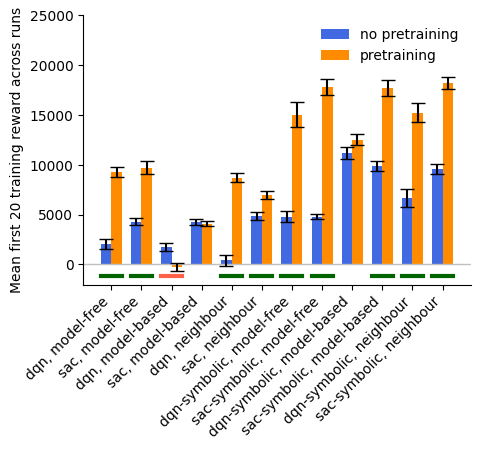

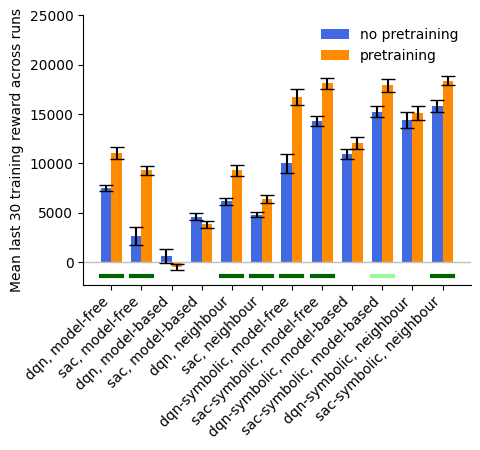

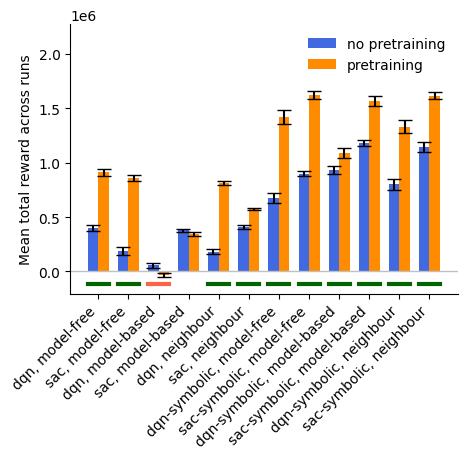

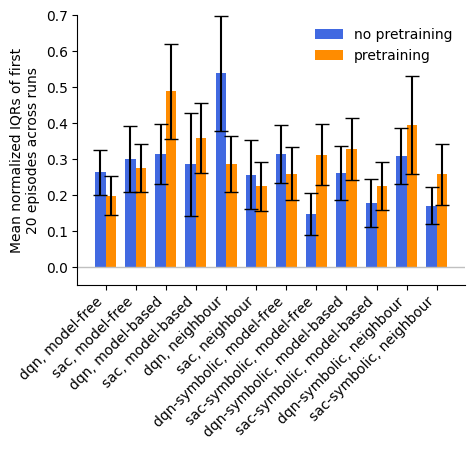

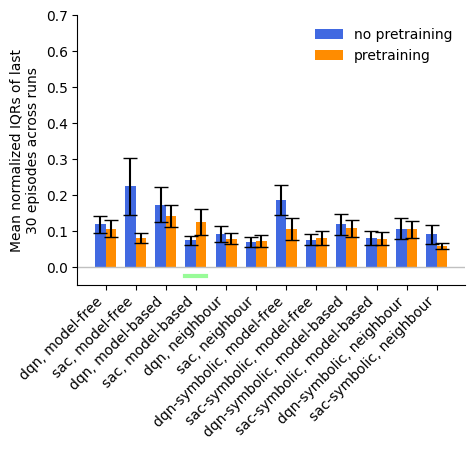

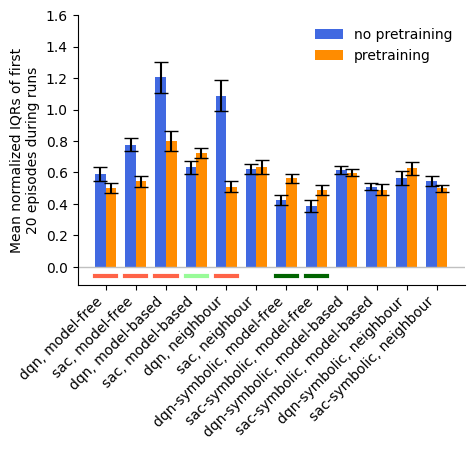

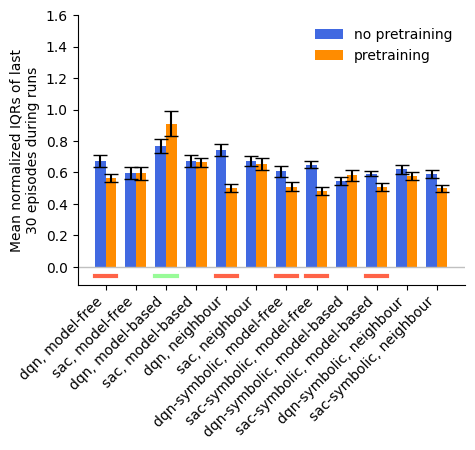

In [25]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
from numpy import random
random.seed(42)
from tqdm import tqdm
import seaborn as sns
import pickle
import os
from scipy import stats


omega_c = 0.01
T = 5

SEEDS = [101,102,103,104,105]
AGENT_TYPES = ["prioritized","sac","prioritized_symbolic","sac_symbolic"]
MBRL_KEYS = ["non-mbrl","mbrl","neighbour"]
GROUND_TYPES = [-1.0,0.0,1.0]
DRYWETS = [0.0,1.0]
data_type = "cumulative_training_rewards"

# mbrl_key = "non-mbrl"
# mbrl_key = "neighbour"
mbrl_key = "mbrl"

legend_dict = {
    "prioritized":"dqn",
    "sac":"sac",
    "prioritized_symbolic":"dqn-symbolic",
    "sac_symbolic":"sac-symbolic",
    "non-mbrl":"model-free",
    "neighbour":"neighbour",
    "mbrl":"model-based"
}

legend_dict_reverse = {
    "dqn":"prioritized",
    "sac":"sac",
    "dqn-symbolic":"prioritized_symbolic",
    "sac-symbolic":"sac_symbolic",
    "model-free":"non-mbrl",
    "neighbour":"neighbour",
    "model-based":"mbrl"
}

color_dict = {
    "dqn, model-free":"red",
    "sac, model-free":"blue",
    "dqn-symbolic, model-free":"yellow",
    "sac-symbolic, model-free":"forestgreen",
    "dqn, neighbour":"maroon",
    "sac, neighbour":"navy",
    "dqn-symbolic, neighbour":"darkgoldenrod",
    "sac-symbolic, neighbour":"darkgreen",
    "dqn, model-based":"magenta",
    "sac, model-based":"cyan",
    "dqn-symbolic, model-based":"darkorange",
    "sac-symbolic, model-based":"lime",
    "only filtered":"grey",
    "only random":"silver"
}


def generate_path_for_results(plot_tuple,ground_type, drywet, seed):
    if plot_tuple == "only filtered":
        path = f"experiments/evaluations/results/symbolic_only_filter_{ground_type}_{drywet}_{seed}.pickle"
        return path
    elif plot_tuple == "only random":
        path = f"experiments/evaluations/results/only_random_{ground_type}_{drywet}_{seed}.pickle"
        return path
    else:
        data_key_tuple = (legend_dict_reverse[plot_tuple.split(", ")[0]],legend_dict_reverse[plot_tuple.split(", ")[1]])
        path = f"experiments/evaluations/results/{data_key_tuple[0]}_{data_key_tuple[1]}_{ground_type}_{drywet}_{seed}.pickle"
        return path
    



def create_intermediate_pretraining_results(seeds, data_key_tuples, window_length, overwrite = False):
    ground_type = 0.0
    drywet = 1.0
    n_runs = 15
    n_episodes = 90
    intermediate_result_path_pretraining = "plots/statistical_tests/pretrained_intermediate_results"
    intermediate_result_path_base = "plots/statistical_tests/base_intermediate_results"
    partial_calculate_iqr_across_time_window = partial(calculate_iqr_across_time_window, window_length=window_length)
    plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    intermediate_data_dict = {
        "pretrained":{},
        "base":{}
    }
    keys = ["pretrained","base"]
    for intended_key in keys:
        for plot_tuple in plot_tuples:
            if intended_key == "pretrained":
                if plot_tuple in ["only filtered","only random"]:
                    current_path = intermediate_result_path_base+f"/{plot_tuple}.pickle"
                    key = "base"
                else:
                    current_path = intermediate_result_path_pretraining+f"/{plot_tuple}.pickle"
                    key = "pretrained"
            else:
                if plot_tuple in ["only filtered","only random"]:
                    continue
                else:
                    current_path = intermediate_result_path_base+f"/{plot_tuple}.pickle"
                    key = "base"
            # check if path  already exists
            
            # check if file exists under the path
            if os.path.exists(current_path) and not overwrite:
                with open(current_path,"rb") as f:
                    intermediate_data_dict[key][plot_tuple] = pickle.load(f)
            else:
                intermediate_data_dict[key][plot_tuple] = {}
                rewards_across_runs = np.empty((0,n_episodes))
                cumulative_rewards_across_runs = np.empty((0,n_episodes))
                diffs_during_runs = np.empty((0,n_episodes-1))
                for seed in seeds:
                    test_seeds = [seed+5,seed+10,seed+15]
                    for test_seed in test_seeds:
                        if key == "pretrained":
                            path = generate_path_for_pretrained_results(plot_tuple, seed, test_seed)
                        else:
                            path = generate_path_for_results(plot_tuple, ground_type, drywet, test_seed)
                        with open(path,"rb") as f:
                            result = pickle.load(f)
                        rewards = result["training_rewards"][:n_episodes]
                        diff_rewards = np.diff(rewards)
                        cumulative_rewards = result["cumulative_training_rewards"][:n_episodes]
                        rewards_across_runs = np.vstack((rewards_across_runs,rewards))
                        cumulative_rewards_across_runs = np.vstack((cumulative_rewards_across_runs,cumulative_rewards))
                        diffs_during_runs = np.vstack((diffs_during_runs,diff_rewards))

                intermediate_data_dict[key][plot_tuple]["mean_rewards_across_runs_first20"]=np.mean(rewards_across_runs[:,:20],axis=1)
                intermediate_data_dict[key][plot_tuple]["mean_rewards_across_runs_last30"]=np.mean(rewards_across_runs[:,-30:],axis=1)
                intermediate_data_dict[key][plot_tuple]["q95_rewards_across_runs"] = np.quantile(rewards_across_runs,0.95,axis=1)
                intermediate_data_dict[key][plot_tuple]["total_reward_across_runs"]=cumulative_rewards_across_runs[:,-1]
                intermediate_data_dict[key][plot_tuple]["lpf_rewards_across_runs"]=calculate_lpf_raw(rewards_across_runs, omega_c, T)
                iqrs_during_runs = np.apply_along_axis(partial_calculate_iqr_across_time_window,axis=1,arr=diffs_during_runs)
                intermediate_data_dict[key][plot_tuple]["mean_iqrs_during_runs_first20"]=np.mean(iqrs_during_runs[:,:20],axis=1)
                intermediate_data_dict[key][plot_tuple]["mean_iqrs_during_runs_last30"]=np.mean(iqrs_during_runs[:,-30:],axis=1)
                intermediate_data_dict[key][plot_tuple]["mean_iqrs_during_runs_first20_norm"]=np.mean(iqrs_during_runs[:,:20],axis=1)/(intermediate_data_dict[key][plot_tuple]["q95_rewards_across_runs"].max())
                intermediate_data_dict[key][plot_tuple]["mean_iqrs_during_runs_last30_norm"]=np.mean(iqrs_during_runs[:,-30:],axis=1)/(intermediate_data_dict[key][plot_tuple]["q95_rewards_across_runs"].max())

                with open(current_path,"wb") as f:
                    pickle.dump(intermediate_data_dict[key][plot_tuple],f)
    return intermediate_data_dict




def run_2sample_statistical_tests_pretrained(plot_tuple1, type_key1, plot_tuple2,type_key2, folder_name, n_permutations = 10, overwrite = False):
    plot_tuple1_with_type = plot_tuple1+"_"+type_key1
    plot_tuple2_with_type = plot_tuple2+"_"+type_key2
    folder_path = f"plots/statistical_tests/pretrained_results/{folder_name}"
    sig_results_path = f"plots/statistical_tests/pretrained_results/{folder_name}/significance_results.pickle"
    if os.path.exists(sig_results_path):
        with open(sig_results_path,"rb") as f:
            sig_results = pickle.load(f)
    else:
        if not os.path.exists(folder_path):
            os.makedirs(folder_path, exist_ok=True)
        sig_results = {}
    
    result_path1 = f"plots/statistical_tests/{type_key1}_intermediate_results"
    result_path2 = f"plots/statistical_tests/{type_key2}_intermediate_results"
    path1 = result_path1+f"/{plot_tuple1}.pickle"
    path2 = result_path2+f"/{plot_tuple2}.pickle"
    assert os.path.exists(path1), f"Path {path1} for tuple {plot_tuple1} does not exist"
    assert os.path.exists(path2), f"Path {path2} for tuple {plot_tuple2} does not exist"
    with open(path1,"rb") as f:
        intermediate_data_dict1 = pickle.load(f)
    with open(path2,"rb") as f:
        intermediate_data_dict2 = pickle.load(f)
    if plot_tuple1_with_type in sig_results:
        if plot_tuple2_with_type in sig_results[plot_tuple1_with_type]:
            if not overwrite:
                return None
            else:
                print("Already calculated.")
        else:
            sig_results[plot_tuple1_with_type][plot_tuple2_with_type] = {}
    else:
        sig_results[plot_tuple1_with_type] = {}
        sig_results[plot_tuple1_with_type][plot_tuple2_with_type] = {}
    if plot_tuple2_with_type not in sig_results:
        sig_results[plot_tuple2_with_type] = {}
        sig_results[plot_tuple2_with_type][plot_tuple1_with_type] = {}
    else:
        if plot_tuple1_with_type not in sig_results[plot_tuple2_with_type]:
            sig_results[plot_tuple2_with_type][plot_tuple1_with_type] = {}
    
    
    
    # mean rewards across runs first 20
    means1 = intermediate_data_dict1["mean_rewards_across_runs_first20"]
    means2 = intermediate_data_dict2["mean_rewards_across_runs_first20"]
    p_value = permutation_test_mean(means1, means2, n_permutations)
    print(f"Mean rewards across runs first: {plot_tuple1_with_type} > {plot_tuple2_with_type}? with p-value {p_value}")
    sig_results[plot_tuple1_with_type][plot_tuple2_with_type]["mean_rewards_across_runs_first20_1>2"] = p_value
    sig_results[plot_tuple2_with_type][plot_tuple1_with_type]["mean_rewards_across_runs_first20_1>2"] = 1-p_value

    # mean rewards across runs last 30
    means1 = intermediate_data_dict1["mean_rewards_across_runs_last30"]
    means2 = intermediate_data_dict2["mean_rewards_across_runs_last30"]
    p_value = permutation_test_mean(means1, means2, n_permutations)
    print(f"Mean rewards across runs last 30: {plot_tuple1_with_type} > {plot_tuple2_with_type}? with p-value {p_value}")
    sig_results[plot_tuple1_with_type][plot_tuple2_with_type]["mean_rewards_across_runs_last30_1>2"] = p_value
    sig_results[plot_tuple2_with_type][plot_tuple1_with_type]["mean_rewards_across_runs_last30_1>2"] = 1-p_value


    # mean total reward across runs
    means1 = intermediate_data_dict1["total_reward_across_runs"]
    means2 = intermediate_data_dict2["total_reward_across_runs"]
    p_value = permutation_test_mean(means1, means2, n_permutations)
    print(f"Mean total reward across runs: {plot_tuple1_with_type} > {plot_tuple2_with_type}? with p-value {p_value}")
    sig_results[plot_tuple1_with_type][plot_tuple2_with_type]["total_reward_across_runs_1>2"] = p_value
    sig_results[plot_tuple2_with_type][plot_tuple1_with_type]["total_reward_across_runs_1>2"] = 1-p_value

    # mean iqr across runs first 20 normalized
    lpf_rewards1 = intermediate_data_dict1["lpf_rewards_across_runs"]
    lpf_rewards2 = intermediate_data_dict2["lpf_rewards_across_runs"]
    lpf_rewards1_first20 = lpf_rewards1[:,:20]
    lpf_rewards2_first20 = lpf_rewards2[:,:20]
    lpf_rewards1_last30 = lpf_rewards1[:,-30:]
    lpf_rewards2_last30 = lpf_rewards2[:,-30:]
    q95s = intermediate_data_dict1["q95_rewards_across_runs"]
    q95s = intermediate_data_dict2["q95_rewards_across_runs"]
    p_value_first20 = permutation_test_normalized_iqrs(lpf_rewards1_first20, lpf_rewards2_first20, q95s, q95s, n_permutations)
    p_value_last30 = permutation_test_normalized_iqrs(lpf_rewards1_last30, lpf_rewards2_last30, q95s, q95s, n_permutations)
    print(f"Mean normalized IQRs across runs first 20: {plot_tuple1_with_type} > {plot_tuple2_with_type}? with p-value {p_value_first20}")
    print(f"Mean normalized IQRs across runs last 30: {plot_tuple1_with_type} > {plot_tuple2_with_type}? with p-value {p_value_last30}")
    sig_results[plot_tuple1_with_type][plot_tuple2_with_type]["mean_iqrs_across_runs_first20_norm_1>2"] = p_value_first20
    sig_results[plot_tuple2_with_type][plot_tuple1_with_type]["mean_iqrs_across_runs_first20_norm_1>2"] = 1-p_value_first20
    sig_results[plot_tuple1_with_type][plot_tuple2_with_type]["mean_iqrs_across_runs_last30_norm_1>2"] = p_value_last30
    sig_results[plot_tuple2_with_type][plot_tuple1_with_type]["mean_iqrs_across_runs_last30_norm_1>2"] = 1-p_value_last30
    # mean iqr during runs first 20 normalized
    iqrs_during_runs1 = intermediate_data_dict1["mean_iqrs_during_runs_first20_norm"]
    iqrs_during_runs2 = intermediate_data_dict2["mean_iqrs_during_runs_first20_norm"]
    p_value = permutation_test_mean(iqrs_during_runs1, iqrs_during_runs2, n_permutations)
    print(f"Mean normalized IQRs during runs first 20: {plot_tuple1_with_type} > {plot_tuple2_with_type}? with p-value {p_value}")
    sig_results[plot_tuple1_with_type][plot_tuple2_with_type]["mean_iqrs_during_runs_first20_norm_1>2"] = p_value
    sig_results[plot_tuple2_with_type][plot_tuple1_with_type]["mean_iqrs_during_runs_first20_norm_1>2"] = 1-p_value
    

    # mean iqr during runs last 30 normalized
    iqrs_during_runs1 = intermediate_data_dict1["mean_iqrs_during_runs_last30_norm"]
    iqrs_during_runs2 = intermediate_data_dict2["mean_iqrs_during_runs_last30_norm"]
    p_value = permutation_test_mean(iqrs_during_runs1, iqrs_during_runs2, n_permutations)
    print(f"Mean normalized IQRs during runs last 30: {plot_tuple1_with_type} > {plot_tuple2_with_type}? with p-value {p_value}")
    sig_results[plot_tuple1_with_type][plot_tuple2_with_type]["mean_iqrs_during_runs_last30_norm_1>2"] = p_value
    sig_results[plot_tuple2_with_type][plot_tuple1_with_type]["mean_iqrs_during_runs_last30_norm_1>2"] = 1-p_value

    with open(sig_results_path,"wb") as f:
        pickle.dump(sig_results,f)

    return sig_results_path

def barplot_means_and_sigdiffs_pretrained(seeds, data_key_tuples, window_length, folder_name = None, n_permutations = 1000, overwrite = False):
    result_paths = {
        "pretrained":"plots/statistical_tests/pretrained_results",
        "base":"plots/statistical_tests/results_cropped90ep"
    }
    sig_results_path = f"plots/statistical_tests/pretrained_results/{folder_name}/significance_results.pickle"
    intermediate_results_dict = create_intermediate_pretraining_results(seeds, data_key_tuples, window_length, overwrite = overwrite)
    base_plot_tuples = [f"{legend_dict[dk_tuple[0]]}, {legend_dict[dk_tuple[1]]}" for dk_tuple in data_key_tuples]+["only filtered","only random"]
    plot_tuples = []
    for pt in base_plot_tuples:
        if pt not in ["only random","only filtered"]:
            plot_tuples.append((pt,"pretrained"))
            plot_tuples.append((pt,"base"))
        else:
            plot_tuples.append((pt,"base"))
    if folder_name is not None:
        general_path = f"plots/statistical_tests/pretrained_vis/{folder_name}"
        if not os.path.exists(general_path):
            os.makedirs(general_path)
    for plot_tuple1_tuple in plot_tuples:
        for plot_tuple2_tuple in plot_tuples[1:]:
            if plot_tuple1_tuple != plot_tuple2_tuple:
                run_2sample_statistical_tests_pretrained(plot_tuple1_tuple[0], plot_tuple1_tuple[1], plot_tuple2_tuple[0], plot_tuple2_tuple[1], folder_name, n_permutations = n_permutations, overwrite = overwrite)

    with open(sig_results_path,"rb") as f:
        sig_results = pickle.load(f)
    bootstrap_results_dict = {
        "pretrained":{},
        "base":{}
    }
    for plot_tuple_tuple in plot_tuples:
        bootstrap_results_path = result_paths[plot_tuple_tuple[1]]+f"/{plot_tuple_tuple[0]}_{50000}.pickle"
        if os.path.exists(bootstrap_results_path):
            with open(bootstrap_results_path,"rb") as f:
                bootstrap_results_dict[plot_tuple_tuple[1]][plot_tuple_tuple[0]] = pickle.load(f)
        else:
            raise ValueError(f"Path {bootstrap_results_path} does not exist.")

    def convert_type_key_to_suffix(type_key):
        if type_key == "pretrained":
            return ", pre"
        elif type_key == "base":
            return ""
        else:
            raise ValueError(f"Type key {type_key} not recognized.")
    def plot_for_single_metric_pretrained(key, ylabel, bootstrap_key = None):
        if not bootstrap_key:
            bootstrap_key = key
        # Mean first 20 training rewards barplot with significance levels
        plt.figure(figsize = (5,4))
        sorted_plot_tuples = []
        max_mean = -np.inf
        for plot_tuple_tuple in plot_tuples:
            a = np.array(bootstrap_results_dict[plot_tuple_tuple[1]][plot_tuple_tuple[0]][bootstrap_key])
            tmp_mean = np.mean(a)
            if tmp_mean > max_mean:
                max_mean = tmp_mean
            sorted_plot_tuples.append((tmp_mean,plot_tuple_tuple[0],plot_tuple_tuple[1]))
        sorted_plot_tuples = sorted(sorted_plot_tuples)   
        a = np.array([bootstrap_results_dict[type_key][plot_tuple][bootstrap_key] for _, plot_tuple, type_key in sorted_plot_tuples])
        plt.bar(range(len(plot_tuples)),a.mean(axis=1),yerr=a.std(axis=1),color=[color_dict_pretrained[type_key][plot_tuple] for _, plot_tuple, type_key in sorted_plot_tuples],capsize=5, zorder=2)
        plt.xticks(range(len(plot_tuples)), [plot_tuple+convert_type_key_to_suffix(type_key) for _, plot_tuple, type_key in sorted_plot_tuples], rotation=45, ha="right")
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.ylabel(ylabel)
        if folder_name is not None:
            image_path = f"{general_path}/{bootstrap_key}_barplot.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{bootstrap_key}_barplot.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()


    def plot_statdiff_matrix_pretrained(key, ylabel, bootstrap_key = None):
        if not bootstrap_key:
            bootstrap_key = key
        # Mean first 20 training rewards barplot with significance levels
        plt.figure(figsize = (3.5,3.5))
        sorted_plot_tuples = []
        max_mean = -np.inf
        for plot_tuple_tuple in plot_tuples:
            a = np.array(bootstrap_results_dict[plot_tuple_tuple[1]][plot_tuple_tuple[0]][bootstrap_key])
            tmp_mean = np.mean(a)
            if tmp_mean > max_mean:
                max_mean = tmp_mean
            sorted_plot_tuples.append((tmp_mean,plot_tuple_tuple[0],plot_tuple_tuple[1]))
        sorted_plot_tuples = sorted(sorted_plot_tuples)
        sorted_plot_tuples = sorted(sorted_plot_tuples, reverse = True)
        reverse_plot_tuples = sorted(sorted_plot_tuples, reverse = False)
        a = np.array([bootstrap_results_dict[type_key][plot_tuple][bootstrap_key] for _, plot_tuple, type_key in sorted_plot_tuples])
        num_rows = a.shape[0]
        matrix_data = np.zeros((num_rows,num_rows))
        for i in range(num_rows):
            for j in range(i+1, num_rows):
                if i != j:
                    plot_tuple1_tuple, plot_tuple2_tuple = sorted_plot_tuples[i], sorted_plot_tuples[j]
                    plot_tuple1 = plot_tuple1_tuple[1]
                    plot_tuple2 = plot_tuple2_tuple[1]
                    type_key1 = plot_tuple1_tuple[2]
                    type_key2 = plot_tuple2_tuple[2]
                    plot_tuple1_with_type = plot_tuple1+"_"+type_key1
                    plot_tuple2_with_type = plot_tuple2+"_"+type_key2
                    if sig_results[plot_tuple1_with_type][plot_tuple2_with_type][f"{key}_1>2"] > 0.99:
                        matrix_data[i, j] = -2
                        matrix_data[j, i] = 2
                    elif sig_results[plot_tuple1_with_type][plot_tuple2_with_type][f"{key}_1>2"] > 0.95:
                        matrix_data[i, j] = -1
                        matrix_data[j, i] = 1
                    elif sig_results[plot_tuple1_with_type][plot_tuple2_with_type][f"{key}_1>2"] > 0.05:
                        matrix_data[i, j] = 0
                        matrix_data[j, i] = 0
                    elif sig_results[plot_tuple1_with_type][plot_tuple2_with_type][f"{key}_1>2"] > 0.01:
                        matrix_data[i, j] = 1
                        matrix_data[j, i] = -1
                    else:
                        matrix_data[i, j] = 2
                        matrix_data[j, i] = -2
        # Create a colormap where 2 is dark green, 1 is light green, 0 is white, -1 is light red, -2 is dark red
        colors = ['#8B0000', '#FF6347', '#D3D3D3', '#98FB98', '#006400']
        custom_cmap = ListedColormap(colors)
        matrix_data = matrix_data[:,::-1]
        plt.imshow(matrix_data, cmap=custom_cmap, vmin=-2, vmax=2)
        plt.xticks(range(len(plot_tuples)), [plot_tuple+convert_type_key_to_suffix(type_key) for _, plot_tuple, type_key in reverse_plot_tuples], rotation=45, ha="right")
        plt.yticks(range(len(plot_tuples)), [plot_tuple+convert_type_key_to_suffix(type_key) for _, plot_tuple, type_key in sorted_plot_tuples])
        # insert grid between each row and column
        for i in range(num_rows-1):
            plt.axhline(i+0.5, color='w', linewidth=1.5)
            plt.axvline(i+0.5, color='w', linewidth=1.5)

        if folder_name is not None:
            image_path = f"{general_path}/{bootstrap_key}_matplot.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{bootstrap_key}_matplot.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()



    def direct_comparison_pretraining(key, ylabel, bootstrap_key = None, ymax = None):
        
        # Define the width of the bars
        bar_width = 0.35

        # Define the colors for the bars
        colors = ['royalblue', 'darkorange']
        labels = ["dqn, model-free","sac, model-free","dqn, model-based","sac, model-based","dqn, neighbour","sac, neighbour","dqn-symbolic, model-free","sac-symbolic, model-free","dqn-symbolic, model-based","sac-symbolic, model-based","dqn-symbolic, neighbour","sac-symbolic, neighbour"]
        compare_topic = "no-pt_pt"
        type_keys = ["pretrained","base"]
        legend = ["no pretraining","pretraining"]
        # Initialize a list to store the x-tick labels
        xtick_labels = []

        # Initialize a list to store the x-tick positions
        xticks = []
        if not bootstrap_key:
            bootstrap_key = key
        plt.figure(figsize = (5,3.5))
        min_mean = np.inf
        max_mean = -np.inf
        for i, label in enumerate(labels):
            
            results1 = np.array(bootstrap_results_dict["base"][label][bootstrap_key])
            results2 = np.array(bootstrap_results_dict["pretrained"][label][bootstrap_key])
            mean1 = np.mean(results1)
            mean2 = np.mean(results2)
            if mean1 < min_mean:
                min_mean = mean1
            if mean2 < min_mean:
                min_mean = mean2
            if mean1 > max_mean:
                max_mean = mean1
            if mean2 > max_mean:
                max_mean = mean2
            std1 = np.std(results1)
            std2 = np.std(results2)
            xticks.append(i)
            xtick_labels.append(label)
            plt.bar(i-bar_width/2, mean1, width=bar_width, color=colors[0], yerr=std1, capsize=5)
            plt.bar(i+bar_width/2, mean2, width=bar_width, color=colors[1], yerr=std2, capsize=5)

        min_mean_or_zero = min(min_mean,0.0)
        # Create legend describing the two colors for the bars
        plt.legend(legend, loc='upper right', frameon=False)
        for i, label in enumerate(labels):
            plot_tuple1_with_type = label+"_base"
            plot_tuple2_with_type = label+"_pretrained"
            sig_result = sig_results[plot_tuple1_with_type][plot_tuple2_with_type][f"{key}_1>2"] 
            if ymax:
                max_mean = ymax/1.4
            if  sig_result > 0.99:
                plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='#006400', linewidth=3)
            elif sig_result > 0.95:
                plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='#98FB98', linewidth=3)
            elif sig_result < 0.05:
                plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='#FF6347', linewidth=3)
            elif sig_result < 0.01:
                plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='#8B0000', linewidth=3)
            else:
                plt.plot([i - bar_width, i + bar_width], [min_mean_or_zero - 0.05*max_mean] * 2, color='white', linewidth=3)
        # Mean first 20 training rewards barplot with significance levels
        plt.xticks(xticks, xtick_labels, rotation=45, ha="right")
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        # add horzontal grey line to 0
        plt.axhline(0, color='silver', alpha = 1.0, linewidth=1.0, zorder=1)
        # for i, t in enumerate(sorted_plot_tuples):
        #     plt.axvline(i, color='silver', alpha = 1.0, linestyle='dotted', linewidth=1.0, zorder=1)
        plt.ylabel(ylabel)
        if ymax:
            plt.ylim(top=ymax, bottom=min_mean_or_zero - 0.1*max_mean)
        else:
            plt.ylim(top=max_mean*1.4)
        if folder_name is not None:
            image_path = f"{general_path}/{bootstrap_key}_compare_{compare_topic}.pdf"
            plt.savefig(image_path, bbox_inches='tight')
            image_path = f"{general_path}/{bootstrap_key}_compare_{compare_topic}.png"
            plt.savefig(image_path, bbox_inches='tight')
        plt.show()

    key = "mean_rewards_across_runs_first20"
    ylabel = "Mean first 20 training reward across runs"
    direct_comparison_pretraining(key, ylabel, ymax=25000)
    # plot_for_single_metric_pretrained(key, ylabel)
    # plot_statdiff_matrix_pretrained(key, ylabel)

    key = "mean_rewards_across_runs_last30"
    ylabel = "Mean last 30 training reward across runs"
    direct_comparison_pretraining(key, ylabel, ymax=25000)
    # plot_for_single_metric_pretrained(key, ylabel)
    # plot_statdiff_matrix_pretrained(key, ylabel)

    key = "total_reward_across_runs"
    ylabel = "Mean total reward across runs"
    bootstrap_key = "mean_total_reward_across_runs"
    direct_comparison_pretraining(key, ylabel, bootstrap_key = bootstrap_key)
    # plot_for_single_metric_pretrained(key, ylabel, bootstrap_key = bootstrap_key)
    # plot_statdiff_matrix_pretrained(key, ylabel, bootstrap_key = bootstrap_key)

    key = "mean_iqrs_across_runs_first20_norm"
    ylabel = "Mean normalized IQRs of first\n20 episodes across runs"
    direct_comparison_pretraining(key, ylabel, ymax = 0.7)
    # plot_for_single_metric_pretrained(key,ylabel)
    # plot_statdiff_matrix_pretrained(key, ylabel)

    key = "mean_iqrs_across_runs_last30_norm"
    ylabel = "Mean normalized IQRs of last\n30 episodes across runs"
    direct_comparison_pretraining(key, ylabel, ymax = 0.7)
    # plot_for_single_metric_pretrained(key,ylabel)
    # plot_statdiff_matrix_pretrained(key, ylabel)

    key = "mean_iqrs_during_runs_first20_norm"
    ylabel = "Mean normalized IQRs of first\n20 episodes during runs"
    direct_comparison_pretraining(key, ylabel, ymax = 1.6)
    # plot_for_single_metric_pretrained(key,ylabel)
    # plot_statdiff_matrix_pretrained(key, ylabel)

    key = "mean_iqrs_during_runs_last30_norm"
    ylabel = "Mean normalized IQRs of last\n30 episodes during runs"
    direct_comparison_pretraining(key, ylabel, ymax = 1.6)
    # plot_for_single_metric_pretrained(key,ylabel)
    # plot_statdiff_matrix_pretrained(key, ylabel)




# folder_name = "dqn_all_pt_baseline"
# agent_type = "prioritized"
# agent_type2 = "prioritized_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# barplot_means_and_sigdiffs_pretrained(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, n_permutations = 1000, overwrite = True)

# folder_name = "sac_all_pt_baseline"
# agent_type = "sac"
# agent_type2 = "sac_symbolic"
# data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl")]
# barplot_means_and_sigdiffs_pretrained(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, n_permutations = 1000, overwrite = True)

folder_name = "all_all_pt_baseline"
agent_type = "prioritized"
agent_type2 = "sac"
agent_type3 = "prioritized_symbolic"
agent_type4 = "sac_symbolic"
data_key_tuples = [(agent_type,"non-mbrl"),(agent_type,"neighbour"),(agent_type,"mbrl"),(agent_type2,"non-mbrl"),(agent_type2,"neighbour"),(agent_type2,"mbrl"),(agent_type3,"non-mbrl"),(agent_type3,"neighbour"),(agent_type3,"mbrl"),(agent_type4,"non-mbrl"),(agent_type4,"neighbour"),(agent_type4,"mbrl")]
barplot_means_and_sigdiffs_pretrained(SEEDS, data_key_tuples = data_key_tuples, window_length = 15, folder_name = folder_name, n_permutations = 1000, overwrite = False)
